<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/Syn_MELD_KM_Mayo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=5ac4ff4819e1e215206996c21edc5cb4e1289de291b88bdced3b4aa24df9f18b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_natural_survival_full.csv')
df = pd.read_csv('/content/drive/MyDrive/synthetic_meld_data/mayo_df_final.csv')
real_df = df.copy()

# (Optional) Display first few rows
display(real_df.head())


Using device: cuda


INIT_AGE INIT_AGENDER  INIT_ALBUMIN  INIT_BILIRUBIN  INIT_SERUM_CREAT  \
0        70            M           3.8             0.7              2.00   
1        65            F           4.1             1.9              0.83   
2        53            F           4.2             0.3              0.81   
3        21            M           4.8             3.7              1.11   
4        45            F           2.5            10.1              1.04   

   INIT_INR  INIT_SERUM_SODIUM  outcome  time_to_event Ethnicity Etiology  \
0       1.1              141.0        1           2490     White  Alcohol   
1       3.2              140.0        1           2330     White    Viral   
2       1.0              140.0        1           1280     Asian    Viral   
3       1.7              136.0        2            264     White  Biliary   
4       4.4              133.0        0             36     White  Biliary   

  Encephalopathy_Status Ascites_Status diab_group_labeled  
0             Grade 1-2         Slight        No Diabetes  
1                   NaN         Slight           Diabetes  
2                   NaN            NaN        No Diabetes  
3                   NaN         Slight        No Diabetes  
4                   NaN         Slight        No Diabetes

In [ ]:
# Create the column mapping dictionary (reversed from before)
column_mapping = {
    'INIT_AGE': 'Age',
    'INIT_AGENDER': 'Gender',
    'INIT_ALBUMIN': 'Albumin',
    'INIT_BILIRUBIN': 'Bili',
    'INIT_SERUM_CREAT': 'Cr',
    'INIT_INR': 'INR',
    'INIT_SERUM_SODIUM': 'Na',
    'time_to_event': 'tte'
}

# Rename the columns in real_df
real_df = real_df.rename(columns=column_mapping)

In [ ]:
real_df.columns

Index(['Age', 'Gender', 'Albumin', 'Bili', 'Cr', 'INR', 'Na', 'outcome', 'tte',
       'Ethnicity', 'Etiology', 'Encephalopathy_Status', 'Ascites_Status',
       'diab_group_labeled'],
      dtype='object')

In [ ]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
print("Real dataset shape:", real_df.shape)

# Columns to drop from synthetic dataset
columns_to_drop = ['BMI', 'MELD', 'ABO', 'Dialysis']

# Drop the columns
syn_df = syn_df.drop(columns=columns_to_drop)

# Verify the new shapes
print("Real dataset shape:", real_df.shape)
print("Synthetic dataset shape:", syn_df.shape)

# Verify columns are matching
print("\nSynthetic dataset columns:", list(syn_df.columns))
print("\nReal dataset columns:", list(real_df.columns))

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (9395, 14)
Real dataset shape: (9395, 14)
Synthetic dataset shape: (10000000, 14)

Synthetic dataset columns: ['Age', 'Na', 'Cr', 'INR', 'Bili', 'Albumin', 'tte', 'Gender', 'Etiology', 'Ethnicity', 'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status', 'outcome']

Real dataset columns: ['Age', 'Gender', 'Albumin', 'Bili', 'Cr', 'INR', 'Na', 'outcome', 'tte', 'Ethnicity', 'Etiology', 'Encephalopathy_Status', 'Ascites_Status', 'diab_group_labeled']
Synthetic dataset shape: (10000000, 14)


In [ ]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Slight' 'None' 'Moderate']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4']

Synthetic df unique values:

Ascites_Status categories: ['None' 'Moderate' 'Slight' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['None' 'Grade 1-2' 'Grade 3-4' 'Unknown/Not Reported']


In [ ]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M']


In [ ]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [ ]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [ ]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (9395, 7)
Synthetic features shape: (10000000, 7)


In [ ]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=100000, sim_threshold=30, dissim_threshold=100):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])
                if time_diff < sim_threshold:
                    label = 1.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                else:
                    continue
                self.pairs.append((i, j))
                self.labels.append(label)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [ ]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(syn_features,
                          syn_df["tte"].values,
                          syn_df["outcome"].values,
                          n_pairs=100000,
                          sim_threshold=30,
                          dissim_threshold=100)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 100000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [ ]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Define contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Return mean loss
    loss = torch.mean(loss_sim + loss_dissim)
    return loss

In [ ]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    for x1, x2, label in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        loss = contrastive_loss(emb1, emb2, label, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.0917
Epoch 2/200, Loss: 0.0778
Epoch 3/200, Loss: 0.0714
Epoch 4/200, Loss: 0.0674
Epoch 5/200, Loss: 0.0656
Epoch 6/200, Loss: 0.0655
Epoch 7/200, Loss: 0.0650
Epoch 8/200, Loss: 0.0646
Epoch 9/200, Loss: 0.0642
Epoch 10/200, Loss: 0.0639
Epoch 11/200, Loss: 0.0637
Epoch 12/200, Loss: 0.0632
Epoch 13/200, Loss: 0.0630
Epoch 14/200, Loss: 0.0625
Epoch 15/200, Loss: 0.0625
Epoch 16/200, Loss: 0.0622
Epoch 17/200, Loss: 0.0621
Epoch 18/200, Loss: 0.0619
Epoch 19/200, Loss: 0.0623
Epoch 20/200, Loss: 0.0623
Epoch 21/200, Loss: 0.0618
Epoch 22/200, Loss: 0.0618
Epoch 23/200, Loss: 0.0616
Epoch 24/200, Loss: 0.0620
Epoch 25/200, Loss: 0.0614
Epoch 26/200, Loss: 0.0614
Epoch 27/200, Loss: 0.0612
Epoch 28/200, Loss: 0.0614
Epoch 29/200, Loss: 0.0614
Epoch 30/200, Loss: 0.0612
Epoch 31/200, Loss: 0.0612
Epoch 32/200, Loss: 0.0614
Epoch 33/200, Loss: 0.0610
Epoch 34/200, Loss: 0.0610
Epoch 35/200, Loss: 0.0611
Epoch 36/200, Loss: 0.0612
Epoch 37/200, Loss: 0.0608
Epoch 38/2

In [ ]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/10000000 samples
Processed 10000/10000000 samples
Processed 20000/10000000 samples
Processed 30000/10000000 samples
Processed 40000/10000000 samples
Processed 50000/10000000 samples
Processed 60000/10000000 samples
Processed 70000/10000000 samples
Processed 80000/10000000 samples
Processed 90000/10000000 samples
Processed 100000/10000000 samples
Processed 110000/10000000 samples
Processed 120000/10000000 samples
Processed 130000/10000000 samples
Processed 140000/10000000 samples
Processed 150000/10000000 samples
Processed 160000/10000000 samples
Processed 170000/10000000 samples
Processed 180000/10000000 samples
Processed 190000/10000000 samples
Processed 200000/10000000 samples
Processed 210000/10000000 samples
Processed 220000/10000000 samples
Processed 230000/10000000 samples
Processed 240000/10000000 samples
Processed 250000/10000000 samples
Processed 260000/10000000 samples
Processed 270000/10000000 samples
Processed 280000/10000000 sa

In [ ]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])
    creatinine = min(3.0, max(1.0, row['Cr']))
    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for both dataframes
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)


# Display sample results for verification
print("\nMayo DF sample:")
print(real_df[['Gender', 'Bili', 'Na', 'INR',
               'Cr', 'Albumin', 'meld3']].head())




Mayo DF sample:
  Gender  Bili     Na  INR    Cr  Albumin  meld3
0      M   0.7  141.0  1.1  2.00      3.8     15
1      F   1.9  140.0  3.2  0.83      4.1     21
2      F   0.3  140.0  1.0  0.81      4.2      7
3      M   3.7  136.0  1.7  1.11      4.8     18
4      F  10.1  133.0  4.4  1.04      2.5     35


In [ ]:
pip install tqdm_joblib

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 200
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_tte
0          1693.240228
1           736.824422
2          2823.840872
3          1007.556235
4             9.000000


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Define the neighbor sizes to experiment with
neighbor_sizes = [10, 25, 50, 75, 100, 200]

# Function to compute Kaplan-Meier median survival from a small sample
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    """
    # Sort times and events by times
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n

    # Loop over each unique time
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1

    # If survival never drops below 0.5, fallback to max observed time
    if median_time is None:
        median_time = times[-1]

    return median_time

# Function to compute local median with variable k (using pre-computed indices)
def compute_local_median_with_k(idx, k, indices, syn_df):
    """
    Compute median survival using only k nearest neighbors
    """
    # Use only the first k neighbors
    neighbor_idxs = indices[idx, :k]
    neighbor_tte = syn_df.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# Generate predictions for different neighbor counts
def generate_neighbor_predictions(real_df, indices_all, syn_df_processed):
    """
    Generate predictions using different numbers of neighbors
    """
    n_real = len(real_df)

    # Process synthetic data once
    syn_df = syn_df_processed.copy()
    # Ensure we have death_event and death_tte columns
    if 'death_event' not in syn_df.columns:
        syn_df['death_event'] = syn_df['outcome'].apply(lambda x: 1 if x == 0 else 0)
    if 'death_tte' not in syn_df.columns:
        syn_df['death_tte'] = syn_df['tte']

    print(f"Generating predictions for {len(neighbor_sizes)} different neighbor counts")

    # Generate predictions for each neighbor size
    for k in neighbor_sizes:
        print(f"\nComputing predictions with k={k} neighbors")

        # Use parallel processing with progress bar
        with tqdm_joblib(tqdm(desc=f"Processing with k={k}", total=n_real)) as progress_bar:
            predictions = Parallel(n_jobs=-1, backend="threading")(
                delayed(compute_local_median_with_k)(i, k, indices_all, syn_df)
                for i in range(n_real)
            )

        # Add predictions to real_df
        column_name = f'predicted_death_tte_k{k}'
        real_df[column_name] = np.array(predictions)

        # Print basic stats about predictions
        print(f"  Mean prediction: {np.mean(predictions):.2f} days")
        print(f"  Median prediction: {np.median(predictions):.2f} days")
        print(f"  Range: {np.min(predictions):.2f} to {np.max(predictions):.2f} days")

    return real_df

# Run the function to generate predictions
# Note: This assumes indices_all and syn_df_processed are already available
try:
    print("Starting generation of predictions with different neighbor counts")
    real_df = generate_neighbor_predictions(real_df, indices_all, syn_df_processed)
    print("\nFinished generating predictions")
    print("New columns added:", [f'predicted_death_tte_k{k}' for k in neighbor_sizes])
except Exception as e:
    print(f"Error generating predictions: {str(e)}")

Starting generation of predictions with different neighbor counts
Generating predictions for 6 different neighbor counts

Computing predictions with k=10 neighbors



Processing with k=10:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1318.31 days
  Median prediction: 1193.24 days
  Range: 1.38 to 2982.00 days

Computing predictions with k=25 neighbors




Processing with k=25:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1422.31 days
  Median prediction: 1365.68 days
  Range: 3.00 to 2982.00 days

Computing predictions with k=50 neighbors





Processing with k=50:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1433.66 days
  Median prediction: 1369.60 days
  Range: 3.42 to 2982.00 days

Computing predictions with k=75 neighbors






Processing with k=75:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1435.08 days
  Median prediction: 1367.74 days
  Range: 4.00 to 2982.00 days

Computing predictions with k=100 neighbors







Processing with k=100:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1434.19 days
  Median prediction: 1377.48 days
  Range: 3.89 to 2982.00 days

Computing predictions with k=200 neighbors








Processing with k=200:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

  Mean prediction: 1434.18 days
  Median prediction: 1371.78 days
  Range: 4.21 to 2982.00 days

Finished generating predictions
New columns added: ['predicted_death_tte_k10', 'predicted_death_tte_k25', 'predicted_death_tte_k50', 'predicted_death_tte_k75', 'predicted_death_tte_k100', 'predicted_death_tte_k200']


Processing with k=200:   0%|          | 0/9395 [00:08<?, ?it/s]

Using meld3 as the MELD score column
Analyzing time point: 7 days


Analyzing time point: 14 days
Analyzing time point: 30 days
Analyzing time point: 90 days
Analyzing time point: 180 days
Analyzing time point: 360 days

Concordance Indices by Time Point and Neighbor Count:
   Time   meld    k10  k10+meld    k25  k25+meld    k50  k50+meld    k75  k75+meld   k100  k100+meld   k200  k200+meld
0     7  0.894  0.892     0.896  0.895     0.898  0.899     0.899  0.899     0.899  0.900      0.900  0.901      0.900
1    14  0.874  0.868     0.877  0.870     0.877  0.875     0.878  0.879     0.880  0.881      0.881  0.883      0.882
2    30  0.859  0.847     0.861  0.852     0.861  0.859     0.864  0.863     0.865  0.866      0.867  0.869      0.868
3    90  0.824  0.816     0.830  0.822     0.831  0.833     0.836  0.835     0.837  0.837      0.837  0.839      0.839
4   180  0.803  0.796     0.810  0.807     0.814  0.814     0.817  0.817     0.818  0.818      0.819  0.822      0.821
5   360  0.784  0.778     0.792  0.789     0.796  0.796     0.799  0.799     0.

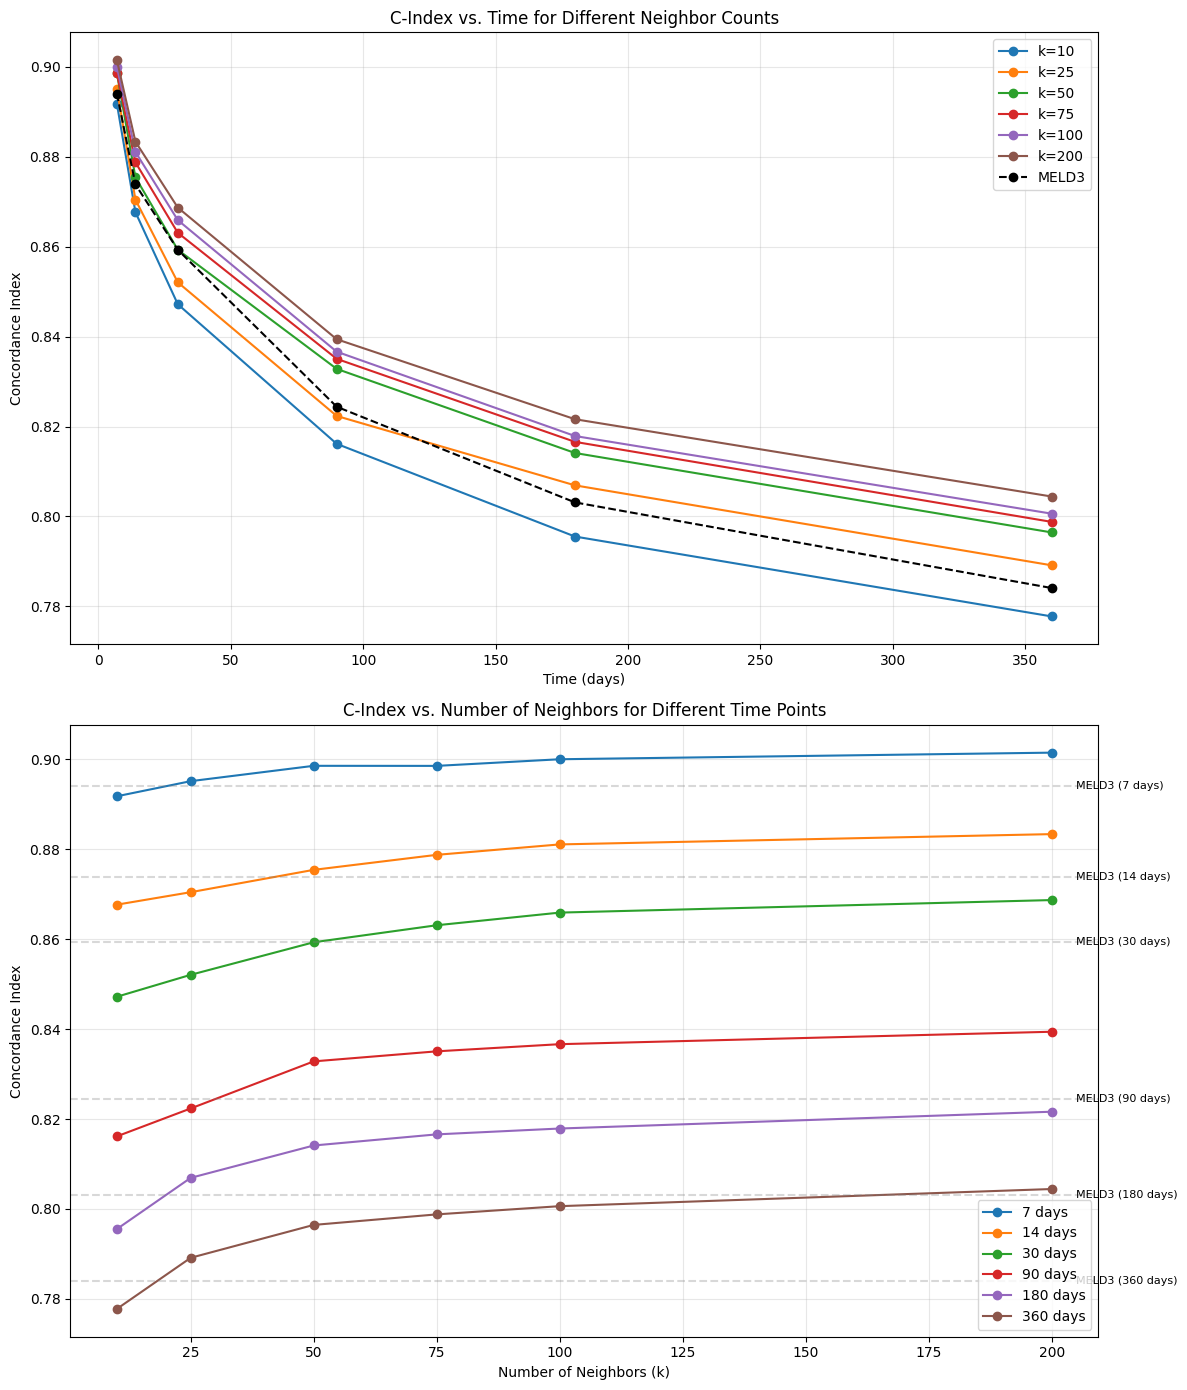

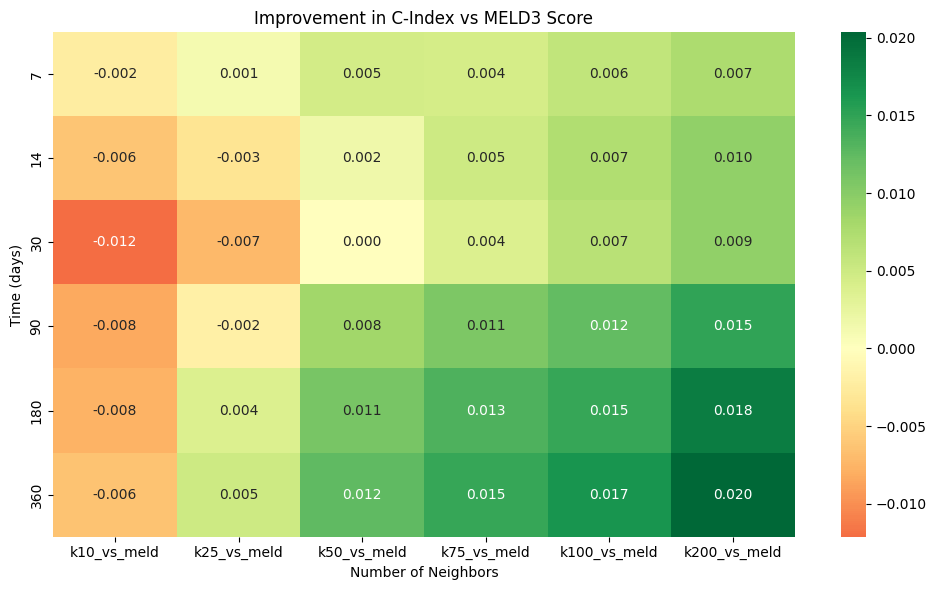


Optimal Number of Neighbors for Each Time Point:
             best_k  best_c_index  meld3_c_index  improvement
Time (days)                                                  
7             200.0         0.901          0.894        0.007
14            200.0         0.883          0.874        0.010
30            200.0         0.869          0.859        0.009
90            200.0         0.839          0.824        0.015
180           200.0         0.822          0.803        0.018
360           200.0         0.804          0.784        0.020


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define time points for analysis
time_points = [7, 14, 30, 90, 180, 360]
neighbor_sizes = [10, 25, 50, 75, 100, 200]

# Function to prepare survival data
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.
    """
    analysis_df = df.copy()
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Compare concordance indices for different numbers of neighbors
def compare_neighbor_concordance(real_df):
    # Use 'meld3' directly instead of searching
    meld_col = 'meld3'

    if meld_col not in real_df.columns:
        raise ValueError(f"'{meld_col}' column not found in the dataframe")

    print(f"Using {meld_col} as the MELD score column")

    # Dictionary to store all results
    all_results = {}

    # Run analysis for each time point
    for t in time_points:
        print(f"Analyzing time point: {t} days")
        # Prepare survival data for the current time point
        analysis_df = prepare_survival_data(real_df, max_time=t)

        time_results = {}

        # Get c-index for MELD (baseline)
        cph_meld = CoxPHFitter()
        data_meld = analysis_df[['tte', 'death_event', meld_col]].copy()
        cph_meld.fit(data_meld, duration_col='tte', event_col='death_event', show_progress=False)
        time_results['meld'] = cph_meld.concordance_index_

        # Get c-index for each neighbor size
        for k in neighbor_sizes:
            col_name = f'predicted_death_tte_k{k}'
            if col_name not in analysis_df.columns:
                print(f"Warning: Column {col_name} not found, skipping")
                continue

            # Model using predictions from k neighbors
            cph_k = CoxPHFitter()
            data_k = analysis_df[['tte', 'death_event', col_name]].copy()
            cph_k.fit(data_k, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}'] = cph_k.concordance_index_

            # Combined model (predictions + MELD)
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event', col_name, meld_col]].copy()
            cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
            time_results[f'k{k}+meld'] = cph_combined.concordance_index_

        all_results[t] = time_results

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(all_results).T
    results_df.index.name = 'Time'
    results_df.reset_index(inplace=True)

    return results_df

# Run the comparison and create visualizations
try:
    # Run the comparison analysis
    concordance_results = compare_neighbor_concordance(real_df)

    # Print tabular results
    print("\nConcordance Indices by Time Point and Neighbor Count:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(concordance_results.round(3))

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # Plot 1: C-index vs time for different neighbor counts
    ax1 = axes[0]
    for k in neighbor_sizes:
        if f'k{k}' in concordance_results.columns:
            ax1.plot(concordance_results['Time'], concordance_results[f'k{k}'], marker='o', label=f'k={k}')
    ax1.plot(concordance_results['Time'], concordance_results['meld'], marker='o', linestyle='--', color='black', label='MELD3')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Concordance Index')
    ax1.set_title('C-Index vs. Time for Different Neighbor Counts')
    ax1.grid(alpha=0.3)
    ax1.legend()

    # Plot 2: C-index vs neighbor count for different time points
    ax2 = axes[1]
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = []
        ks = []
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values.append(row[f'k{k}'].iloc[0])
                ks.append(k)
        if k_values:
            ax2.plot(ks, k_values, marker='o', label=f'{t} days')

    # Add MELD reference lines
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        meld_value = row['meld'].iloc[0]
        ax2.axhline(y=meld_value, linestyle='--', alpha=0.3, color='gray')
        ax2.text(max(neighbor_sizes) + 5, meld_value, f'MELD3 ({t} days)', fontsize=8, va='center')

    ax2.set_xlabel('Number of Neighbors (k)')
    ax2.set_ylabel('Concordance Index')
    ax2.set_title('C-Index vs. Number of Neighbors for Different Time Points')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('c_index_comparison.png', dpi=300)
    plt.show()

    # Create heatmap of improvement over MELD3
    improvement_df = concordance_results.copy()
    for k in neighbor_sizes:
        if f'k{k}' in improvement_df.columns:
            improvement_df[f'k{k}_vs_meld'] = improvement_df[f'k{k}'] - improvement_df['meld']

    # Select improvement columns for heatmap
    heatmap_cols = [f'k{k}_vs_meld' for k in neighbor_sizes if f'k{k}_vs_meld' in improvement_df.columns]
    if heatmap_cols:
        heatmap_data = improvement_df[['Time'] + heatmap_cols]
        heatmap_data = heatmap_data.set_index('Time')

        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
        plt.title('Improvement in C-Index vs MELD3 Score')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Time (days)')
        plt.tight_layout()
        plt.savefig('c_index_improvement_heatmap.png', dpi=300)
        plt.show()

    # Find optimal number of neighbors for each time point
    optimal_neighbors = {}
    for t in time_points:
        row = concordance_results[concordance_results['Time'] == t]
        k_values = {}
        for k in neighbor_sizes:
            if f'k{k}' in row.columns and not pd.isna(row[f'k{k}'].iloc[0]):
                k_values[k] = row[f'k{k}'].iloc[0]

        if k_values:
            best_k = max(k_values, key=k_values.get)
            best_c = k_values[best_k]
            meld_c = row['meld'].iloc[0]
            optimal_neighbors[t] = {
                'best_k': best_k,
                'best_c_index': best_c,
                'meld3_c_index': meld_c,
                'improvement': best_c - meld_c
            }

    print("\nOptimal Number of Neighbors for Each Time Point:")
    optimal_df = pd.DataFrame(optimal_neighbors).T
    optimal_df.index.name = 'Time (days)'
    print(optimal_df.round(3))

except Exception as e:
    print(f"Error during analysis: {str(e)}")
    import traceback
    traceback.print_exc()

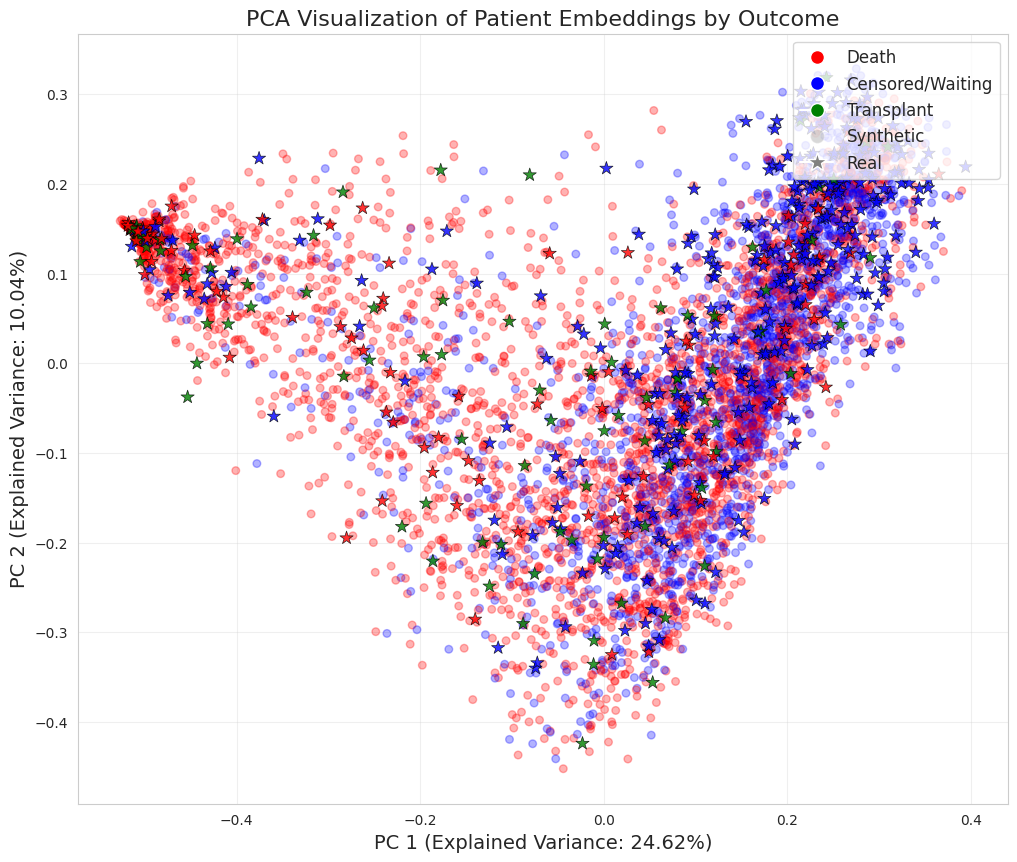

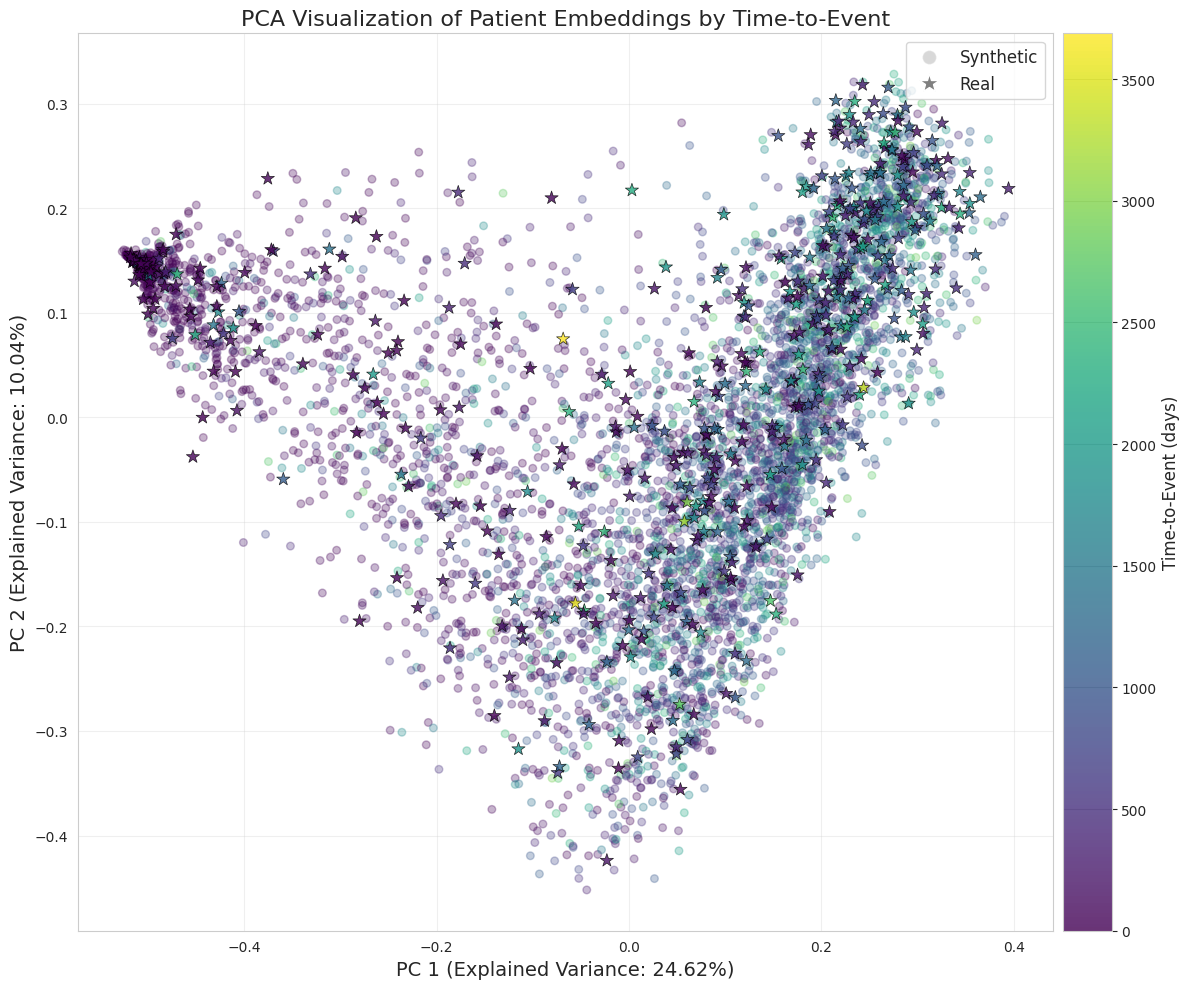

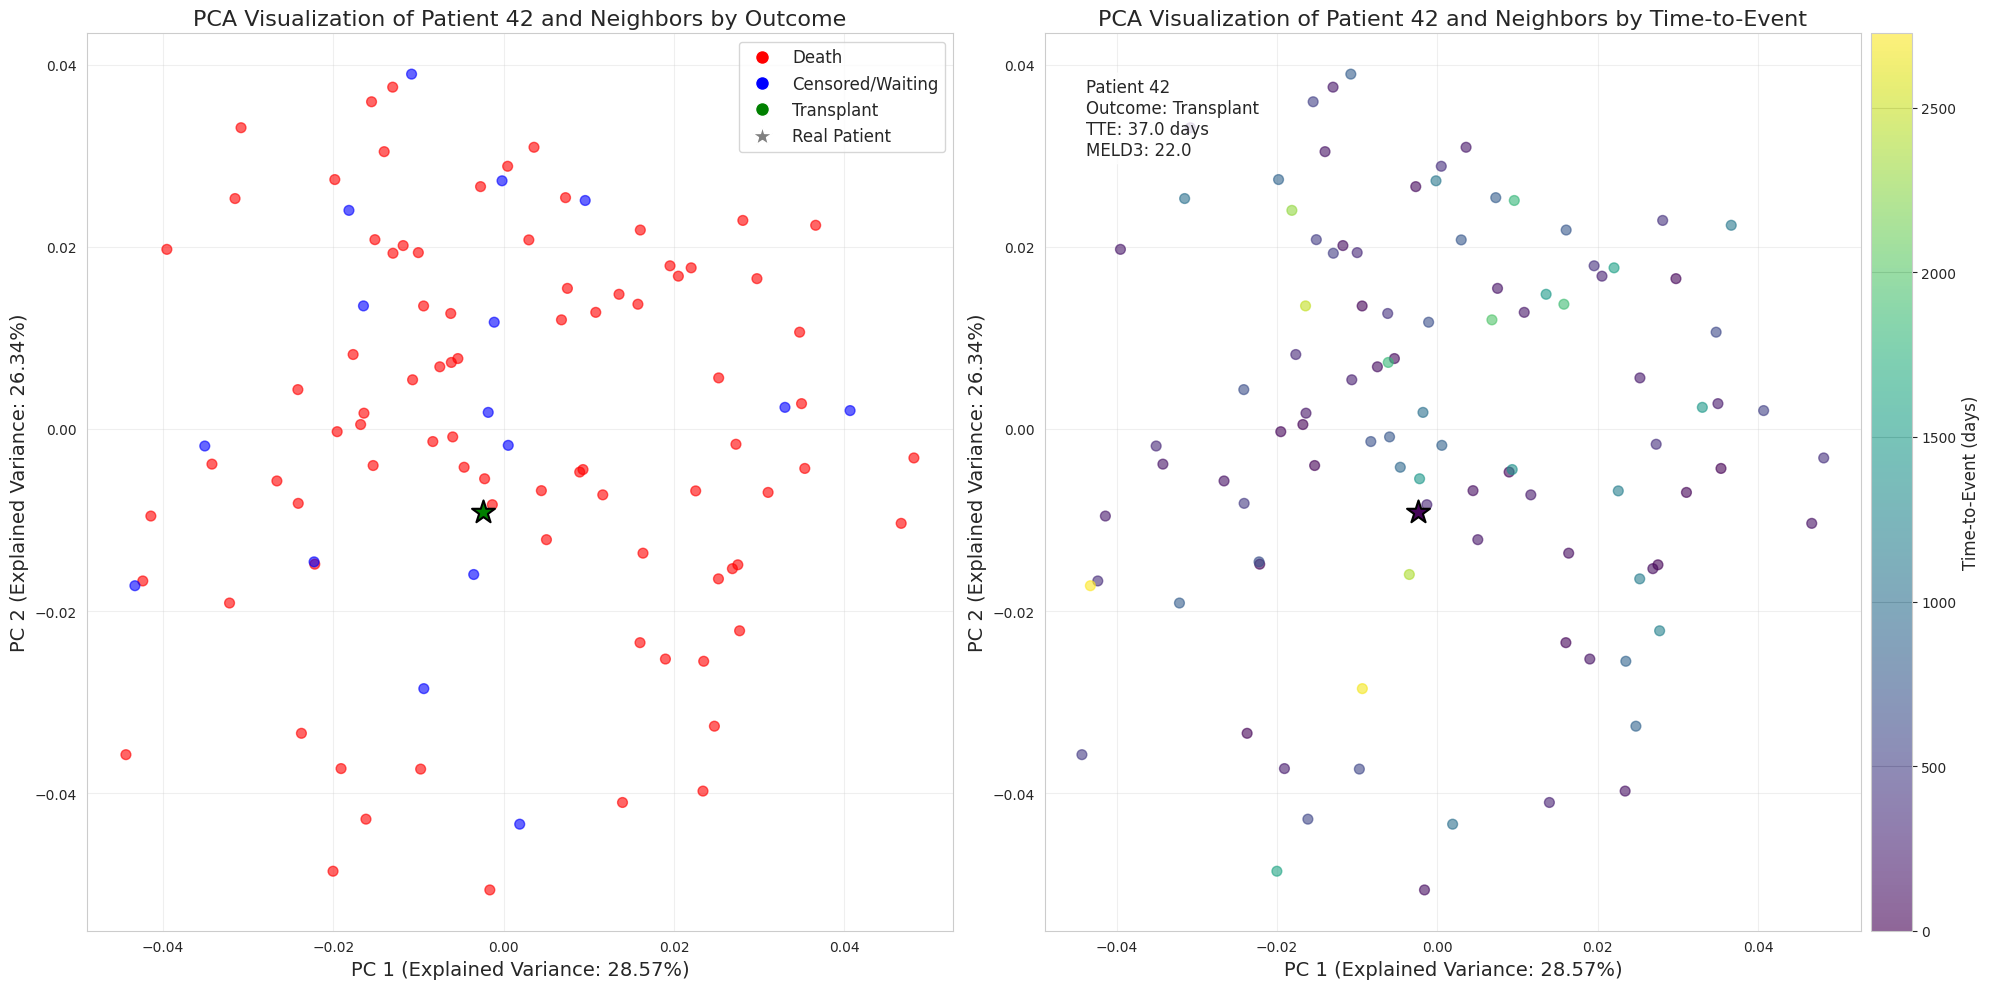

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_embeddings_with_pca(syn_embeddings, real_embeddings, syn_df, real_df,
                                  indices_all, max_samples=5000, random_state=42):
    """
    Generate PCA visualizations of embedding space showing distributions of patients
    by outcome and time-to-event.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    max_samples : int
        Maximum number of samples to use for visualization
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    fig1, fig2 : matplotlib figures
        Figures with the PCA visualizations
    """
    np.random.seed(random_state)

    # Sample synthetic patients if dataset is too large
    if len(syn_embeddings) > max_samples:
        syn_indices = np.random.choice(len(syn_embeddings), max_samples, replace=False)
        syn_embed_subset = syn_embeddings[syn_indices]
        syn_outcomes = syn_df.iloc[syn_indices]['outcome'].values
        syn_tte = syn_df.iloc[syn_indices]['tte'].values
    else:
        syn_embed_subset = syn_embeddings
        syn_outcomes = syn_df['outcome'].values
        syn_tte = syn_df['tte'].values

    # Sample real patients
    real_samples = min(len(real_embeddings), max_samples // 10)  # Use fewer real samples for clarity
    real_indices = np.random.choice(len(real_embeddings), real_samples, replace=False)
    real_embed_subset = real_embeddings[real_indices]
    real_outcomes = real_df.iloc[real_indices]['outcome'].values
    real_tte = real_df.iloc[real_indices]['tte'].values

    # Combine synthetic and real data for PCA
    combined_embeddings = np.vstack([syn_embed_subset, real_embed_subset])

    # Apply PCA
    pca = PCA(n_components=2)
    combined_2d = pca.fit_transform(combined_embeddings)

    # Split back into synthetic and real
    syn_2d = combined_2d[:len(syn_embed_subset)]
    real_2d = combined_2d[len(syn_embed_subset):]

    # Create outcome color mapping
    outcome_colors = {
        0: 'red',      # Death
        1: 'blue',     # Censored/Waiting
        2: 'green'     # Transplant
    }

    # Map outcomes to colors
    syn_colors = [outcome_colors[o] for o in syn_outcomes]
    real_colors = [outcome_colors[o] for o in real_outcomes]

    # Create figure for outcome visualization
    fig1, ax1 = plt.subplots(figsize=(12, 10))

    # Plot synthetic patients
    scatter_syn = ax1.scatter(
        syn_2d[:, 0], syn_2d[:, 1],
        c=syn_colors,
        marker='o',
        alpha=0.3,
        s=30,
        label='Synthetic'
    )

    # Plot real patients
    scatter_real = ax1.scatter(
        real_2d[:, 0], real_2d[:, 1],
        c=real_colors,
        marker='*',
        alpha=0.8,
        s=100,
        edgecolors='black',
        linewidths=0.5,
        label='Real'
    )

    # Create a legend for outcome colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Death'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Censored/Waiting'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Transplant'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, alpha=0.3, label='Synthetic'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real')
    ]

    ax1.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax1.set_title('PCA Visualization of Patient Embeddings by Outcome', fontsize=16)
    ax1.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax1.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Create figure for time-to-event visualization
    fig2, ax2 = plt.subplots(figsize=(12, 10))

    # Create color map for TTE
    max_tte = max(np.max(syn_tte), np.max(real_tte))
    norm = plt.Normalize(0, max_tte)

    # Plot synthetic patients with color based on TTE
    scatter_syn_tte = ax2.scatter(
        syn_2d[:, 0], syn_2d[:, 1],
        c=syn_tte,
        cmap='viridis',
        norm=norm,
        marker='o',
        alpha=0.3,
        s=30,
        label='Synthetic'
    )

    # Plot real patients with color based on TTE
    scatter_real_tte = ax2.scatter(
        real_2d[:, 0], real_2d[:, 1],
        c=real_tte,
        cmap='viridis',
        norm=norm,
        marker='*',
        alpha=0.8,
        s=100,
        edgecolors='black',
        linewidths=0.5,
        label='Real'
    )

    # Add colorbar for TTE
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter_real_tte, cax=cax)
    cbar.set_label('Time-to-Event (days)', fontsize=12)

    # Create a legend for synthetic vs real
    legend_elements_tte = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, alpha=0.3, label='Synthetic'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real')
    ]

    ax2.legend(handles=legend_elements_tte, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax2.set_title('PCA Visualization of Patient Embeddings by Time-to-Event', fontsize=16)
    ax2.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax2.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig1, fig2

def visualize_neighbor_embeddings(syn_embeddings, real_embeddings, syn_df, real_df,
                                 indices_all, patient_idx, n_neighbors=100):
    """
    Generate PCA visualization showing a specific real patient and their synthetic neighbors.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to visualize

    Returns:
    --------
    fig : matplotlib figure
        Figure with the PCA visualization
    """
    # Get the real patient's embedding and data
    real_patient_embed = real_embeddings[patient_idx].reshape(1, -1)
    real_patient_outcome = real_df.iloc[patient_idx]['outcome']
    real_patient_tte = real_df.iloc[patient_idx]['tte']

    # Get neighbor indices for this patient and their embeddings
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_embeddings = syn_embeddings[neighbor_indices]

    # Get neighbor outcomes and tte
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values

    # Combine embeddings for PCA
    combined_embeddings = np.vstack([real_patient_embed, neighbor_embeddings])

    # Apply PCA
    pca = PCA(n_components=2)
    combined_2d = pca.fit_transform(combined_embeddings)

    # Split back into real patient and neighbors
    real_patient_2d = combined_2d[0]
    neighbor_2d = combined_2d[1:]

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Outcome visualization (left plot)
    # Create outcome color mapping
    outcome_colors = {
        0: 'red',      # Death
        1: 'blue',     # Censored/Waiting
        2: 'green'     # Transplant
    }

    # Map outcomes to colors
    neighbor_colors = [outcome_colors[o] for o in neighbor_outcomes]

    # Plot neighbors by outcome
    scatter_neighbors = ax1.scatter(
        neighbor_2d[:, 0], neighbor_2d[:, 1],
        c=neighbor_colors,
        marker='o',
        alpha=0.6,
        s=50
    )

    # Plot the real patient
    ax1.scatter(
        real_patient_2d[0], real_patient_2d[1],
        c=outcome_colors[real_patient_outcome],
        marker='*',
        s=300,
        edgecolors='black',
        linewidths=1.5,
        label='Real Patient'
    )

    # Create a legend for outcome colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Death'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Censored/Waiting'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Transplant'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Real Patient')
    ]

    ax1.legend(handles=legend_elements, loc='upper right', fontsize=12)

    # Customize plot appearance
    ax1.set_title(f'PCA Visualization of Patient {patient_idx} and Neighbors by Outcome', fontsize=16)
    ax1.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax1.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Time-to-event visualization (right plot)
    # Create color map for TTE
    max_tte = max(np.max(neighbor_tte), real_patient_tte)
    norm = plt.Normalize(0, max_tte)

    # Plot neighbors with color based on TTE
    scatter_neighbors_tte = ax2.scatter(
        neighbor_2d[:, 0], neighbor_2d[:, 1],
        c=neighbor_tte,
        cmap='viridis',
        norm=norm,
        marker='o',
        alpha=0.6,
        s=50
    )

    # Plot the real patient with color based on TTE
    scatter_real_tte = ax2.scatter(
        real_patient_2d[0], real_patient_2d[1],
        c=real_patient_tte,
        cmap='viridis',
        norm=norm,
        marker='*',
        s=300,
        edgecolors='black',
        linewidths=1.5
    )

    # Add colorbar for TTE
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter_neighbors_tte, cax=cax)
    cbar.set_label('Time-to-Event (days)', fontsize=12)

    # Add text with patient information
    patient_info = (
        f"Patient {patient_idx}\n"
        f"Outcome: {['Death', 'Censored/Waiting', 'Transplant'][real_patient_outcome]}\n"
        f"TTE: {real_patient_tte:.1f} days\n"
        f"MELD3: {real_df.iloc[patient_idx]['meld3']:.1f}"
    )

    ax2.text(0.05, 0.95, patient_info, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Customize plot appearance
    ax2.set_title(f'PCA Visualization of Patient {patient_idx} and Neighbors by Time-to-Event', fontsize=16)
    ax2.set_xlabel(f'PC 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=14)
    ax2.set_ylabel(f'PC 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    return fig

# Example usage:
# 1. To generate global PCA visualizations:
fig1, fig2 = visualize_embeddings_with_pca(syn_embeddings, real_embeddings, syn_df_processed, real_df, indices_all)
fig1.savefig('pca_by_outcome.png', dpi=300, bbox_inches='tight')
fig2.savefig('pca_by_tte.png', dpi=300, bbox_inches='tight')

# 2. To visualize a specific patient and their neighbors:
patient_idx = 42  # Replace with a specific patient index
fig3 = visualize_neighbor_embeddings(syn_embeddings, real_embeddings, syn_df_processed, real_df, indices_all, patient_idx)
fig3.savefig(f'patient_{patient_idx}_neighbors.png', dpi=300, bbox_inches='tight')

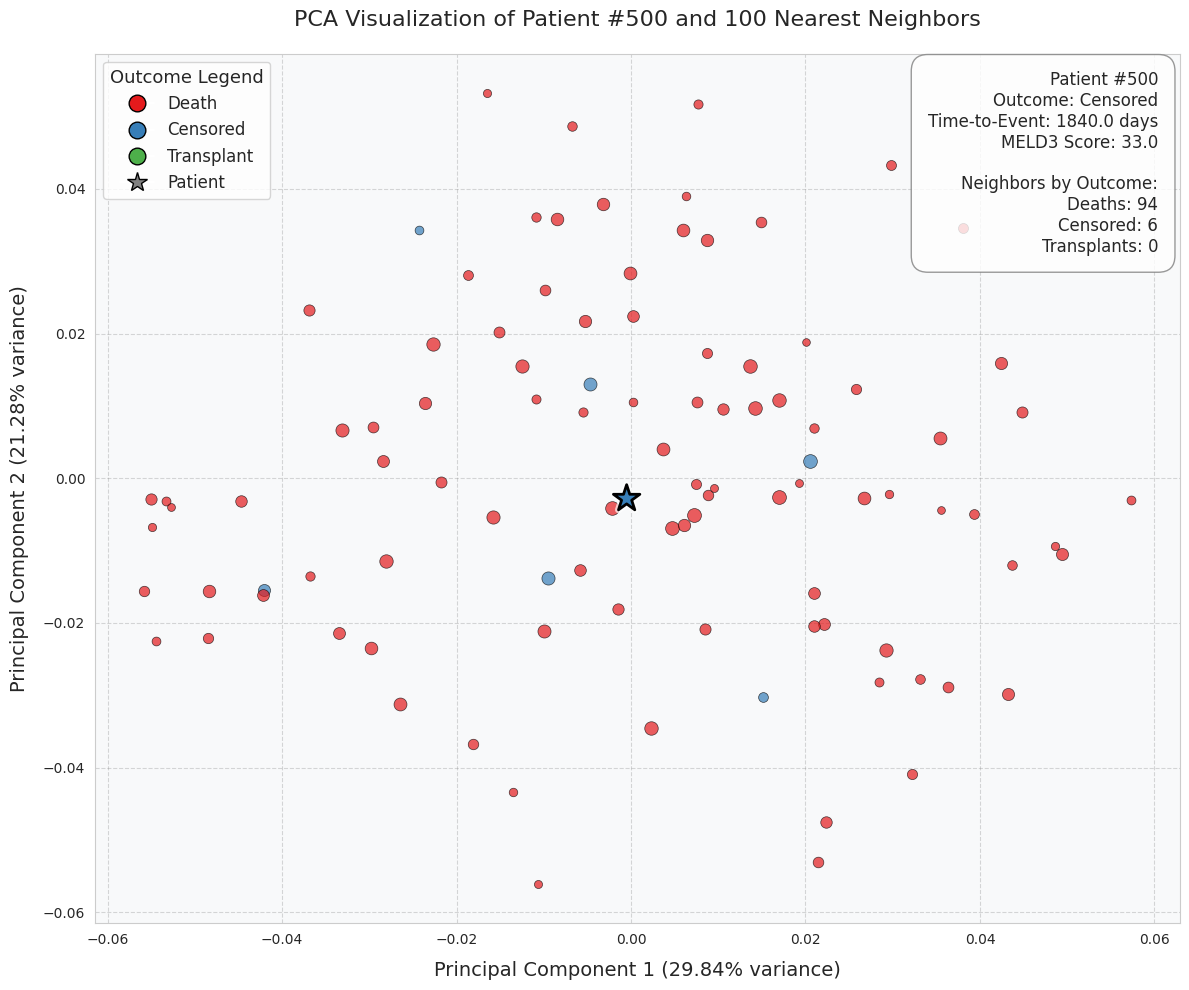

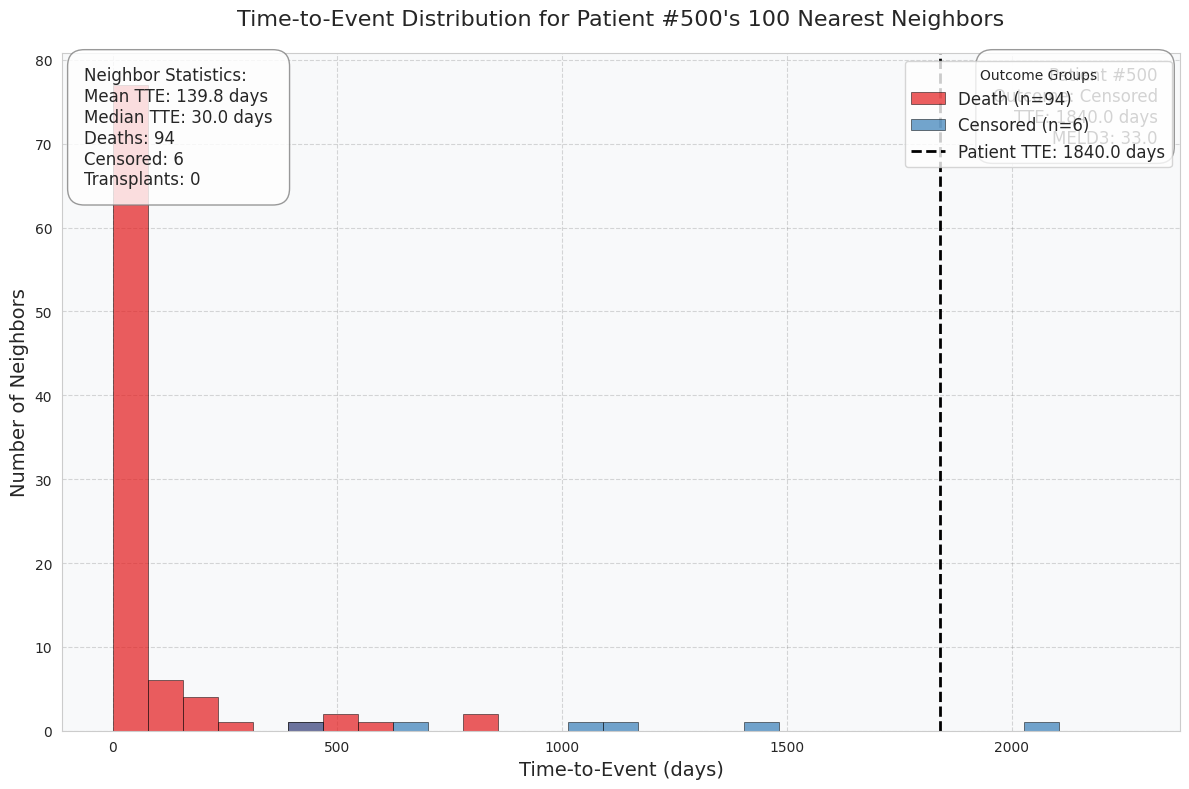

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patheffects as PathEffects
from matplotlib.lines import Line2D

def create_simple_pca_visualization(syn_embeddings, real_embeddings, syn_df, real_df,
                                  indices_all, patient_idx=157, n_neighbors=100):
    """
    Create a simplified PCA visualization of a patient and their neighbors.

    Parameters:
    -----------
    syn_embeddings : numpy array
        Embeddings of synthetic patients
    real_embeddings : numpy array
        Embeddings of real patients
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to include in the visualization

    Returns:
    --------
    fig : matplotlib figure
        Figure with the simplified PCA visualization
    """
    # 1. Get patient data
    patient_embed = real_embeddings[patient_idx].reshape(1, -1)
    patient_tte = real_df.iloc[patient_idx]['tte']
    patient_outcome = real_df.iloc[patient_idx]['outcome']
    patient_meld = real_df.iloc[patient_idx]['meld3']

    # 2. Get the neighbors
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_embeds = syn_embeddings[neighbor_indices]
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values

    # 3. Combine all embeddings for PCA
    all_embeds = np.vstack([neighbor_embeds, patient_embed])

    # 4. Apply PCA
    pca = PCA(n_components=2)
    all_2d = pca.fit_transform(all_embeds)

    # 5. Split back to respective groups
    neighbor_2d = all_2d[:-1]
    patient_2d = all_2d[-1]

    # 6. Create figure with custom design
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

    # 7. Define colors for outcomes
    outcome_colors = {
        0: '#e41a1c',  # Death (red)
        1: '#377eb8',  # Censored (blue)
        2: '#4daf4a'   # Transplant (green)
    }

    # 8. Plot neighbors with color based on outcome and size based on TTE
    for i, (x, y) in enumerate(neighbor_2d):
        outcome = neighbor_outcomes[i]
        tte_val = neighbor_tte[i]
        color = outcome_colors[outcome]

        # Make points smaller as TTE increases
        size = 100 * (1 - 0.7 * (i / n_neighbors))  # Size decreases with neighbor rank

        ax.scatter(
            x, y,
            color=color,
            s=size,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )

    # 9. Plot the patient with emphasis
    patient_point = ax.scatter(
        patient_2d[0], patient_2d[1],
        marker='*',
        c=outcome_colors[patient_outcome],
        s=400,
        alpha=1.0,
        edgecolors='black',
        linewidths=2,
        zorder=100  # Ensure patient is on top
    )

    # Add a glowing effect to patient point
    patient_point.set_path_effects([
        PathEffects.withStroke(linewidth=5, foreground='white', alpha=0.7)
    ])

    # 10. Add information box
    outcome_labels = {0: 'Death', 1: 'Censored', 2: 'Transplant'}
    info_text = (
        f"Patient #{patient_idx}\n"
        f"Outcome: {outcome_labels[patient_outcome]}\n"
        f"Time-to-Event: {patient_tte:.1f} days\n"
        f"MELD3 Score: {patient_meld:.1f}\n\n"
        f"Neighbors by Outcome:\n"
        f"Deaths: {np.sum(neighbor_outcomes == 0)}\n"
        f"Censored: {np.sum(neighbor_outcomes == 1)}\n"
        f"Transplants: {np.sum(neighbor_outcomes == 2)}"
    )

    # Add annotation box
    ax.text(
        0.98, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # 11. Create legend for outcome colors
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[0],
               markersize=12, label='Death', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[1],
               markersize=12, label='Censored', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=outcome_colors[2],
               markersize=12, label='Transplant', markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray',
               markersize=15, label='Patient', markeredgecolor='black')
    ]

    ax.legend(
        handles=legend_elements,
        loc='upper left',
        fontsize=12,
        framealpha=0.8,
        title="Outcome Legend",
        title_fontsize=13
    )

    # 12. Customize axis
    ax.set_title(f"PCA Visualization of Patient #{patient_idx} and {n_neighbors} Nearest Neighbors",
                fontsize=16, pad=20)
    ax.set_xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)",
                fontsize=14, labelpad=10)
    ax.set_ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)",
                fontsize=14, labelpad=10)

    # Add grid for readability
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')

    # Set background color
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout()

    return fig


def create_neighbor_tte_histogram(syn_df, real_df, indices_all, patient_idx=157, n_neighbors=100):
    """
    Create a histogram showing the distribution of TTE values among neighbors.

    Parameters:
    -----------
    syn_df : pandas DataFrame
        DataFrame containing synthetic patient data
    real_df : pandas DataFrame
        DataFrame containing real patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    patient_idx : int
        Index of the real patient to visualize
    n_neighbors : int
        Number of neighbors to include in the visualization

    Returns:
    --------
    fig : matplotlib figure
        Figure with the TTE histogram
    """
    # Get patient data
    patient_tte = real_df.iloc[patient_idx]['tte']
    patient_outcome = real_df.iloc[patient_idx]['outcome']
    patient_meld = real_df.iloc[patient_idx]['meld3']

    # Get neighbor data
    neighbor_indices = indices_all[patient_idx][:n_neighbors]
    neighbor_tte = syn_df.iloc[neighbor_indices]['tte'].values
    neighbor_outcomes = syn_df.iloc[neighbor_indices]['outcome'].values

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

    # Define outcome colors
    outcome_colors = {
        0: '#e41a1c',  # Death (red)
        1: '#377eb8',  # Censored (blue)
        2: '#4daf4a'   # Transplant (green)
    }

    # Create histogram by outcome
    outcome_labels = {0: 'Death', 1: 'Censored', 2: 'Transplant'}
    bins = np.linspace(0, max(np.max(neighbor_tte), patient_tte) * 1.1, 30)

    for outcome, color in outcome_colors.items():
        mask = neighbor_outcomes == outcome
        if np.sum(mask) > 0:
            ax.hist(
                neighbor_tte[mask],
                bins=bins,
                alpha=0.7,
                color=color,
                label=f"{outcome_labels[outcome]} (n={np.sum(mask)})",
                edgecolor='black',
                linewidth=0.5
            )

    # Add vertical line for patient's TTE
    ax.axvline(
        x=patient_tte,
        color='black',
        linestyle='--',
        linewidth=2,
        label=f"Patient TTE: {patient_tte:.1f} days"
    )

    # Add patient information box
    info_text = (
        f"Patient #{patient_idx}\n"
        f"Outcome: {outcome_labels[patient_outcome]}\n"
        f"TTE: {patient_tte:.1f} days\n"
        f"MELD3: {patient_meld:.1f}"
    )

    ax.text(
        0.98, 0.98, info_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # Calculate and add summary statistics
    mean_tte = np.mean(neighbor_tte)
    median_tte = np.median(neighbor_tte)
    stats_text = (
        f"Neighbor Statistics:\n"
        f"Mean TTE: {mean_tte:.1f} days\n"
        f"Median TTE: {median_tte:.1f} days\n"
        f"Deaths: {np.sum(neighbor_outcomes == 0)}\n"
        f"Censored: {np.sum(neighbor_outcomes == 1)}\n"
        f"Transplants: {np.sum(neighbor_outcomes == 2)}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(
            boxstyle='round,pad=1',
            facecolor='white',
            alpha=0.8,
            edgecolor='gray'
        )
    )

    # Add title and labels
    ax.set_title(f"Time-to-Event Distribution for Patient #{patient_idx}'s {n_neighbors} Nearest Neighbors",
                fontsize=16, pad=20)
    ax.set_xlabel("Time-to-Event (days)", fontsize=14)
    ax.set_ylabel("Number of Neighbors", fontsize=14)

    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--', color='gray')
    ax.legend(fontsize=12, title="Outcome Groups", loc='upper right')

    # Set background color
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout()

    return fig


# Example usage:
patient_idx = 500  # Choose a patient index
fig1 = create_simple_pca_visualization(
    syn_embeddings, real_embeddings, syn_df_processed, real_df,
    indices_all, patient_idx=patient_idx
)
fig1.savefig(f'pca_patient_{patient_idx}.png', dpi=300, bbox_inches='tight')

# Create the histogram
fig2 = create_neighbor_tte_histogram(
    syn_df_processed, real_df, indices_all, patient_idx=patient_idx
)
fig2.savefig(f'histogram_patient_{patient_idx}.png', dpi=300, bbox_inches='tight')

In [ ]:
# Calculate absolute difference between predicted and actual TTE
def find_close_tte_matches(real_df, syn_df_processed, indices_all, n_patients=5):
    """
    Find patients where predicted TTE closely matches actual TTE

    Parameters:
    -----------
    real_df : pandas DataFrame
        DataFrame with real patient data
    syn_df_processed : pandas DataFrame
        DataFrame with synthetic patient data
    indices_all : numpy array
        Indices of synthetic neighbors for each real patient
    n_patients : int
        Number of close matches to find

    Returns:
    --------
    close_matches : list
        Indices of patients with close TTE matches
    """
    # Calculate predicted TTE for each patient (median of neighbors)
    predicted_ttes = []
    for i in range(len(real_df)):
        neighbor_indices = indices_all[i][:100]  # Use top 100 neighbors
        neighbor_tte = syn_df_processed.iloc[neighbor_indices]['tte'].values
        predicted_tte = np.median(neighbor_tte)
        predicted_ttes.append(predicted_tte)

    # Add predicted TTE to dataframe
    real_df_copy = real_df.copy()
    real_df_copy['predicted_tte'] = predicted_ttes

    # Calculate absolute difference
    real_df_copy['tte_diff'] = abs(real_df_copy['tte'] - real_df_copy['predicted_tte'])

    # Find patients with smallest difference (filter to those who died for better comparison)
    # If you want to consider all outcomes, remove the outcome filter
    died_patients = real_df_copy[real_df_copy['outcome'] == 0]
    closest_matches = died_patients.nsmallest(n_patients, 'tte_diff')

    # Return indices of closest matches
    return closest_matches.index.tolist(), closest_matches

In [ ]:
# Find 5 patients with closest match between predicted and actual TTE
match_indices, match_df = find_close_tte_matches(real_df, syn_df_processed, indices_all)

print("Patients with closest match between predicted and actual TTE:")
for idx in match_indices:
    patient_tte = real_df.loc[idx, 'tte']
    predicted_tte = match_df.loc[idx, 'predicted_tte']
    diff = match_df.loc[idx, 'tte_diff']
    outcome = "Death" if real_df.loc[idx, 'outcome'] == 0 else ("Censored" if real_df.loc[idx, 'outcome'] == 1 else "Transplant")

    print(f"Patient #{idx}: Actual TTE = {patient_tte:.1f} days, Predicted TTE = {predicted_tte:.1f} days")
    print(f"   Difference: {diff:.1f} days, Outcome: {outcome}")
    print(f"   MELD3 Score: {real_df.loc[idx, 'meld3']:.1f}")
    print()

Patients with closest match between predicted and actual TTE:
Patient #2378: Actual TTE = 7.0 days, Predicted TTE = 7.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 35.0

Patient #5034: Actual TTE = 7.0 days, Predicted TTE = 7.0 days
   Difference: 0.0 days, Outcome: Death
   MELD3 Score: 43.0

Patient #2920: Actual TTE = 25.0 days, Predicted TTE = 25.2 days
   Difference: 0.2 days, Outcome: Death
   MELD3 Score: 31.0

Patient #4781: Actual TTE = 11.0 days, Predicted TTE = 11.2 days
   Difference: 0.2 days, Outcome: Death
   MELD3 Score: 37.0

Patient #8401: Actual TTE = 78.0 days, Predicted TTE = 77.8 days
   Difference: 0.2 days, Outcome: Death
   MELD3 Score: 26.0



In [ ]:
# Create visualizations for the matched patients
for idx in match_indices:
    print(f"Generating visualizations for patient {idx}...")

    # Create PCA visualization
    fig1 = create_simple_pca_visualization(
        syn_embeddings, real_embeddings, syn_df_processed, real_df,
        indices_all, patient_idx=idx
    )

    # Create TTE histogram
    fig2 = create_neighbor_tte_histogram(
        syn_df_processed, real_df, indices_all, patient_idx=idx
    )

    # Save visualizations
    fig1.savefig(f'pca_patient_{idx}_close_match.png', dpi=300, bbox_inches='tight')
    fig2.savefig(f'histogram_patient_{idx}_close_match.png', dpi=300, bbox_inches='tight')

    # Close figures to save memory
    plt.close(fig1)
    plt.close(fig2)

Generating visualizations for patient 2378...
Generating visualizations for patient 5034...
Generating visualizations for patient 2920...
Generating visualizations for patient 4781...
Generating visualizations for patient 8401...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_score_tte_vs_meld3(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10', 'predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Calculate naive Brier scores at multiple time points for:
      - Each TTE column in tte_cols
      - MELD-3
    Compares 'death by day t' vs. predicted probability.

    Args:
        df (pd.DataFrame): Must contain:
          - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
          - tte_col (time to event)
          - each col in tte_cols for predicted TTE
          - meld_col for MELD-3
        time_points (list): Time horizons for analysis
        tte_cols (list): Column names for predicted TTEs
        meld_col (str): Column name for MELD-3
        outcome_col (str): The outcome column name
        tte_col (str): The time-to-event column name

    Returns:
        pd.DataFrame: Rows=each time t, columns= Brier scores & counts
    """
    # Copy data so we don't mutate
    df_all = df.copy()

    # We'll build a results table
    results = []

    # Precompute min/max for each TTE column (for naive 0..1 transform)
    tte_minmax = {}
    for c in tte_cols:
        valid_vals = df_all[c].dropna()
        if len(valid_vals)==0:
            raise ValueError(f"No valid predictions in {c}")
        tte_min, tte_max = valid_vals.min(), valid_vals.max()
        tte_minmax[c] = (tte_min, tte_max)

    # Also compute min/max for MELD-3
    meld_valid = df_all[meld_col].dropna()
    meld_min, meld_max = meld_valid.min(), meld_valid.max()

    for t in time_points:
        # 1) Subset: at risk => those who haven't died before t or died by t
        at_risk_mask = (
            (df_all[tte_col] >= t)
            | ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # 2) event indicator: 1 if death by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have both events and nonevents
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            # Brier score undefined if all 0 or all 1
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill with None for each TTE col
            for c in tte_cols:
                row[f'Brier_{c}'] = None
            row['Brier_meld3'] = None
            results.append(row)
            continue

        # 3) Build naive prob for MELD3
        meld_vals = df_at_risk[meld_col]
        meld_prob = (meld_vals - meld_min) / (meld_max - meld_min + 1e-12)
        # clamp to [0,1]
        meld_prob = np.clip(meld_prob, 0, 1)

        # Brier for meld
        brier_meld = brier_score_loss(event_indicator, meld_prob)

        # Fill row
        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do naive transform => probability
        for c in tte_cols:
            tte_vals = df_at_risk[c].copy()
            # min/max
            tmin, tmax = tte_minmax[c]
            denom = (tmax - tmin) if (tmax > tmin) else 1e-12

            # Prob = 1 - (tte - tmin)/denom
            # => smaller tte => bigger prob
            prob_vals = 1 - (tte_vals - tmin)/denom
            prob_vals = np.clip(prob_vals, 0, 1)

            # Brier
            brier_val = brier_score_loss(event_indicator, prob_vals)
            row[f'Brier_{c}'] = brier_val

        results.append(row)

    return pd.DataFrame(results)

# Example usage:
df_results = brier_score_tte_vs_meld3(real_df)
print(df_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10  Brier_predicted_death_tte_k25  Brier_predicted_death_tte_k50  Brier_predicted_death_tte_k75  Brier_predicted_death_tte_k100  Brier_predicted_death_tte_k200
0     7       8999            156       0.1003                         0.4063                         0.3744                         0.3745                         0.3728                          0.3738                          0.3733
1    14       8788            315       0.0941                         0.3820                         0.3503                         0.3499                         0.3479                          0.3488                          0.3482
2    30       8467            531       0.0914                         0.3514                         0.3199                         0.3184                         0.3164                          0.3169                          0.3163
3    90       7837            901       0.0998              

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

def brier_scores_with_transforms(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10','predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    Computes Brier scores at multiple time points for:
      - MELD-3 (naive scaling)
      - Each TTE column, *with 3 transforms*:
           (1) Exponential, (2) Sigmoid, (3) Linear
    For 'death=0' vs 'censor/transplant=non-death'.

    Args:
      df (pd.DataFrame): Must contain columns:
        - outcome_col (0=death, 1=censored/waiting, 2=transplant, etc.)
        - tte_col (time to event)
        - each col in tte_cols for predicted TTE
        - meld_col for MELD-3
      time_points (list of ints): Day horizons to check
      tte_cols (list of str): Names of TTE predictions
      meld_col (str): Column name for MELD-3
      outcome_col (str): Outcome column name
      tte_col (str): Time-to-event column name

    Returns:
      pd.DataFrame with rows for each time t, columns for Brier scores.
    """
    # We'll build a list of results, each row is a time t
    results = []

    # Precompute min & max for MELD-3 to do naive [0..1] scaling
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()

    # Constants for transformations
    sigmoid_scale = 30.0  # Adjust if you want a different shape
    # linear uses cutoff=2*t, defined inside loop

    for t in time_points:
        # 1) define at-risk set: those not dead before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        df_at_risk = df[at_risk_mask].copy()

        # 2) event indicator: 1 if died by day t, else 0
        event_indicator = (
            (df_at_risk[outcome_col] == 0) & (df_at_risk[tte_col] <= t)
        ).astype(int)

        # Check if we have at least 1 event and at least 1 nonevent
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(df_at_risk),
                'N_events_by_t': int(event_indicator.sum())
            }
            # Fill placeholders for meld
            row['Brier_meld3'] = None
            # Fill placeholders for each transform of TTE
            for c in tte_cols:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
            results.append(row)
            continue

        # 3) Build naive [0..1] prob for MELD
        meld_sub = df_at_risk[meld_col].copy().dropna()
        # If some rows are NaN, we must drop them from event_indicator as well
        common_index = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[common_index]
        event_sub = event_indicator.loc[common_index]

        # min-max scale
        denom_meld = (meld_max - meld_min) if (meld_max > meld_min) else 1.0
        meld_prob = (meld_sub - meld_min) / denom_meld
        meld_prob = np.clip(meld_prob, 0, 1)

        brier_meld = brier_score_loss(event_sub, meld_prob)

        row = {
            'Time': t,
            'N_at_risk': len(df_at_risk),
            'N_events_by_t': int(event_indicator.sum()),
            'Brier_meld3': brier_meld
        }

        # 4) For each TTE col, do exponential / sigmoid / linear => Brier
        for c in tte_cols:
            tte_series = df_at_risk[c].copy().dropna()
            common_idx = tte_series.index.intersection(event_indicator.index)
            tte_series = tte_series.loc[common_idx]
            evt = event_indicator.loc[common_idx]

            if len(tte_series)==0:
                row[f'Brier_{c}_exp'] = None
                row[f'Brier_{c}_sigmoid'] = None
                row[f'Brier_{c}_linear'] = None
                continue

            # (a) Exponential
            # prob = exp(-TTE / t)
            prob_exp = np.exp(-tte_series / float(t))
            prob_exp = np.clip(prob_exp, 0, 1)
            brier_exp = brier_score_loss(evt, prob_exp)

            # (b) Sigmoid
            # prob = 1/(1 + exp((TTE - t)/scale))
            prob_sig = 1.0 / (1.0 + np.exp((tte_series - float(t))/sigmoid_scale))
            prob_sig = np.clip(prob_sig, 0, 1)
            brier_sig = brier_score_loss(evt, prob_sig)

            # (c) Linear
            # cutoff=2*t => prob= max(0, 1 - TTE/cutoff)
            cutoff = 2.0 * float(t)
            prob_lin = np.maximum(0, 1 - tte_series/cutoff)
            prob_lin = np.clip(prob_lin, 0, 1)
            brier_lin = brier_score_loss(evt, prob_lin)

            row[f'Brier_{c}_exp'] = brier_exp
            row[f'Brier_{c}_sigmoid'] = brier_sig
            row[f'Brier_{c}_linear'] = brier_lin

        results.append(row)

    return pd.DataFrame(results)


# Example usage:
results_df = brier_scores_with_transforms(real_df)
print(results_df.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10_exp  Brier_predicted_death_tte_k10_sigmoid  Brier_predicted_death_tte_k10_linear  Brier_predicted_death_tte_k25_exp  Brier_predicted_death_tte_k25_sigmoid  Brier_predicted_death_tte_k25_linear  Brier_predicted_death_tte_k50_exp  Brier_predicted_death_tte_k50_sigmoid  Brier_predicted_death_tte_k50_linear  Brier_predicted_death_tte_k75_exp  Brier_predicted_death_tte_k75_sigmoid  Brier_predicted_death_tte_k75_linear  Brier_predicted_death_tte_k100_exp  Brier_predicted_death_tte_k100_sigmoid  Brier_predicted_death_tte_k100_linear  Brier_predicted_death_tte_k200_exp  Brier_predicted_death_tte_k200_sigmoid  Brier_predicted_death_tte_k200_linear
0     7       8999            156       0.1003                             0.0182                                 0.0275                                0.0211                             0.0170                                 0.0255                                0.0188     

In [ ]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

def isotonic_calibration_brier(
    df,
    time_points=[7, 14, 30, 90, 180, 360],
    tte_cols=['predicted_death_tte_k10','predicted_death_tte_k25',
              'predicted_death_tte_k50','predicted_death_tte_k75',
              'predicted_death_tte_k100','predicted_death_tte_k200'],
    meld_col='meld3',
    outcome_col='outcome',
    tte_col='tte'
):
    """
    For each horizon t, do:
      1) define event=1 if death by t, else 0
      2) subset to at-risk
      3) for each TTE col:
         - invert TTE -> ensure bigger X => bigger risk
         - fit IsotonicRegression on (X, event)
         - transform X -> iso_prob
         - compute Brier
      4) Compare to naive MELD transform (optional)

    NOTE: This fits isotonic on the same data it evaluates,
          which can be over-optimistic.
          Use train/test splits for a realistic measure.
    """
    results = []

    # Precompute min/max for MELD-3 if you want a naive [0..1] transform
    # (You could skip if you only want to do isotonic on TTE.)
    meld_vals = df[meld_col].dropna()
    meld_min, meld_max = meld_vals.min(), meld_vals.max()
    denom_meld = (meld_max - meld_min) if (meld_max>meld_min) else 1.0

    for t in time_points:
        # 1) define at-risk set
        #    keep those who have not died before t, or died by t
        at_risk_mask = (
            (df[tte_col] >= t)
            | ((df[outcome_col] == 0) & (df[tte_col] <= t))
        )
        sub_df = df[at_risk_mask].copy()

        # event=1 if died by day t
        event_indicator = (
            (sub_df[outcome_col] == 0) & (sub_df[tte_col] <= t)
        ).astype(int)

        # if all 1 or all 0 => Brier undefined
        if event_indicator.sum() == 0 or event_indicator.sum() == len(event_indicator):
            row = {
                'Time': t,
                'N_at_risk': len(sub_df),
                'N_events_by_t': int(event_indicator.sum())
            }
            # fill TTE columns with None
            for c in tte_cols:
                row[f'Brier_{c}_iso'] = None
            # optional meld
            row['Brier_meld3'] = None
            results.append(row)
            continue

        row = {
            'Time': t,
            'N_at_risk': len(sub_df),
            'N_events_by_t': int(event_indicator.sum())
        }

        # (Optional) compute naive meld brier
        meld_sub = sub_df[meld_col].dropna()
        idx_common = meld_sub.index.intersection(event_indicator.index)
        meld_sub = meld_sub.loc[idx_common]
        event_sub = event_indicator.loc[idx_common]
        meld_prob = (meld_sub - meld_min)/denom_meld
        meld_prob = np.clip(meld_prob,0,1)
        brier_meld = brier_score_loss(event_sub, meld_prob)
        row['Brier_meld3'] = brier_meld

        # 2) for each TTE col => do isotonic
        for c in tte_cols:
            tte_ser = sub_df[c].dropna()
            idx2 = tte_ser.index.intersection(event_indicator.index)
            tte_ser = tte_ser.loc[idx2]
            evt = event_indicator.loc[idx2]

            if len(tte_ser)==0:
                row[f'Brier_{c}_iso'] = None
                continue

            # We want "larger X => higher risk" for isotonic
            # but TTE is "shorter => higher risk"
            # so we can invert TTE by negative or 1/TTE
            # simplest approach: X = - TTE
            X = -tte_ser.values  # bigger => higher risk
            Y = evt.values       # 0 or 1

            # Fit isotonic on (X, Y)
            iso = IsotonicRegression(out_of_bounds='clip')
            iso.fit(X, Y)

            # Transform
            iso_probs = iso.predict(X)

            # Brier
            brier_iso = brier_score_loss(Y, iso_probs)
            row[f'Brier_{c}_iso'] = brier_iso

        results.append(row)

    return pd.DataFrame(results)


# EXAMPLE usage:
iso_results = isotonic_calibration_brier(real_df)
print(iso_results.round(4))


   Time  N_at_risk  N_events_by_t  Brier_meld3  Brier_predicted_death_tte_k10_iso  Brier_predicted_death_tte_k25_iso  Brier_predicted_death_tte_k50_iso  Brier_predicted_death_tte_k75_iso  Brier_predicted_death_tte_k100_iso  Brier_predicted_death_tte_k200_iso
0     7       8999            156       0.1003                             0.0156                             0.0155                             0.0155                             0.0154                              0.0154                              0.0153
1    14       8788            315       0.0941                             0.0294                             0.0291                             0.0290                             0.0289                              0.0289                              0.0286
2    30       8467            531       0.0914                             0.0466                             0.0460                             0.0457                             0.0457                              0.0456 

Brier Scores:
MELD3: 0.0998
Exponential: 0.0907
Sigmoid: 0.1013
Linear: 0.0991
Isotonic: 0.0769


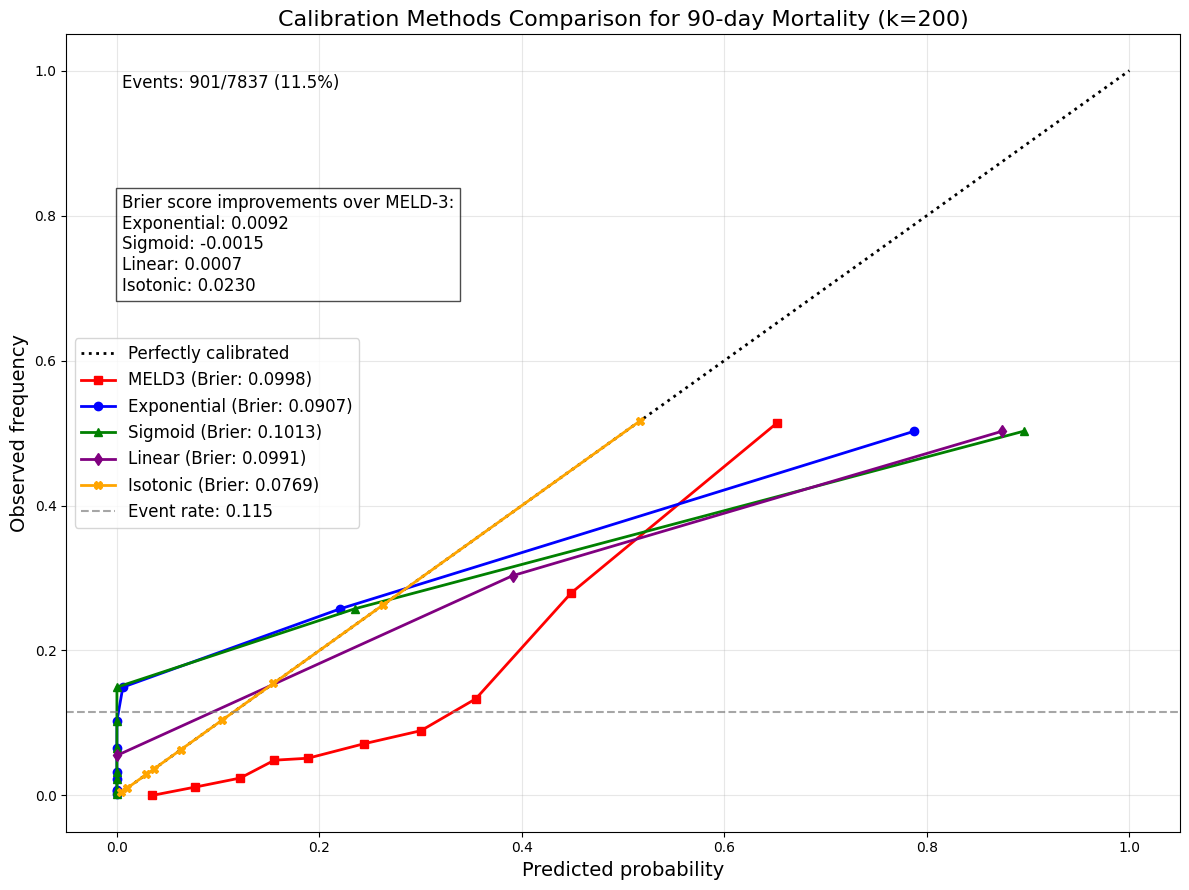

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression

def plot_calibration_methods_k200(df, timepoint=90, k=200, figsize=(12, 9), save_path=None):
    """
    Create a calibration plot that accurately reflects the Brier scores in the data table.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    figsize : tuple
        Figure size
    save_path : str, optional
        Path to save the figure

    Returns:
    --------
    matplotlib.figure.Figure
    """
    # Create binary outcome: 1 if died within timepoint days, 0 otherwise
    # Define at-risk set: those who have not died before t, or died by t
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    # Event indicator: 1 if died by day t, else 0
    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    event_rate = event_indicator.mean()

    # Get MELD3 scores as baseline
    meld_col = 'meld3'
    meld_scores = df_at_risk[meld_col].copy().dropna()

    # Match indices for common subset
    common_index = meld_scores.index.intersection(event_indicator.index)
    meld_scores = meld_scores.loc[common_index]
    event_indicator_meld = event_indicator.loc[common_index]

    # Get min/max for scaling
    meld_min, meld_max = df[meld_col].dropna().min(), df[meld_col].dropna().max()
    denom_meld = (meld_max - meld_min) if (meld_max > meld_min) else 1.0

    # Scale to [0,1]
    meld_prob = (meld_scores - meld_min) / denom_meld
    meld_prob = np.clip(meld_prob, 0, 1)
    meld_brier = brier_score_loss(event_indicator_meld, meld_prob)

    # Get prediction column for k=200
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions (non-NaN)
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # 1. Exponential transform: P(death) = exp(-TTE / timepoint)
    prob_exp = np.exp(-tte_series / float(timepoint))
    prob_exp = np.clip(prob_exp, 0, 1)
    exp_brier = brier_score_loss(evt, prob_exp)

    # 2. Sigmoid transform: P(death) = 1/(1 + exp((TTE - timepoint)/scale))
    sigmoid_scale = 30.0
    prob_sig = 1.0 / (1.0 + np.exp((tte_series - float(timepoint))/sigmoid_scale))
    prob_sig = np.clip(prob_sig, 0, 1)
    sigmoid_brier = brier_score_loss(evt, prob_sig)

    # 3. Linear transform: P(death) = max(0, 1 - TTE/cutoff)
    cutoff = 2.0 * float(timepoint)
    prob_lin = np.maximum(0, 1 - tte_series/cutoff)
    prob_lin = np.clip(prob_lin, 0, 1)
    linear_brier = brier_score_loss(evt, prob_lin)

    # 4. Isotonic transform
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Apply calibration
    prob_iso = ir.predict(X)
    iso_brier = brier_score_loss(Y, prob_iso)

    # Set up the figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the diagonal (perfect calibration)
    ax.plot([0, 1], [0, 1], "k:", linewidth=2, label="Perfectly calibrated")

    # Plot calibration curves

    # MELD3
    meld_fraction_pos, meld_mean_pred_proba = calibration_curve(
        event_indicator_meld, meld_prob, n_bins=10, strategy='quantile'
    )
    ax.plot(meld_mean_pred_proba, meld_fraction_pos, "s-", color='red', linewidth=2,
           label=f"MELD3 (Brier: {meld_brier:.4f})")

    # Exponential
    exp_fraction_pos, exp_mean_pred_proba = calibration_curve(
        evt, prob_exp, n_bins=10, strategy='quantile'
    )
    ax.plot(exp_mean_pred_proba, exp_fraction_pos, "o-", color='blue', linewidth=2,
           label=f"Exponential (Brier: {exp_brier:.4f})")

    # Sigmoid
    sigmoid_fraction_pos, sigmoid_mean_pred_proba = calibration_curve(
        evt, prob_sig, n_bins=10, strategy='quantile'
    )
    ax.plot(sigmoid_mean_pred_proba, sigmoid_fraction_pos, "^-", color='green', linewidth=2,
           label=f"Sigmoid (Brier: {sigmoid_brier:.4f})")

    # Linear
    linear_fraction_pos, linear_mean_pred_proba = calibration_curve(
        evt, prob_lin, n_bins=10, strategy='quantile'
    )
    ax.plot(linear_mean_pred_proba, linear_fraction_pos, "d-", color='purple', linewidth=2,
           label=f"Linear (Brier: {linear_brier:.4f})")

    # Isotonic
    iso_fraction_pos, iso_mean_pred_proba = calibration_curve(
        evt, prob_iso, n_bins=10, strategy='quantile'
    )
    ax.plot(iso_mean_pred_proba, iso_fraction_pos, "X-", color='orange', linewidth=2,
           label=f"Isotonic (Brier: {iso_brier:.4f})")

    # Add horizontal line at event rate
    ax.axhline(y=event_rate, color='gray', linestyle='--', alpha=0.7,
              label=f"Event rate: {event_rate:.3f}")

    # Add labels and decorations
    ax.set_xlabel("Predicted probability", fontsize=14)
    ax.set_ylabel("Observed frequency", fontsize=14)
    ax.set_title(f"Calibration Methods Comparison for {timepoint}-day Mortality (k={k})", fontsize=16)
    ax.legend(loc="best", fontsize=12)
    ax.grid(alpha=0.3)

    # Add text with event info
    event_count = evt.sum()
    total_count = len(evt)
    ax.text(0.05, 0.95, f"Events: {event_count}/{total_count} ({event_rate:.1%})",
           transform=ax.transAxes, fontsize=12, va='top')

    # Add text with improvement over MELD
    improvements_text = (
        f"Brier score improvements over MELD-3:\n"
        f"Exponential: {meld_brier - exp_brier:.4f}\n"
        f"Sigmoid: {meld_brier - sigmoid_brier:.4f}\n"
        f"Linear: {meld_brier - linear_brier:.4f}\n"
        f"Isotonic: {meld_brier - iso_brier:.4f}"
    )

    ax.text(0.05, 0.8, improvements_text, transform=ax.transAxes,
            fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.7))

    # Adjust layout
    plt.tight_layout()

    # Save if specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print("Brier Scores:")
    print(f"MELD3: {meld_brier:.4f}")
    print(f"Exponential: {exp_brier:.4f}")
    print(f"Sigmoid: {sigmoid_brier:.4f}")
    print(f"Linear: {linear_brier:.4f}")
    print(f"Isotonic: {iso_brier:.4f}")

    return fig

# Example usage:
fig = plot_calibration_methods_k200(
    real_df,
    timepoint=90,
    k=200,
    save_path='corrected_calibration_methods_comparison_k200.png'
)
plt.show()

In [ ]:
# Save the calibration plot as a high-resolution (300dpi) figure
fig = plot_calibration_methods_k200(
    real_df,
    timepoint=90,
    k=200,
    save_path='calibration_methods_k200_300dpi.png'
)

# If you want to explicitly set the DPI in the function call:
plt.savefig('calibration_methods_k200_300dpi.png', dpi=300, bbox_inches='tight')

# Close the figure to free memory (optional)
plt.close(fig)

Brier Scores:
MELD3: 0.0998
Exponential: 0.0907
Sigmoid: 0.1013
Linear: 0.0991
Isotonic: 0.0769


In [ ]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

def add_isotonic_90days_k200(df,
                             t=90,
                             tte_col='predicted_death_tte_k200',
                             outcome_col='outcome',
                             event_col_name='risk_k200_iso_90'):
    """
    Adds a new column to df: 'risk_k100_iso_90', which is the isotonic-calibrated
    probability of death by day t=90 for the TTE predictions in 'tte_col' (k=100).

    NOTE: This is an in-sample fit. For real usage, you'd do train/test splits.
    """

    # 1) Work on a copy for the subset to fit isotonic
    df_iso = df.copy()

    # Create event=1 if outcome=0 (death) AND TTE <= 90, else 0
    df_iso['death_event_90'] = ((df_iso[outcome_col] == 0) & (df_iso['tte'] <= t)).astype(int)

    # Censor: If TTE > 90 => set TTE=90 => event=0
    # (So we align with 'death by day 90' labeling)
    mask_censor = df_iso['tte'] > t
    df_iso.loc[mask_censor, 'tte'] = t
    df_iso.loc[mask_censor, 'death_event_90'] = 0

    # We only want rows that have a valid TTE prediction
    # (some might be NaN if no neighbors)
    # But we also want to keep track so we can do iso.predict(...) for them
    valid_mask = df_iso[tte_col].notna()

    # 2) For isotonic, we need "bigger X => bigger risk."
    # TTE is "shorter => bigger risk," so we invert TTE, e.g. X = - TTE.
    # However, we also want to keep the "in-sample" approach consistent:
    # We'll fit iso only on the subset of patients we have event info for.
    df_iso['X'] = -df_iso[tte_col]

    # 3) Fit isotonic on that subset
    # We'll drop rows with missing X, or missing event
    iso_fit_mask = valid_mask & df_iso['X'].notna() & df_iso['death_event_90'].notna()

    fit_X = df_iso.loc[iso_fit_mask, 'X'].values
    fit_Y = df_iso.loc[iso_fit_mask, 'death_event_90'].values

    if len(fit_X) == 0:
        print("No valid data to fit isotonic. Exiting.")
        df[event_col_name] = np.nan
        return df

    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(fit_X, fit_Y)

    # 4) Transform ALL patients with a valid TTE into an iso probability
    # (some might not be in the at-risk subset, but we can still produce a probability)
    # We'll store them in a new column in the original df

    # Initialize column to NaN
    df[event_col_name] = np.nan

    # For those with valid TTE, apply iso
    all_valid_indices = df_iso.index[valid_mask]
    X_all = df_iso.loc[all_valid_indices, 'X'].values  # the -TTE
    iso_probs_all = iso.predict(X_all)

    # Put them back into df
    df.loc[all_valid_indices, event_col_name] = iso_probs_all

    print(f"Added column '{event_col_name}' with isotonic probabilities for 90-day death.")
    return df


In [ ]:
real_df = add_isotonic_90days_k200(
    real_df,  # your dataset
    t=90,
    tte_col='predicted_death_tte_k200',
    outcome_col='outcome',
    event_col_name='risk_k200_iso_90'
)

# Now real_df has a new column 'risk_k100_iso_90' which is the
# in-sample isotonic-calibrated probability that the patient dies by day 90.


Added column 'risk_k200_iso_90' with isotonic probabilities for 90-day death.


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def c_index_90_transformed(df,
                           risk_col="risk_k200_iso_90",  # your isotonic or other transform col
                           meld_col="meld3",
                           outcome_col="outcome",
                           tte_col="tte",
                           horizon=90):
    """
    Compare Harrell's C-index at 90 days for:
      1) Transformed risk_col (bigger => higher risk),
      2) MELD-3.

    We create a 90-day subset:
     - Censor those who survive beyond 90 days at day 90
     - Event=1 if outcome=0 & tte <= 90.
    """

    data_90 = df.copy()

    # 1) Mark events (death by day 90)
    data_90['death_event'] = ((data_90[outcome_col]==0) & (data_90[tte_col] <= horizon)).astype(int)

    # 2) Censor if tte > 90
    data_90.loc[data_90[tte_col] > horizon, tte_col] = horizon
    data_90.loc[data_90[tte_col] == horizon, 'death_event'] = 0  # ensure they're censored if they survive to day 90

    # We'll do a small helper for c-index using a Cox model on each predictor:
    cph_risk = CoxPHFitter()
    sub_risk = data_90[[tte_col, 'death_event', risk_col]].dropna()
    cph_risk.fit(sub_risk, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_risk = cph_risk.concordance_index_

    cph_meld = CoxPHFitter()
    sub_meld = data_90[[tte_col, 'death_event', meld_col]].dropna()
    cph_meld.fit(sub_meld, duration_col=tte_col, event_col='death_event', show_progress=False)
    c_index_meld = cph_meld.concordance_index_

    print(f"\n--- Harrell’s C-index at {horizon} days ---")
    print(f"{risk_col}: {c_index_risk:.4f}")
    print(f"{meld_col}: {c_index_meld:.4f}")
    print(f"Difference: {(c_index_risk - c_index_meld):.4f}")

    return c_index_risk, c_index_meld
# Suppose you have real_df with columns:
#   - outcome, tte, meld3
#   - risk_k100_iso_90 (the isotonic or other transform for k=100 at 90 days)
c_risk, c_meld = c_index_90_transformed(real_df)



--- Harrell’s C-index at 90 days ---
risk_k200_iso_90: 0.8429
meld3: 0.8247
Difference: 0.0182


In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index

def direct_cindex_at_90(df,
                        risk_col="risk_k200_iso_90",
                        meld_col="meld3",
                        outcome_col="outcome",
                        tte_col="tte",
                        horizon=90):
    """
    Compute c-index at 90 days for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.
    """
    data_90 = df.copy()

    # Label event=1 if death <= 90, else 0
    data_90['event_90'] = ((data_90[outcome_col] == 0) & (data_90[tte_col] <= horizon)).astype(int)
    # times_90 = min(tte, 90)
    data_90['time_90'] = np.minimum(data_90[tte_col], horizon)

    # Drop rows missing risk or meld
    needed_cols = ['time_90','event_90', risk_col, meld_col]
    data_90 = data_90[needed_cols].dropna()
    if data_90.empty:
        raise ValueError("No valid rows after dropping missing data for direct c-index at 90.")

    # c-index for risk_col - FIXED: using negative of risk score
    c_risk = concordance_index(
        data_90['time_90'],
        -data_90[risk_col],  # Negate the risk score
        data_90['event_90']
    )
    # c-index for meld_col - FIXED: using negative of meld score
    c_meld = concordance_index(
        data_90['time_90'],
        -data_90[meld_col],  # Negate the meld score
        data_90['event_90']
    )

    return c_risk, c_meld


def bootstrap_direct_cindex_90(df,
                               risk_col="risk_k200_iso_90",
                               meld_col="meld3",
                               outcome_col="outcome",
                               tte_col="tte",
                               horizon=90,
                               n_bootstraps=500,
                               random_state=42):
    """
    Bootstrap the difference in c-index at day 90 using direct lifelines.utils.concordance_index
    (no repeated CoxPH fits).

    Return distribution of (c_risk, c_meld, diff).
    """
    np.random.seed(random_state)

    # 1) Prepare the main subset
    df_90 = df.copy()
    df_90['event_90'] = ((df_90[outcome_col]==0) & (df_90[tte_col] <= horizon)).astype(int)
    df_90['time_90'] = np.minimum(df_90[tte_col], horizon)
    needed = ['time_90','event_90', risk_col, meld_col]
    df_90 = df_90[needed].dropna()
    if df_90.empty:
        raise ValueError("No valid data after dropping NAs for direct c-index bootstrapping.")

    # 2) Full-sample c-index - FIXED: using negative of risk scores
    c_risk_full = concordance_index(df_90['time_90'], -df_90[risk_col], df_90['event_90'])
    c_meld_full = concordance_index(df_90['time_90'], -df_90[meld_col], df_90['event_90'])
    orig_diff = c_risk_full - c_meld_full

    # 3) Bootstrapping
    n = len(df_90)
    c_risk_boot = []
    c_meld_boot = []
    for _ in range(n_bootstraps):
        sample_idx = np.random.randint(0, n, size=n)
        df_boot = df_90.iloc[sample_idx]

        # c-index for risk - FIXED: using negative of risk score
        c_risk_b = concordance_index(df_boot['time_90'],
                                     -df_boot[risk_col],
                                     df_boot['event_90'])
        # c-index for meld - FIXED: using negative of meld score
        c_meld_b = concordance_index(df_boot['time_90'],
                                     -df_boot[meld_col],
                                     df_boot['event_90'])

        c_risk_boot.append(c_risk_b)
        c_meld_boot.append(c_meld_b)

    c_risk_boot = np.array(c_risk_boot)
    c_meld_boot = np.array(c_meld_boot)
    diff_boot = c_risk_boot - c_meld_boot

    # 4) Confidence intervals
    ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
    ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
    ci_diff = np.percentile(diff_boot, [2.5, 97.5])

    # 5) Two-sided p-value for diff=0
    if orig_diff >= 0:
        p_one_sided = np.mean(diff_boot < 0)
    else:
        p_one_sided = np.mean(diff_boot > 0)
    p_value = min(2 * p_one_sided, 1.0)

    # Return
    return {
        'c_risk_full': c_risk_full,
        'c_meld_full': c_meld_full,
        'orig_diff': orig_diff,
        'c_risk_boot': c_risk_boot,
        'c_meld_boot': c_meld_boot,
        'diff_boot': diff_boot,
        'ci_risk': ci_risk,
        'ci_meld': ci_meld,
        'ci_diff': ci_diff,
        'p_value': p_value
    }


def show_bootstrap_results(res):
    """
    Nicely print the bootstrap results from above function.
    """
    print("\n--- Direct Concordance Index at 90 days (Bootstrap) ---")
    print(f"risk_col c-index: {res['c_risk_full']:.4f}   (95% CI: [{res['ci_risk'][0]:.4f}, {res['ci_risk'][1]:.4f}])")
    print(f"meld_col c-index: {res['c_meld_full']:.4f}   (95% CI: [{res['ci_meld'][0]:.4f}, {res['ci_meld'][1]:.4f}])")
    print(f"Difference:       {res['orig_diff']:.4f}   (95% CI: [{res['ci_diff'][0]:.4f}, {res['ci_diff'][1]:.4f}])")
    print(f"p-value (2-sided): {res['p_value']:.4f}")

In [ ]:
# 1) Direct c-index on full data (no bootstrap)
c_risk, c_meld = direct_cindex_at_90(real_df,
                                     risk_col="risk_k200_iso_90",
                                     meld_col="meld3")

print(f"\n*** 90-day c-index ***")
print(f"risk_k200_iso_90: {c_risk:.4f}")
print(f"meld3: {c_meld:.4f}")
print(f"Difference: {c_risk - c_meld:.4f}")

# 2) Bootstrap
res = bootstrap_direct_cindex_90(real_df,
                                 risk_col="risk_k200_iso_90",
                                 meld_col="meld3",
                                 n_bootstraps=1000)

show_bootstrap_results(res)



*** 90-day c-index ***
risk_k200_iso_90: 0.8423
meld3: 0.8244
Difference: 0.0179

--- Direct Concordance Index at 90 days (Bootstrap) ---
risk_col c-index: 0.8423   (95% CI: [0.8308, 0.8527])
meld_col c-index: 0.8244   (95% CI: [0.8120, 0.8358])
Difference:       0.0179   (95% CI: [0.0124, 0.0236])
p-value (2-sided): 0.0000



*** Time-Dependent C-index Results ***
   horizon  c_risk_k200_iso_90   c_meld3  difference  n_patients  n_events
0        7            0.903448  0.894044    0.009404        9395       156
1       14            0.885583  0.873825    0.011758        9395       315
2       30            0.870803  0.859304    0.011500        9395       531
3       90            0.842295  0.824407    0.017888        9395       901
4      180            0.823499  0.803134    0.020364        9395      1170
5      360            0.805467  0.784095    0.021372        9395      1446
Bootstrapping horizon: 7 days
Bootstrapping horizon: 14 days
Bootstrapping horizon: 30 days
Bootstrapping horizon: 90 days
Bootstrapping horizon: 180 days
Bootstrapping horizon: 360 days

=== Time-Dependent Concordance Index (Bootstrap) ===


--- 7.0-day Concordance Index ---
Patients: 9395.0, Events: 156.0 (1.7% event rate)
risk_k200_iso_90 c-index: 0.9034   (95% CI: [0.8838, 0.9211])
meld3 c-index: 0.8940   (95% CI: [0.8722, 0.91

Processing with k=10:   0%|          | 0/9395 [06:46<?, ?it/s]



*** Publication-Ready Table ***
   Horizon (days)  Patients  Events Event Rate (%) risk_k200_iso_90 C-index (95% CI)  meld3 C-index (95% CI)     Difference (95% CI)    p-value
0             7.0    9395.0   156.0           1.7%            0.9034 (0.8838-0.9211)  0.8940 (0.8722-0.9142)  0.0094 (0.0014-0.0177)    0.0220*
1            14.0    9395.0   315.0           3.4%            0.8856 (0.8690-0.9010)  0.8738 (0.8548-0.8918)  0.0118 (0.0048-0.0196)   0.0020**
2            30.0    9395.0   531.0           5.7%            0.8708 (0.8581-0.8833)  0.8593 (0.8454-0.8733)  0.0115 (0.0056-0.0178)  0.0000***
3            90.0    9395.0   901.0           9.6%            0.8423 (0.8305-0.8537)  0.8244 (0.8122-0.8368)  0.0179 (0.0123-0.0231)  0.0000***
4           180.0    9395.0  1170.0          12.5%            0.8235 (0.8136-0.8335)  0.8031 (0.7911-0.8143)  0.0204 (0.0150-0.0263)  0.0000***
5           360.0    9395.0  1446.0          15.4%            0.8055 (0.7946-0.8153)  0.7841 (0.7723-0.

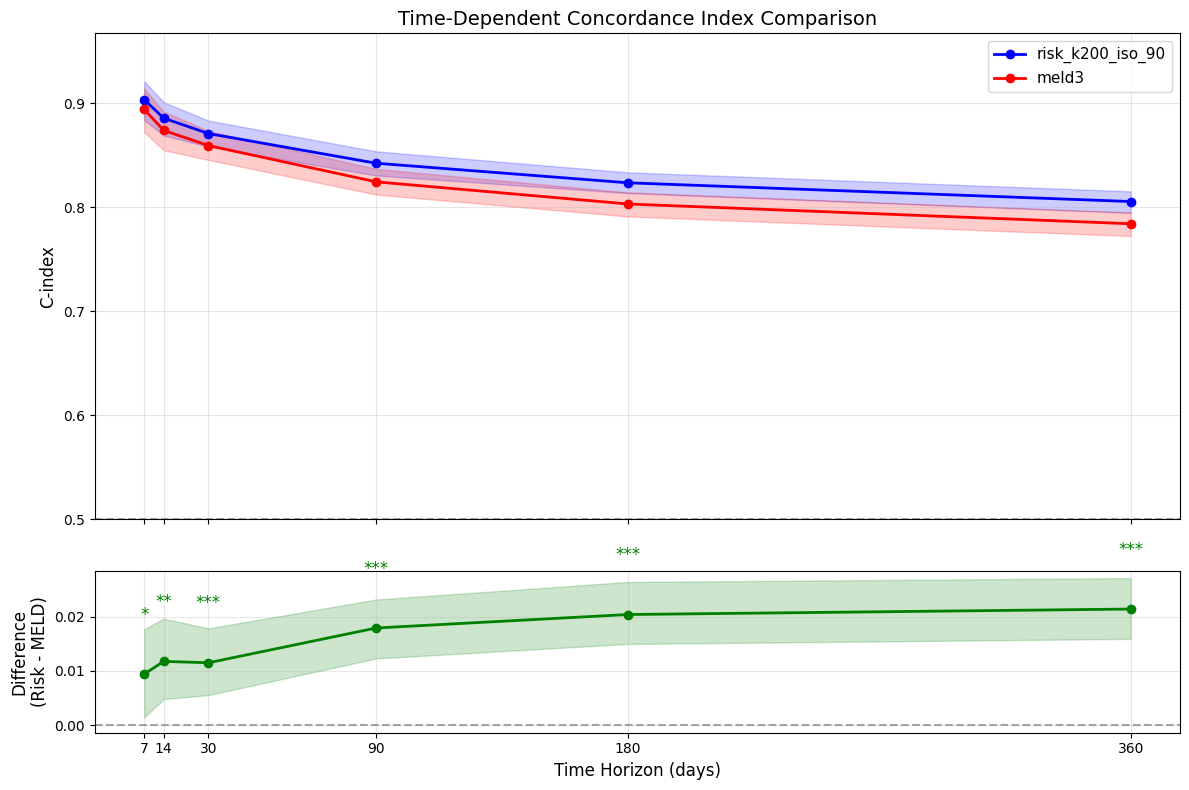

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def direct_cindex_at_horizons(df,
                             risk_col="risk_k200_iso_90",
                             meld_col="meld3",
                             outcome_col="outcome",
                             tte_col="tte",
                             horizons=[7, 14, 30, 90, 180, 360]):
    """
    Compute c-index at multiple horizons for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate

    Returns:
        DataFrame with c-index results for each horizon
    """
    results = []

    for horizon in horizons:
        data_t = df.copy()

        # Label event=1 if death <= horizon, else 0
        data_t['event_t'] = ((data_t[outcome_col] == 0) & (data_t[tte_col] <= horizon)).astype(int)
        # times_t = min(tte, horizon)
        data_t['time_t'] = np.minimum(data_t[tte_col], horizon)

        # Drop rows missing risk or meld
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        data_t = data_t[needed_cols].dropna()

        if data_t.empty:
            print(f"Warning: No valid rows after dropping missing data for horizon {horizon}.")
            c_risk = c_meld = np.nan
        else:
            # Count events for reporting
            n_patients = len(data_t)
            n_events = data_t['event_t'].sum()

            # c-index for risk_col - using negative of risk score
            c_risk = concordance_index(
                data_t['time_t'],
                -data_t[risk_col],  # Negate the risk score
                data_t['event_t']
            )
            # c-index for meld_col - using negative of meld score
            c_meld = concordance_index(
                data_t['time_t'],
                -data_t[meld_col],  # Negate the meld score
                data_t['event_t']
            )

        results.append({
            'horizon': horizon,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': c_risk - c_meld if not np.isnan(c_risk) and not np.isnan(c_meld) else np.nan,
            'n_patients': n_patients if 'n_patients' in locals() else 0,
            'n_events': n_events if 'n_events' in locals() else 0
        })

    return pd.DataFrame(results)


def bootstrap_direct_cindex_at_horizons(df,
                                      risk_col="risk_k200_iso_90",
                                      meld_col="meld3",
                                      outcome_col="outcome",
                                      tte_col="tte",
                                      horizons=[7, 14, 30, 90, 180, 360],
                                      n_bootstraps=500,
                                      random_state=42):
    """
    Bootstrap the difference in c-index at multiple horizons using direct
    lifelines.utils.concordance_index (no repeated CoxPH fits).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility

    Returns:
        DataFrame with bootstrap results for each horizon
    """
    np.random.seed(random_state)
    results = []

    for horizon in horizons:
        print(f"Bootstrapping horizon: {horizon} days")

        # 1) Prepare the main subset
        df_t = df.copy()
        df_t['event_t'] = ((df_t[outcome_col]==0) & (df_t[tte_col] <= horizon)).astype(int)
        df_t['time_t'] = np.minimum(df_t[tte_col], horizon)
        needed = ['time_t', 'event_t', risk_col, meld_col]
        df_t = df_t[needed].dropna()

        if df_t.empty:
            print(f"Warning: No valid data after dropping NAs for horizon {horizon}.")
            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': np.nan,
                f'c_{meld_col}_full': np.nan,
                'orig_diff': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan,
                'n_patients': 0,
                'n_events': 0
            }
        else:
            # 2) Full-sample c-index - using negative of risk scores
            c_risk_full = concordance_index(df_t['time_t'], -df_t[risk_col], df_t['event_t'])
            c_meld_full = concordance_index(df_t['time_t'], -df_t[meld_col], df_t['event_t'])
            orig_diff = c_risk_full - c_meld_full

            # Count patients and events
            n_patients = len(df_t)
            n_events = df_t['event_t'].sum()

            # 3) Bootstrapping
            n = len(df_t)
            c_risk_boot = []
            c_meld_boot = []

            for _ in range(n_bootstraps):
                sample_idx = np.random.randint(0, n, size=n)
                df_boot = df_t.iloc[sample_idx]

                # Skip bootstrap samples with no events or all events
                if df_boot['event_t'].sum() == 0 or df_boot['event_t'].sum() == len(df_boot):
                    continue

                # c-index for risk - using negative of risk score
                c_risk_b = concordance_index(df_boot['time_t'],
                                           -df_boot[risk_col],
                                           df_boot['event_t'])
                # c-index for meld - using negative of meld score
                c_meld_b = concordance_index(df_boot['time_t'],
                                           -df_boot[meld_col],
                                           df_boot['event_t'])

                c_risk_boot.append(c_risk_b)
                c_meld_boot.append(c_meld_b)

            c_risk_boot = np.array(c_risk_boot)
            c_meld_boot = np.array(c_meld_boot)
            diff_boot = c_risk_boot - c_meld_boot

            # 4) Confidence intervals
            ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
            ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
            ci_diff = np.percentile(diff_boot, [2.5, 97.5])

            # 5) Two-sided p-value for diff=0
            if orig_diff >= 0:
                p_one_sided = np.mean(diff_boot < 0)
            else:
                p_one_sided = np.mean(diff_boot > 0)
            p_value = min(2 * p_one_sided, 1.0)

            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': c_risk_full,
                f'c_{meld_col}_full': c_meld_full,
                'orig_diff': orig_diff,
                'ci_risk_lower': ci_risk[0],
                'ci_risk_upper': ci_risk[1],
                'ci_meld_lower': ci_meld[0],
                'ci_meld_upper': ci_meld[1],
                'ci_diff_lower': ci_diff[0],
                'ci_diff_upper': ci_diff[1],
                'p_value': p_value,
                'n_patients': n_patients,
                'n_events': n_events
            }

        results.append(result)

    return pd.DataFrame(results)


def show_bootstrap_results_at_horizons(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3"):
    """
    Nicely print the bootstrap results from all horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
    """
    print("\n=== Time-Dependent Concordance Index (Bootstrap) ===\n")

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']
        print(f"\n--- {horizon}-day Concordance Index ---")
        print(f"Patients: {row['n_patients']}, Events: {row['n_events']} " +
              f"({row['n_events']/row['n_patients']*100:.1f}% event rate)")

        # Risk score c-index
        risk_name = f'c_{risk_col}_full'
        if not pd.isna(row[risk_name]):
            print(f"{risk_col} c-index: {row[risk_name]:.4f}   " +
                  f"(95% CI: [{row['ci_risk_lower']:.4f}, {row['ci_risk_upper']:.4f}])")
        else:
            print(f"{risk_col} c-index: N/A (insufficient data)")

        # MELD score c-index
        meld_name = f'c_{meld_col}_full'
        if not pd.isna(row[meld_name]):
            print(f"{meld_col} c-index: {row[meld_name]:.4f}   " +
                  f"(95% CI: [{row['ci_meld_lower']:.4f}, {row['ci_meld_upper']:.4f}])")
        else:
            print(f"{meld_col} c-index: N/A (insufficient data)")

        # Difference
        if not pd.isna(row['orig_diff']):
            print(f"Difference:       {row['orig_diff']:.4f}   " +
                  f"(95% CI: [{row['ci_diff_lower']:.4f}, {row['ci_diff_upper']:.4f}])")

            # Add significance indicators
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            print(f"p-value (2-sided): {row['p_value']:.4f} {sig}")
        else:
            print("Difference: N/A (insufficient data)")


def plot_cindex_over_time(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3",
                          figsize=(12, 8), save_path=None):
    """
    Plot c-index values and their differences over different time horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
        figsize: Figure size as tuple (width, height)
        save_path: Path to save the figure (optional)
    """
    risk_name = f'c_{risk_col}_full'
    meld_name = f'c_{meld_col}_full'

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Plot c-indices with confidence intervals
    horizons = bootstrap_results['horizon'].values

    # Risk score
    risk_cindices = bootstrap_results[risk_name].values
    risk_lower = bootstrap_results['ci_risk_lower'].values
    risk_upper = bootstrap_results['ci_risk_upper'].values

    ax1.plot(horizons, risk_cindices, 'o-', label=risk_col, color='blue', linewidth=2)
    ax1.fill_between(horizons, risk_lower, risk_upper, alpha=0.2, color='blue')

    # MELD score
    meld_cindices = bootstrap_results[meld_name].values
    meld_lower = bootstrap_results['ci_meld_lower'].values
    meld_upper = bootstrap_results['ci_meld_upper'].values

    ax1.plot(horizons, meld_cindices, 'o-', label=meld_col, color='red', linewidth=2)
    ax1.fill_between(horizons, meld_lower, meld_upper, alpha=0.2, color='red')

    # Formatting for c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title('Time-Dependent Concordance Index Comparison', fontsize=14)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, min(1.0, max(bootstrap_results['ci_risk_upper'].max(),
                                 bootstrap_results['ci_meld_upper'].max()) * 1.05))

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = bootstrap_results['orig_diff'].values
    diff_lower = bootstrap_results['ci_diff_lower'].values
    diff_upper = bootstrap_results['ci_diff_upper'].values

    ax2.plot(horizons, diff_values, 'o-', color='green', linewidth=2)
    ax2.fill_between(horizons, diff_lower, diff_upper, alpha=0.2, color='green')

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(bootstrap_results['p_value']):
        if p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.01 if diff_values[i] > 0 else diff_values[i] - 0.02
            ax2.text(horizons[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Formatting for difference plot
    ax2.set_xlabel('Time Horizon (days)', fontsize=12)
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set x-ticks to be exactly the time points
    plt.xticks(horizons, labels=horizons)

    # Adjust layout and save if requested
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def create_cindex_table(bootstrap_results, risk_col="risk_k200_iso_90", meld_col="meld3"):
    """
    Create a formatted table of c-index results suitable for publication.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    # Prepare table columns
    table_data = []

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']

        # Format values with proper precision
        risk_name = f'c_{risk_col}_full'
        meld_name = f'c_{meld_col}_full'

        if pd.isna(row[risk_name]) or pd.isna(row[meld_name]):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[risk_name]:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[meld_name]:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['orig_diff']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        table_data.append({
            'Horizon (days)': horizon,
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': f"{row['n_events']/row['n_patients']*100:.1f}%" if row['n_patients'] > 0 else "N/A",
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # List of time horizons to evaluate
    horizons = [7, 14, 30, 90, 180, 360]

    # 1) Direct c-index on full data (no bootstrap)
    cindex_results = direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k200_iso_90",
        meld_col="meld3",
        horizons=horizons
    )
    print("\n*** Time-Dependent C-index Results ***")
    print(cindex_results)

    # 2) Bootstrap
    bootstrap_results = bootstrap_direct_cindex_at_horizons(
        df=real_df,
        risk_col="risk_k200_iso_90",
        meld_col="meld3",
        horizons=horizons,
        n_bootstraps=1000
    )

    # 3) Show results
    show_bootstrap_results_at_horizons(bootstrap_results)

    # 4) Plot results
    plot_cindex_over_time(bootstrap_results, save_path="cindex_over_time.png")

    # 5) Create publication-ready table
    table = create_cindex_table(bootstrap_results)
    print("\n*** Publication-Ready Table ***")
    print(table)
    # Optionally save to CSV
    # table.to_csv("cindex_results_table.csv", index=False)

Processing time point: 7 days...
Processing time point: 14 days...
Processing time point: 30 days...
Processing time point: 90 days...
Processing time point: 180 days...
Processing time point: 360 days...

TIME-DEPENDENT AUC FOR MORTALITY PREDICTION

------------------------------ 7-DAY MORTALITY ------------------------------
Patients: 8999, Deaths: 156 (1.7%)

meld3               : AUC = 0.9010 (95% CI: 0.8769-0.9222)
risk_k200_iso_90    : AUC = 0.9104 (95% CI: 0.8926-0.9279)

DeLong Test Comparisons:
risk_k200_iso_90 > meld3 : Δ = 0.0095, p = 0.0243 *

------------------------------ 14-DAY MORTALITY ------------------------------
Patients: 8788, Deaths: 315 (3.6%)

meld3               : AUC = 0.8864 (95% CI: 0.8672-0.9035)
risk_k200_iso_90    : AUC = 0.8984 (95% CI: 0.8836-0.9135)

DeLong Test Comparisons:
risk_k200_iso_90 > meld3 : Δ = 0.0120, p = 0.0017 **

------------------------------ 30-DAY MORTALITY ------------------------------
Patients: 8467, Deaths: 531 (6.3%)

meld3     

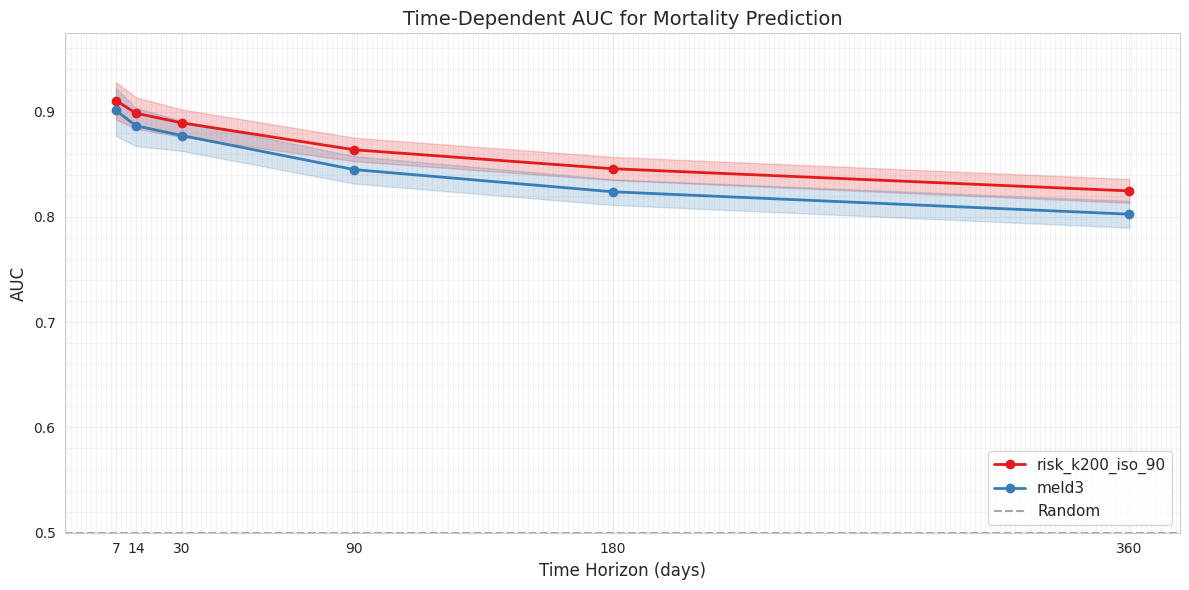

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def delong_test(y_true, y_pred1, y_pred2):
    """
    Implementation of DeLong's test for comparing two AUCs.

    Parameters:
    -----------
    y_true : array-like
        Binary ground truth (0/1)
    y_pred1 : array-like
        Predictions from first model
    y_pred2 : array-like
        Predictions from second model

    Returns:
    --------
    auc1 : float
        AUC of first model
    auc2 : float
        AUC of second model
    p_value : float
        Two-sided p-value from DeLong's test
    """
    # Calculate AUCs
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)

    # Get positive and negative indices
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]

    # Get predictions for positives and negatives
    pos_pred1 = y_pred1[pos_idx]
    neg_pred1 = y_pred1[neg_idx]
    pos_pred2 = y_pred2[pos_idx]
    neg_pred2 = y_pred2[neg_idx]

    # Calculate V10 and V01 (components of variance)
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    # Calculate psi matrix
    psi1_pos = np.zeros(n_pos)
    psi1_neg = np.zeros(n_neg)
    psi2_pos = np.zeros(n_pos)
    psi2_neg = np.zeros(n_neg)

    # For each positive example
    for i in range(n_pos):
        psi1_pos[i] = (np.sum(neg_pred1 < pos_pred1[i]) + 0.5 * np.sum(neg_pred1 == pos_pred1[i])) / n_neg
        psi2_pos[i] = (np.sum(neg_pred2 < pos_pred2[i]) + 0.5 * np.sum(neg_pred2 == pos_pred2[i])) / n_neg

    # For each negative example
    for i in range(n_neg):
        psi1_neg[i] = (np.sum(pos_pred1 > neg_pred1[i]) + 0.5 * np.sum(pos_pred1 == neg_pred1[i])) / n_pos
        psi2_neg[i] = (np.sum(pos_pred2 > neg_pred2[i]) + 0.5 * np.sum(pos_pred2 == neg_pred2[i])) / n_pos

    # Calculate variances
    var_pos = np.var(psi1_pos - psi2_pos, ddof=1) / n_pos
    var_neg = np.var(psi1_neg - psi2_neg, ddof=1) / n_neg
    var = var_pos + var_neg

    # Calculate z-score and p-value
    if var == 0:
        return auc1, auc2, 1.0  # No difference or insufficient data

    z = (auc1 - auc2) / np.sqrt(var)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # Two-sided p-value

    return auc1, auc2, p_value


def time_dependent_auc_with_delong(
    df,
    risk_cols=['risk_k200_iso_90', 'meld3'],
    outcome_col='outcome',
    tte_col='tte',
    time_points=[7, 14, 30, 90, 180, 360],
    bootstrap=True,
    n_bootstrap=1000,
    random_state=42
):
    """
    Compute time-dependent AUC for mortality prediction at various horizons,
    with DeLong's test for comparing AUCs.

    Args:
        df (pd.DataFrame): Must contain:
            - tte_col: Time to event or censor
            - outcome_col: Outcome (0=death, 1=censoring, 2=transplant)
            - risk_cols: Risk score columns (higher => higher risk)
        risk_cols (list): Column names for risk scores
        outcome_col (str): Column name for outcome
        tte_col (str): Column name for time-to-event
        time_points (list): List of integer day horizons
        bootstrap (bool): Whether to perform bootstrap for CIs
        n_bootstrap (int): Number of bootstrap iterations
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (results_df, comparison_df)
    """
    # Set random seed
    np.random.seed(random_state)

    # Ensure required columns exist
    required_cols = [tte_col, outcome_col] + risk_cols
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe.")

    results = []
    comparisons = []

    # Copy data to avoid modifying original
    df_all = df.copy()

    # For each time point
    for t in time_points:
        print(f"Processing time point: {t} days...")

        # 'At-risk' set: those who have sufficient follow-up
        at_risk_mask = (
            (df_all[tte_col] >= t) |
            ((df_all[outcome_col] == 0) & (df_all[tte_col] <= t))
        )
        df_at_risk = df_all[at_risk_mask].copy()

        # Define event indicator: 1 if died by time t, 0 otherwise
        event_mask = (
            (df_at_risk[outcome_col] == 0) &
            (df_at_risk[tte_col] <= t)
        )
        df_at_risk['event_indicator'] = event_mask.astype(int)

        # Store relevant data for each model
        model_data = {}
        model_aucs = {}

        # Calculate AUC for each risk model and store data for DeLong test
        for risk_col in risk_cols:
            # Drop rows with missing risk scores
            valid_data = df_at_risk[['event_indicator', risk_col]].dropna()

            if (valid_data['event_indicator'].sum() > 0 and
                valid_data['event_indicator'].sum() < len(valid_data)):

                # Store data for DeLong test
                model_data[risk_col] = valid_data

                # Calculate AUC
                auc = roc_auc_score(valid_data['event_indicator'], valid_data[risk_col])
                model_aucs[risk_col] = auc

                # Bootstrap confidence intervals if requested
                if bootstrap:
                    bootstrap_aucs = []

                    for _ in range(n_bootstrap):
                        # Sample with replacement
                        bootstrap_sample = valid_data.sample(n=len(valid_data), replace=True)

                        # Skip if bootstrap sample has all events or no events
                        if (bootstrap_sample['event_indicator'].sum() == 0 or
                            bootstrap_sample['event_indicator'].sum() == len(bootstrap_sample)):
                            continue

                        bootstrap_auc = roc_auc_score(
                            bootstrap_sample['event_indicator'],
                            bootstrap_sample[risk_col]
                        )
                        bootstrap_aucs.append(bootstrap_auc)

                    # Calculate confidence intervals
                    if bootstrap_aucs:
                        lower_ci, upper_ci = np.percentile(bootstrap_aucs, [2.5, 97.5])
                    else:
                        lower_ci = upper_ci = np.nan
                else:
                    lower_ci = upper_ci = np.nan
            else:
                auc = lower_ci = upper_ci = np.nan

            # Store results
            results.append({
                'time_point': t,
                'model': risk_col,
                'auc': auc,
                'lower_ci': lower_ci,
                'upper_ci': upper_ci,
                'n_patients': len(valid_data) if 'valid_data' in locals() else 0,
                'n_events': valid_data['event_indicator'].sum() if 'valid_data' in locals() and not valid_data.empty else 0
            })

        # Perform DeLong's test for pairwise comparisons
        if len(risk_cols) > 1:
            for i, model_i in enumerate(risk_cols):
                for j, model_j in enumerate(risk_cols):
                    if i < j:  # Only compare each pair once
                        # Get the intersection of patients with valid scores for both models
                        if model_i in model_data and model_j in model_data:
                            common_indices = model_data[model_i].index.intersection(model_data[model_j].index)

                            if len(common_indices) == 0:
                                continue

                            # Extract data for common patients
                            y_true = df_at_risk.loc[common_indices, 'event_indicator'].values
                            y_pred1 = df_at_risk.loc[common_indices, model_i].values
                            y_pred2 = df_at_risk.loc[common_indices, model_j].values

                            # Check if we have both positive and negative cases
                            if np.sum(y_true) > 0 and np.sum(y_true) < len(y_true):
                                # Perform DeLong's test
                                auc1, auc2, p_value = delong_test(y_true, y_pred1, y_pred2)

                                # Store comparison results
                                comparisons.append({
                                    'time_point': t,
                                    'model_i': model_i,
                                    'model_j': model_j,
                                    'auc_i': auc1,
                                    'auc_j': auc2,
                                    'auc_diff': auc1 - auc2,
                                    'p_value': p_value,
                                    'significant': p_value < 0.05,
                                    'test': 'DeLong'
                                })

    # Convert to DataFrames
    results_df = pd.DataFrame(results)
    comparison_df = pd.DataFrame(comparisons)

    return results_df, comparison_df


def plot_time_dependent_auc(results_df, models=None, figsize=(12, 6), save_path=None):
    """
    Plot time-dependent AUC with confidence intervals.

    Args:
        results_df (pd.DataFrame): Results from time_dependent_auc_with_delong
        models (list, optional): Models to include (default: all)
        figsize (tuple): Figure size
        save_path (str, optional): Path to save the figure

    Returns:
        matplotlib.pyplot.Figure: The figure object
    """
    if models is None:
        models = results_df['model'].unique()

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    # Color palette
    colors = sns.color_palette("Set1", len(models))

    for i, model in enumerate(models):
        model_data = results_df[results_df['model'] == model]

        # Skip if empty
        if model_data.empty:
            continue

        # Sort by time point
        model_data = model_data.sort_values('time_point')

        # Plot AUC line
        plt.plot(model_data['time_point'], model_data['auc'],
                marker='o', linewidth=2, label=model, color=colors[i])

        # Add confidence intervals
        if not model_data['lower_ci'].isna().all():
            plt.fill_between(
                model_data['time_point'],
                model_data['lower_ci'],
                model_data['upper_ci'],
                alpha=0.2,
                color=colors[i]
            )

    # Add reference line for random classifier
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Customize plot
    plt.xlabel('Time Horizon (days)', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.title('Time-Dependent AUC for Mortality Prediction', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, min(1.0, results_df['upper_ci'].max() * 1.05))

    # Set x-ticks to be exactly the time points
    time_points = sorted(results_df['time_point'].unique())
    plt.xticks(time_points, labels=time_points)

    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.2)
    plt.minorticks_on()

    # Tight layout
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt.gcf()


def print_auc_report(results_df, comparison_df):
    """
    Print a formatted report of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame): Comparison DataFrame with DeLong test results
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    print("\n" + "="*70)
    print("TIME-DEPENDENT AUC FOR MORTALITY PREDICTION")
    print("="*70)

    for t in time_points:
        print(f"\n{'-'*30} {t}-DAY MORTALITY {'-'*30}")

        # Get results for this time point
        time_results = results_df[results_df['time_point'] == t]

        # Print sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()
        print(f"Patients: {n_patients}, Deaths: {n_events} ({n_events/n_patients*100:.1f}%)\n")

        # Print AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    print(f"{model:20s}: AUC = {auc:.4f} (95% CI: {lower_ci:.4f}-{upper_ci:.4f})")
                else:
                    print(f"{model:20s}: AUC = {auc:.4f}")
            else:
                print(f"{model:20s}: AUC = N/A (insufficient data)")

        # Print DeLong test comparisons
        time_comparisons = comparison_df[comparison_df['time_point'] == t]

        if not time_comparisons.empty:
            print("\nDeLong Test Comparisons:")
            for _, row in time_comparisons.iterrows():
                model_i = row['model_i']
                model_j = row['model_j']
                auc_diff = row['auc_diff']
                p_value = row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = " ***"
                    elif p_value < 0.01:
                        sig = " **"
                    elif p_value < 0.05:
                        sig = " *"

                    if auc_diff > 0:
                        comparison_text = f"{model_i} > {model_j}"
                    elif auc_diff < 0:
                        comparison_text = f"{model_i} < {model_j}"
                    else:
                        comparison_text = f"{model_i} = {model_j}"

                    print(f"{comparison_text:25s}: Δ = {auc_diff:.4f}, p = {p_value:.4f}{sig}")


def create_auc_table(results_df, comparison_df=None):
    """
    Create a formatted table of time-dependent AUC results with DeLong test.

    Args:
        results_df (pd.DataFrame): Results DataFrame
        comparison_df (pd.DataFrame, optional): Comparison DataFrame with DeLong test results

    Returns:
        pd.DataFrame: Formatted results table
    """
    # Get unique time points and models
    time_points = sorted(results_df['time_point'].unique())
    models = sorted(results_df['model'].unique())

    # Create table structure
    table_data = []

    for t in time_points:
        time_results = results_df[results_df['time_point'] == t]

        # Get sample size and event counts
        n_patients = time_results['n_patients'].max()
        n_events = time_results['n_events'].max()

        row = {
            'Time Point (days)': t,
            'N Patients': n_patients,
            'N Deaths': n_events,
            '% Deaths': f"{n_events/n_patients*100:.1f}%"
        }

        # Add AUC for each model
        for model in models:
            model_row = time_results[time_results['model'] == model]

            if not model_row.empty and not pd.isna(model_row['auc'].iloc[0]):
                auc = model_row['auc'].iloc[0]

                if not pd.isna(model_row['lower_ci'].iloc[0]) and not pd.isna(model_row['upper_ci'].iloc[0]):
                    lower_ci = model_row['lower_ci'].iloc[0]
                    upper_ci = model_row['upper_ci'].iloc[0]
                    row[f'{model} AUC (95% CI)'] = f"{auc:.4f} ({lower_ci:.4f}-{upper_ci:.4f})"
                else:
                    row[f'{model} AUC'] = f"{auc:.4f}"
            else:
                row[f'{model} AUC'] = "N/A"

        # Add comparison results if provided
        if comparison_df is not None:
            time_comparisons = comparison_df[comparison_df['time_point'] == t]

            for _, comp_row in time_comparisons.iterrows():
                model_i = comp_row['model_i']
                model_j = comp_row['model_j']
                auc_diff = comp_row['auc_diff']
                p_value = comp_row['p_value']

                if not pd.isna(auc_diff) and not pd.isna(p_value):
                    # Add significance symbols
                    sig = ""
                    if p_value < 0.001:
                        sig = "***"
                    elif p_value < 0.01:
                        sig = "**"
                    elif p_value < 0.05:
                        sig = "*"

                    row[f'{model_i} vs {model_j} (p-value)'] = f"{auc_diff:.4f} ({p_value:.4f}){sig}"
                else:
                    row[f'{model_i} vs {model_j} (p-value)'] = "N/A"

        table_data.append(row)

    return pd.DataFrame(table_data)


# Example usage
if __name__ == "__main__":
    # Example dataframe (replace with your actual data)
    # Assuming:
    # - 'tte': Time to event in days
    # - 'outcome': 0=death, 1=censored, 2=transplant
    # - 'risk_k200_iso_90': Your isotonic risk score
    # - 'meld3': MELD-3 score

    results_df, comparison_df = time_dependent_auc_with_delong(
        df=real_df,
        risk_cols=['risk_k200_iso_90', 'meld3'],
        outcome_col='outcome',
        tte_col='tte',
        time_points=[7, 14, 30, 90, 180, 360],
        bootstrap=True,
        n_bootstrap=1000
    )

    # # Create visualization
    plot_time_dependent_auc(results_df, save_path='time_dependent_auc.png')

    # # Print detailed report
    print_auc_report(results_df, comparison_df)

    # # Create formatted table
    results_table = create_auc_table(results_df, comparison_df)
    results_table.to_csv('time_dependent_auc_results.csv', index=False)
    print("\nResults saved to 'time_dependent_auc_results.csv'")

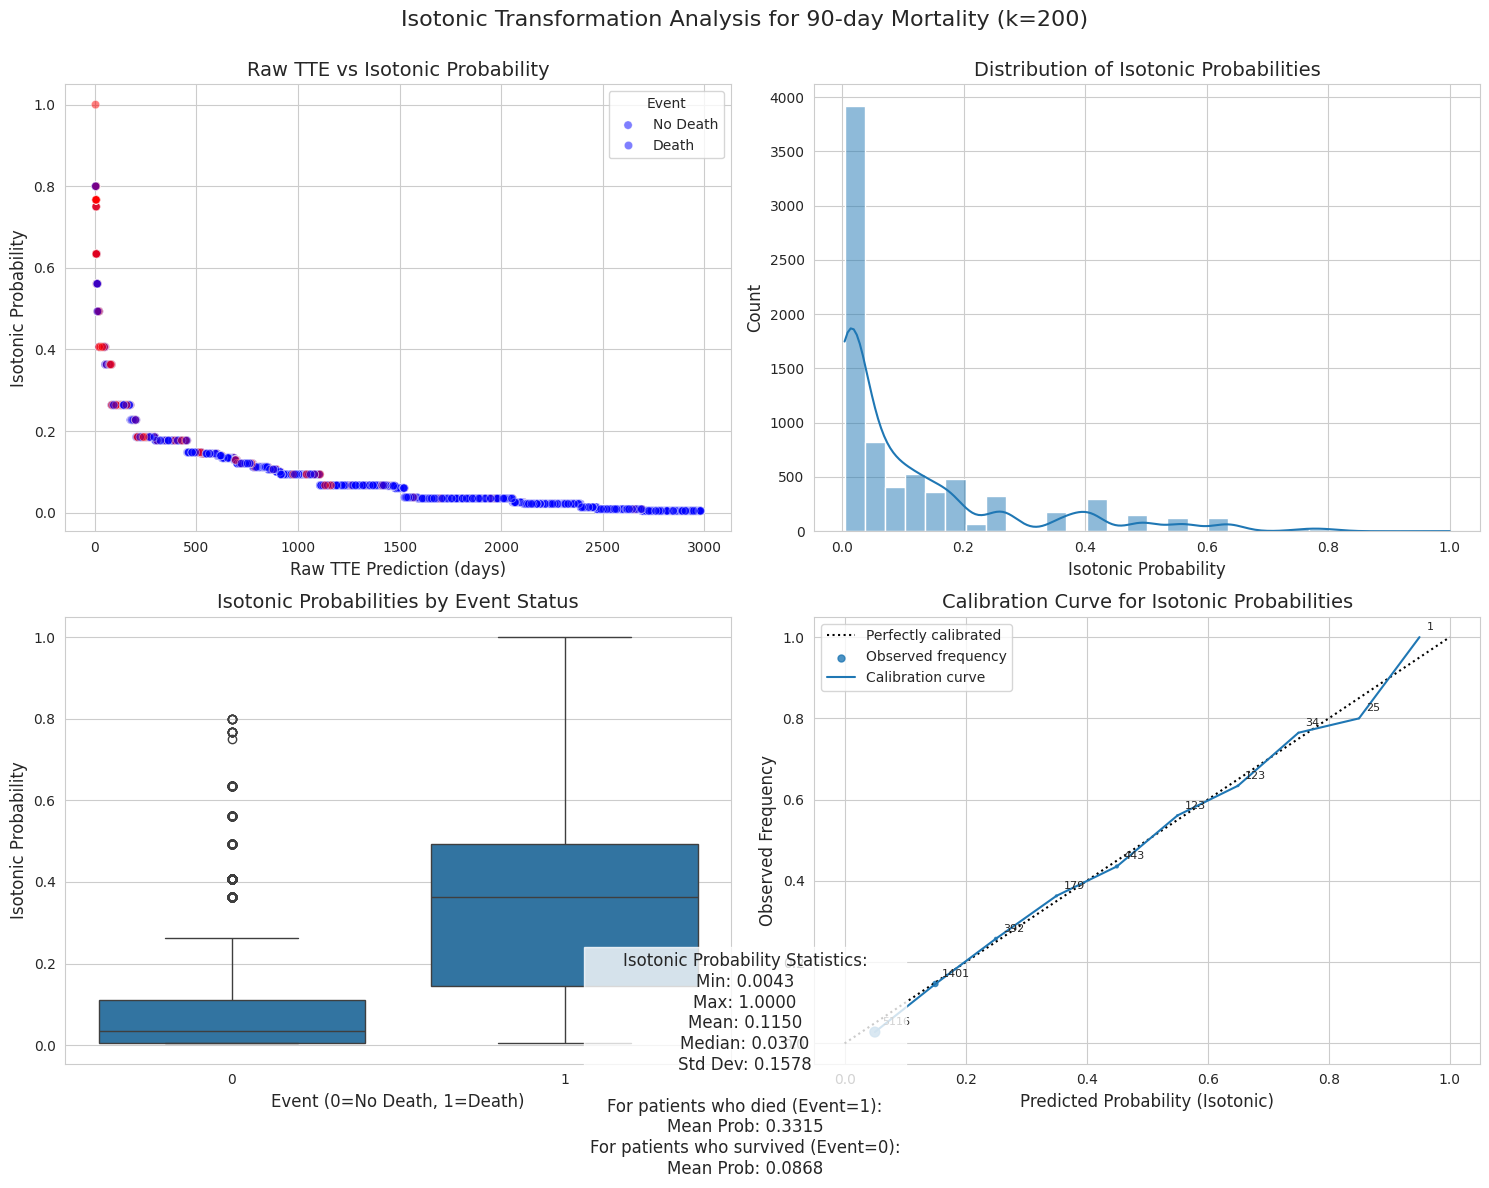

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.isotonic import IsotonicRegression

def visualize_isotonic_transform(df, timepoint=90, k=200, figsize=(15, 12), save_path=None):
    """
    Visualize the isotonic transformation of TTE predictions for k=200.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    figsize : tuple
        Figure size
    save_path : str, optional
        Path to save the figure

    Returns:
    --------
    matplotlib.figure.Figure
    """
    # Define at-risk set and event indicator
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    # Get prediction column
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # Compute isotonic calibration
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Apply calibration
    iso_probs = ir.predict(X)

    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        'Raw_TTE': tte_series.values,
        'Negative_TTE': X,
        'Isotonic_Prob': iso_probs,
        'Event': Y
    })

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # 1. Raw TTE vs Isotonic probability
    ax1 = axes[0, 0]
    sns.scatterplot(
        data=plot_df,
        x='Raw_TTE',
        y='Isotonic_Prob',
        hue='Event',
        palette={0:'blue', 1:'red'},
        alpha=0.5,
        ax=ax1
    )
    ax1.set_xlabel('Raw TTE Prediction (days)', fontsize=12)
    ax1.set_ylabel('Isotonic Probability', fontsize=12)
    ax1.set_title('Raw TTE vs Isotonic Probability', fontsize=14)
    ax1.legend(title='Event', labels=['No Death', 'Death'])

    # 2. Histogram of isotonic probabilities
    ax2 = axes[0, 1]
    sns.histplot(
        data=plot_df,
        x='Isotonic_Prob',
        bins=30,
        kde=True,
        ax=ax2
    )
    ax2.set_xlabel('Isotonic Probability', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Distribution of Isotonic Probabilities', fontsize=14)

    # 3. Isotonic probability by event status
    ax3 = axes[1, 0]
    sns.boxplot(
        data=plot_df,
        x='Event',
        y='Isotonic_Prob',
        ax=ax3
    )
    ax3.set_xlabel('Event (0=No Death, 1=Death)', fontsize=12)
    ax3.set_ylabel('Isotonic Probability', fontsize=12)
    ax3.set_title('Isotonic Probabilities by Event Status', fontsize=14)

    # 4. Calibration curve for isotonic probability
    ax4 = axes[1, 1]

    # Create bins and calculate observed frequencies
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(iso_probs, bin_edges[1:-1])

    observed_freqs = []
    bin_counts = []
    for i in range(n_bins):
        mask = (bin_indices == i)
        if np.sum(mask) > 0:
            observed_freqs.append(np.mean(Y[mask]))
            bin_counts.append(np.sum(mask))
        else:
            observed_freqs.append(np.nan)
            bin_counts.append(0)

    # Plot calibration curve
    ax4.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    # Only plot points with data
    valid_indices = [i for i, count in enumerate(bin_counts) if count > 0]
    valid_centers = [bin_centers[i] for i in valid_indices]
    valid_freqs = [observed_freqs[i] for i in valid_indices]
    valid_counts = [bin_counts[i] for i in valid_indices]

    # Scale point sizes by count
    sizes = [50 * (count / max(valid_counts)) for count in valid_counts]
    ax4.scatter(valid_centers, valid_freqs, s=sizes, alpha=0.8, label='Observed frequency')

    for i, (x, y, count) in enumerate(zip(valid_centers, valid_freqs, valid_counts)):
        ax4.annotate(f"{count}", (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.plot(valid_centers, valid_freqs, '-', label='Calibration curve')
    ax4.set_xlabel('Predicted Probability (Isotonic)', fontsize=12)
    ax4.set_ylabel('Observed Frequency', fontsize=12)
    ax4.set_title('Calibration Curve for Isotonic Probabilities', fontsize=14)
    ax4.legend(loc='upper left')

    # Add summary statistics
    stats_text = (
        f"Isotonic Probability Statistics:\n"
        f"Min: {plot_df['Isotonic_Prob'].min():.4f}\n"
        f"Max: {plot_df['Isotonic_Prob'].max():.4f}\n"
        f"Mean: {plot_df['Isotonic_Prob'].mean():.4f}\n"
        f"Median: {plot_df['Isotonic_Prob'].median():.4f}\n"
        f"Std Dev: {plot_df['Isotonic_Prob'].std():.4f}\n\n"
        f"For patients who died (Event=1):\n"
        f"Mean Prob: {plot_df[plot_df['Event']==1]['Isotonic_Prob'].mean():.4f}\n"
        f"For patients who survived (Event=0):\n"
        f"Mean Prob: {plot_df[plot_df['Event']==0]['Isotonic_Prob'].mean():.4f}"
    )

    # Add text to the figure
    fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the text at the bottom

    # Add overall title
    fig.suptitle(f'Isotonic Transformation Analysis for {timepoint}-day Mortality (k={k})',
                 fontsize=16, y=0.98)

    # Save if specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

# Example usage:
fig = visualize_isotonic_transform(
    real_df,
    timepoint=90,
    k=200,
    save_path='isotonic_transform_analysis_k200.png'
)
plt.show()

In [ ]:
def create_isotonic_risk_scores(df, timepoint=90, k=200, min_score=1, max_score=100):
    """
    Calculate isotonic probabilities and transform them to risk scores (1-100).

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    min_score : int
        Minimum score value (default: 1)
    max_score : int
        Maximum score value (default: 100)

    Returns:
    --------
    result_df : pandas DataFrame
        DataFrame with patient IDs, raw TTE, isotonic probabilities, and risk scores
    """
    import numpy as np
    import pandas as pd
    from sklearn.isotonic import IsotonicRegression

    # Define at-risk set and event indicator
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    # Get prediction column
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # Compute isotonic calibration
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Apply calibration
    iso_probs = ir.predict(X)

    # Transform to risk scores (1-100)
    risk_scores = np.round(min_score + (max_score - min_score) * iso_probs).astype(int)
    risk_scores = np.maximum(risk_scores, min_score)
    risk_scores = np.minimum(risk_scores, max_score)

    # Create result DataFrame
    result_df = pd.DataFrame({
        'patient_id': tte_series.index,
        'raw_tte': tte_series.values,
        'event': evt.values,
        'isotonic_prob': iso_probs,
        'risk_score': risk_scores
    })

    # Print summary statistics
    print("Isotonic Risk Score Statistics:")
    print(f"Min: {result_df['risk_score'].min()}")
    print(f"Max: {result_df['risk_score'].max()}")
    print(f"Mean: {result_df['risk_score'].mean():.1f}")
    print(f"Median: {result_df['risk_score'].median():.1f}")
    print(f"For patients who died: Mean Score: {result_df[result_df['event']==1]['risk_score'].mean():.1f}")
    print(f"For patients who survived: Mean Score: {result_df[result_df['event']==0]['risk_score'].mean():.1f}")

    return result_df

# Example usage:
risk_score_df = create_isotonic_risk_scores(real_df, timepoint=90, k=200)

# Optionally save to CSV
risk_score_df.to_csv('isotonic_risk_scores_k200.csv', index=False)

Isotonic Risk Score Statistics:
Min: 1
Max: 100
Mean: 12.3
Median: 5.0
For patients who died: Mean Score: 33.9
For patients who survived: Mean Score: 9.5


In [ ]:
def add_isotonic_risk_scores_to_df(df, timepoint=90, k=200, min_score=1, max_score=100, save_path=None):
    """
    Calculate isotonic probabilities, transform them to risk scores (1-100),
    and add them to the original dataframe.

    Parameters:
    -----------
    df : pandas DataFrame
        Original DataFrame containing patient data
    timepoint : int
        Time horizon in days (default: 90)
    k : int
        k value for neighborhood size (default: 200)
    min_score : int
        Minimum score value (default: 1)
    max_score : int
        Maximum score value (default: 100)
    save_path : str, optional
        Path to save the CSV file (default: None)

    Returns:
    --------
    df_with_scores : pandas DataFrame
        Original DataFrame with added risk score columns
    """
    import numpy as np
    import pandas as pd
    from sklearn.isotonic import IsotonicRegression

    # Create a copy of the original dataframe to avoid modifying it
    df_with_scores = df.copy()

    # Define at-risk set and event indicator
    at_risk_mask = (
        (df['tte'] >= timepoint) |
        ((df['outcome'] == 0) & (df['tte'] <= timepoint))
    )
    df_at_risk = df[at_risk_mask].copy()

    event_indicator = (
        (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= timepoint)
    ).astype(int)

    # Get prediction column
    pred_col = f'predicted_death_tte_k{k}'
    if pred_col not in df_at_risk.columns:
        print(f"Warning: {pred_col} not found, trying alternative...")
        pred_col = f'predicted_majority_tte_k{k}'
        if pred_col not in df_at_risk.columns:
            raise ValueError(f"No prediction column found for k={k}")

    # Get valid predictions
    tte_series = df_at_risk[pred_col].copy().dropna()
    common_idx = tte_series.index.intersection(event_indicator.index)
    tte_series = tte_series.loc[common_idx]
    evt = event_indicator.loc[common_idx]

    # Compute isotonic calibration
    X = -tte_series.values  # Negative TTE (higher = higher risk)
    Y = evt.values

    # Fit isotonic regression
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(X, Y)

    # Initialize new columns with NaN values
    isotonic_col = f'isotonic_prob_k{k}_t{timepoint}'
    risk_score_col = f'risk_score_k{k}_t{timepoint}'
    df_with_scores[isotonic_col] = np.nan
    df_with_scores[risk_score_col] = np.nan

    # Calculate isotonic probabilities for all patients with valid predictions
    for idx, row in df.iterrows():
        if pd.notna(row[pred_col]):
            # Use negative TTE for prediction (same as in training)
            neg_tte = -row[pred_col]

            # Get isotonic probability
            iso_prob = ir.predict([neg_tte])[0]

            # Transform to risk score
            risk_score = int(np.round(min_score + (max_score - min_score) * iso_prob))
            risk_score = max(min_score, min(max_score, risk_score))

            # Add to dataframe
            df_with_scores.loc[idx, isotonic_col] = iso_prob
            df_with_scores.loc[idx, risk_score_col] = risk_score

    # Print summary statistics
    valid_scores = df_with_scores[risk_score_col].dropna()
    print(f"Added {len(valid_scores)} risk scores to dataframe")
    print(f"New columns: '{isotonic_col}' and '{risk_score_col}'")
    print("\nRisk Score Statistics:")
    print(f"Min: {valid_scores.min()}")
    print(f"Max: {valid_scores.max()}")
    print(f"Mean: {valid_scores.mean():.1f}")
    print(f"Median: {valid_scores.median():.1f}")

    # Save to CSV if specified
    if save_path:
        df_with_scores.to_csv(save_path, index=True)
        print(f"\nSaved complete dataframe to: {save_path}")

    return df_with_scores

# Example usage:
real_df_with_scores = add_isotonic_risk_scores_to_df(
    real_df,
    timepoint=90,
    k=200,
    save_path='real_df_with_risk_scores.csv'
)

Added 9395 risk scores to dataframe
New columns: 'isotonic_prob_k200_t90' and 'risk_score_k200_t90'

Risk Score Statistics:
Min: 1.0
Max: 100.0
Mean: 14.2
Median: 8.0

Saved complete dataframe to: real_df_with_risk_scores.csv


In [ ]:
real_df = pd.read_csv('/content/real_df_with_risk_scores.csv')

Comparing risk_score_k200_t90 vs meld3
Time horizons: [7, 14, 30, 90, 180, 360]
Number of bootstrap samples: 1000
MELD scores are capped at 40

Calculating direct c-indices...
C-index results summary:
   horizon  c_risk_score_k200_t90   c_meld3  difference
0        7               0.902996  0.893806    0.009190
1       14               0.885371  0.873677    0.011695
2       30               0.870562  0.859247    0.011315
3       90               0.842197  0.824360    0.017838
4      180               0.823314  0.803102    0.020213
5      360               0.805411  0.784067    0.021344

Running bootstrap analysis...
Bootstrapping horizon: 7 days
Bootstrapping horizon: 14 days
Bootstrapping horizon: 30 days
Bootstrapping horizon: 90 days
Bootstrapping horizon: 180 days
Bootstrapping horizon: 360 days

=== Time-Dependent Concordance Index (Bootstrap) ===


--- 7.0-day Concordance Index ---
Patients: 9395.0, Events: 156.0 (1.7% event rate)
risk_score_k200_t90 c-index: 0.9030   (95% CI: [0

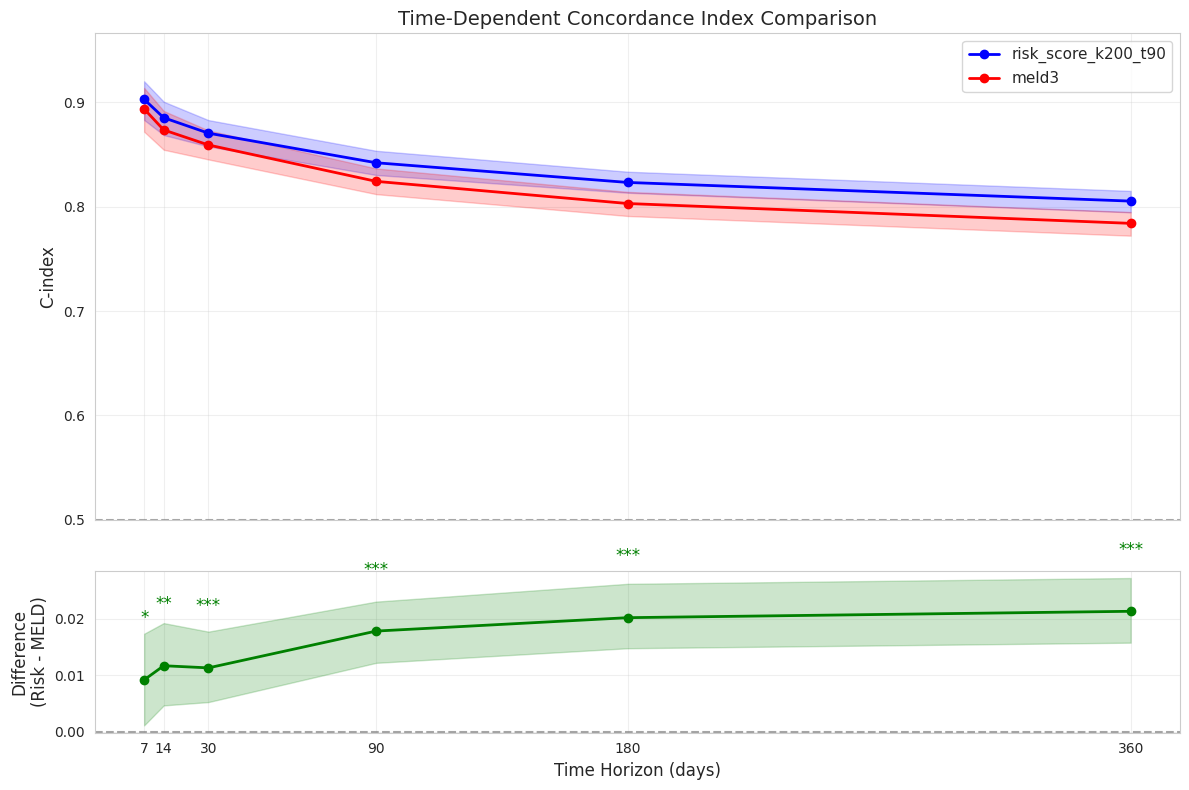

In [ ]:
import numpy as np
import pandas as pd
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import seaborn as sns

def direct_cindex_at_horizons(df,
                             risk_col="risk_score_k200_t90",
                             meld_col="meld3",
                             outcome_col="outcome",
                             tte_col="tte",
                             horizons=[7, 14, 30, 90, 180, 360],
                             cap_meld=True,
                             meld_cap_value=40):
    """
    Compute c-index at multiple horizons for 'risk_col' & 'meld_col'
    WITHOUT re-fitting any Cox model. We do direct c-index from lifelines.utils.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate
        cap_meld: Whether to cap MELD score at a maximum value
        meld_cap_value: Value to cap MELD score at (typically 40)

    Returns:
        DataFrame with c-index results for each horizon
    """
    results = []

    for horizon in horizons:
        data_t = df.copy()

        # Label event=1 if death <= horizon, else 0
        data_t['event_t'] = ((data_t[outcome_col] == 0) & (data_t[tte_col] <= horizon)).astype(int)
        # times_t = min(tte, horizon)
        data_t['time_t'] = np.minimum(data_t[tte_col], horizon)

        # Cap MELD score if requested
        if cap_meld:
            data_t[meld_col] = np.minimum(data_t[meld_col], meld_cap_value)

        # Drop rows missing risk or meld
        needed_cols = ['time_t', 'event_t', risk_col, meld_col]
        data_t = data_t[needed_cols].dropna()

        if data_t.empty:
            print(f"Warning: No valid rows after dropping missing data for horizon {horizon}.")
            c_risk = c_meld = np.nan
        else:
            # Count events for reporting
            n_patients = len(data_t)
            n_events = data_t['event_t'].sum()

            # c-index for risk_col - using negative of risk score
            c_risk = concordance_index(
                data_t['time_t'],
                -data_t[risk_col],  # Negate the risk score
                data_t['event_t']
            )
            # c-index for meld_col - using negative of meld score
            c_meld = concordance_index(
                data_t['time_t'],
                -data_t[meld_col],  # Negate the meld score
                data_t['event_t']
            )

        results.append({
            'horizon': horizon,
            f'c_{risk_col}': c_risk,
            f'c_{meld_col}': c_meld,
            'difference': c_risk - c_meld if not np.isnan(c_risk) and not np.isnan(c_meld) else np.nan,
            'n_patients': n_patients if 'n_patients' in locals() else 0,
            'n_events': n_events if 'n_events' in locals() else 0
        })

    return pd.DataFrame(results)


def bootstrap_direct_cindex_at_horizons(df,
                                      risk_col="risk_score_k200_t90",
                                      meld_col="meld3",
                                      outcome_col="outcome",
                                      tte_col="tte",
                                      horizons=[7, 14, 30, 90, 180, 360],
                                      n_bootstraps=500,
                                      random_state=42,
                                      cap_meld=True,
                                      meld_cap_value=40):
    """
    Bootstrap the difference in c-index at multiple horizons using direct
    lifelines.utils.concordance_index (no repeated CoxPH fits).

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        outcome_col: Column name for outcome (0=death, 1=censored, 2=transplant)
        tte_col: Column name for time-to-event
        horizons: List of time horizons (in days) to evaluate
        n_bootstraps: Number of bootstrap samples
        random_state: Random seed for reproducibility

    Returns:
        DataFrame with bootstrap results for each horizon
    """
    np.random.seed(random_state)
    results = []

    for horizon in horizons:
        print(f"Bootstrapping horizon: {horizon} days")

        # 1) Prepare the main subset
        df_t = df.copy()
        df_t['event_t'] = ((df_t[outcome_col]==0) & (df_t[tte_col] <= horizon)).astype(int)
        df_t['time_t'] = np.minimum(df_t[tte_col], horizon)

        # Cap MELD score if requested
        if cap_meld:
            df_t[meld_col] = np.minimum(df_t[meld_col], meld_cap_value)

        needed = ['time_t', 'event_t', risk_col, meld_col]
        df_t = df_t[needed].dropna()

        if df_t.empty:
            print(f"Warning: No valid data after dropping NAs for horizon {horizon}.")
            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': np.nan,
                f'c_{meld_col}_full': np.nan,
                'orig_diff': np.nan,
                'ci_risk_lower': np.nan,
                'ci_risk_upper': np.nan,
                'ci_meld_lower': np.nan,
                'ci_meld_upper': np.nan,
                'ci_diff_lower': np.nan,
                'ci_diff_upper': np.nan,
                'p_value': np.nan,
                'n_patients': 0,
                'n_events': 0
            }
        else:
            # 2) Full-sample c-index - using negative of risk scores
            c_risk_full = concordance_index(df_t['time_t'], -df_t[risk_col], df_t['event_t'])
            c_meld_full = concordance_index(df_t['time_t'], -df_t[meld_col], df_t['event_t'])
            orig_diff = c_risk_full - c_meld_full

            # Count patients and events
            n_patients = len(df_t)
            n_events = df_t['event_t'].sum()

            # 3) Bootstrapping
            n = len(df_t)
            c_risk_boot = []
            c_meld_boot = []

            for _ in range(n_bootstraps):
                sample_idx = np.random.randint(0, n, size=n)
                df_boot = df_t.iloc[sample_idx]

                # Skip bootstrap samples with no events or all events
                if df_boot['event_t'].sum() == 0 or df_boot['event_t'].sum() == len(df_boot):
                    continue

                # c-index for risk - using negative of risk score
                c_risk_b = concordance_index(df_boot['time_t'],
                                           -df_boot[risk_col],
                                           df_boot['event_t'])
                # c-index for meld - using negative of meld score
                c_meld_b = concordance_index(df_boot['time_t'],
                                           -df_boot[meld_col],
                                           df_boot['event_t'])

                c_risk_boot.append(c_risk_b)
                c_meld_boot.append(c_meld_b)

            c_risk_boot = np.array(c_risk_boot)
            c_meld_boot = np.array(c_meld_boot)
            diff_boot = c_risk_boot - c_meld_boot

            # 4) Confidence intervals
            ci_risk = np.percentile(c_risk_boot, [2.5, 97.5])
            ci_meld = np.percentile(c_meld_boot, [2.5, 97.5])
            ci_diff = np.percentile(diff_boot, [2.5, 97.5])

            # 5) Two-sided p-value for diff=0
            if orig_diff >= 0:
                p_one_sided = np.mean(diff_boot < 0)
            else:
                p_one_sided = np.mean(diff_boot > 0)
            p_value = min(2 * p_one_sided, 1.0)

            result = {
                'horizon': horizon,
                f'c_{risk_col}_full': c_risk_full,
                f'c_{meld_col}_full': c_meld_full,
                'orig_diff': orig_diff,
                'ci_risk_lower': ci_risk[0],
                'ci_risk_upper': ci_risk[1],
                'ci_meld_lower': ci_meld[0],
                'ci_meld_upper': ci_meld[1],
                'ci_diff_lower': ci_diff[0],
                'ci_diff_upper': ci_diff[1],
                'p_value': p_value,
                'n_patients': n_patients,
                'n_events': n_events
            }

        results.append(result)

    return pd.DataFrame(results)


def show_bootstrap_results_at_horizons(bootstrap_results, risk_col="risk_score_k200_t90", meld_col="meld3"):
    """
    Nicely print the bootstrap results from all horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
    """
    print("\n=== Time-Dependent Concordance Index (Bootstrap) ===\n")

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']
        print(f"\n--- {horizon}-day Concordance Index ---")
        print(f"Patients: {row['n_patients']}, Events: {row['n_events']} " +
              f"({row['n_events']/row['n_patients']*100:.1f}% event rate)")

        # Risk score c-index
        risk_name = f'c_{risk_col}_full'
        if not pd.isna(row[risk_name]):
            print(f"{risk_col} c-index: {row[risk_name]:.4f}   " +
                  f"(95% CI: [{row['ci_risk_lower']:.4f}, {row['ci_risk_upper']:.4f}])")
        else:
            print(f"{risk_col} c-index: N/A (insufficient data)")

        # MELD score c-index
        meld_name = f'c_{meld_col}_full'
        if not pd.isna(row[meld_name]):
            print(f"{meld_col} c-index: {row[meld_name]:.4f}   " +
                  f"(95% CI: [{row['ci_meld_lower']:.4f}, {row['ci_meld_upper']:.4f}])")
        else:
            print(f"{meld_col} c-index: N/A (insufficient data)")

        # Difference
        if not pd.isna(row['orig_diff']):
            print(f"Difference:       {row['orig_diff']:.4f}   " +
                  f"(95% CI: [{row['ci_diff_lower']:.4f}, {row['ci_diff_upper']:.4f}])")

            # Add significance indicators
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            print(f"p-value (2-sided): {row['p_value']:.4f} {sig}")
        else:
            print("Difference: N/A (insufficient data)")


def plot_cindex_over_time(bootstrap_results, risk_col="risk_score_k200_t90", meld_col="meld3",
                          figsize=(12, 8), save_path=None):
    """
    Plot c-index values and their differences over different time horizons.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column
        figsize: Figure size as tuple (width, height)
        save_path: Path to save the figure (optional)
    """
    risk_name = f'c_{risk_col}_full'
    meld_name = f'c_{meld_col}_full'

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True,
                                  gridspec_kw={'height_ratios': [3, 1]})

    # Plot c-indices with confidence intervals
    horizons = bootstrap_results['horizon'].values

    # Risk score
    risk_cindices = bootstrap_results[risk_name].values
    risk_lower = bootstrap_results['ci_risk_lower'].values
    risk_upper = bootstrap_results['ci_risk_upper'].values

    ax1.plot(horizons, risk_cindices, 'o-', label=risk_col, color='blue', linewidth=2)
    ax1.fill_between(horizons, risk_lower, risk_upper, alpha=0.2, color='blue')

    # MELD score
    meld_cindices = bootstrap_results[meld_name].values
    meld_lower = bootstrap_results['ci_meld_lower'].values
    meld_upper = bootstrap_results['ci_meld_upper'].values

    ax1.plot(horizons, meld_cindices, 'o-', label=meld_col, color='red', linewidth=2)
    ax1.fill_between(horizons, meld_lower, meld_upper, alpha=0.2, color='red')

    # Formatting for c-index plot
    ax1.set_ylabel('C-index', fontsize=12)
    ax1.set_title('Time-Dependent Concordance Index Comparison', fontsize=14)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.5, min(1.0, max(bootstrap_results['ci_risk_upper'].max(),
                                 bootstrap_results['ci_meld_upper'].max()) * 1.05))

    # Add reference line for random prediction
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')

    # Plot difference with confidence intervals
    diff_values = bootstrap_results['orig_diff'].values
    diff_lower = bootstrap_results['ci_diff_lower'].values
    diff_upper = bootstrap_results['ci_diff_upper'].values

    ax2.plot(horizons, diff_values, 'o-', color='green', linewidth=2)
    ax2.fill_between(horizons, diff_lower, diff_upper, alpha=0.2, color='green')

    # Add reference line at zero
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Add significance markers
    for i, p_value in enumerate(bootstrap_results['p_value']):
        if p_value < 0.05:
            marker = '*'
            if p_value < 0.01:
                marker = '**'
            if p_value < 0.001:
                marker = '***'

            y_pos = diff_values[i] + 0.01 if diff_values[i] > 0 else diff_values[i] - 0.02
            ax2.text(horizons[i], y_pos, marker, ha='center', fontsize=12, color='green')

    # Formatting for difference plot
    ax2.set_xlabel('Time Horizon (days)', fontsize=12)
    ax2.set_ylabel('Difference\n(Risk - MELD)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Set x-ticks to be exactly the time points
    plt.xticks(horizons, labels=horizons)

    # Adjust layout and save if requested
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig


def create_cindex_table(bootstrap_results, risk_col="risk_score_k200_t90", meld_col="meld3"):
    """
    Create a formatted table of c-index results suitable for publication.

    Args:
        bootstrap_results: DataFrame from bootstrap_direct_cindex_at_horizons
        risk_col: Name of risk column
        meld_col: Name of MELD column

    Returns:
        pandas.DataFrame: Formatted table
    """
    # Prepare table columns
    table_data = []

    for _, row in bootstrap_results.iterrows():
        horizon = row['horizon']

        # Format values with proper precision
        risk_name = f'c_{risk_col}_full'
        meld_name = f'c_{meld_col}_full'

        if pd.isna(row[risk_name]) or pd.isna(row[meld_name]):
            risk_ci = meld_ci = diff_ci = diff_p = "N/A"
        else:
            # Add significance markers
            sig = ""
            if row['p_value'] < 0.001:
                sig = "***"
            elif row['p_value'] < 0.01:
                sig = "**"
            elif row['p_value'] < 0.05:
                sig = "*"

            risk_ci = f"{row[risk_name]:.4f} ({row['ci_risk_lower']:.4f}-{row['ci_risk_upper']:.4f})"
            meld_ci = f"{row[meld_name]:.4f} ({row['ci_meld_lower']:.4f}-{row['ci_meld_upper']:.4f})"
            diff_ci = f"{row['orig_diff']:.4f} ({row['ci_diff_lower']:.4f}-{row['ci_diff_upper']:.4f})"
            diff_p = f"{row['p_value']:.4f}{sig}"

        table_data.append({
            'Horizon (days)': horizon,
            'Patients': row['n_patients'],
            'Events': row['n_events'],
            'Event Rate (%)': f"{row['n_events']/row['n_patients']*100:.1f}%" if row['n_patients'] > 0 else "N/A",
            f'{risk_col} C-index (95% CI)': risk_ci,
            f'{meld_col} C-index (95% CI)': meld_ci,
            'Difference (95% CI)': diff_ci,
            'p-value': diff_p
        })

    return pd.DataFrame(table_data)


# Example usage
def run_comparison(df, risk_col="risk_score_k200_t90", meld_col="meld3",
                 horizons=[7, 14, 30, 90, 180, 360], n_bootstraps=500,
                 cap_meld=True, meld_cap_value=40):
    """
    Run a complete comparison analysis between risk score and MELD.

    Args:
        df: DataFrame with time-to-event data
        risk_col: Column name for risk score
        meld_col: Column name for MELD score
        horizons: List of time horizons (in days) to evaluate
        n_bootstraps: Number of bootstrap samples
    """
    print(f"Comparing {risk_col} vs {meld_col}")
    print(f"Time horizons: {horizons}")
    print(f"Number of bootstrap samples: {n_bootstraps}")
    if cap_meld:
        print(f"MELD scores are capped at {meld_cap_value}")

    # 1) Direct c-index on full data
    print("\nCalculating direct c-indices...")
    cindex_results = direct_cindex_at_horizons(
        df=df,
        risk_col=risk_col,
        meld_col=meld_col,
        horizons=horizons,
        cap_meld=cap_meld,
        meld_cap_value=meld_cap_value
    )
    print("C-index results summary:")
    print(cindex_results[['horizon', f'c_{risk_col}', f'c_{meld_col}', 'difference']])

    # 2) Bootstrap
    print("\nRunning bootstrap analysis...")
    bootstrap_results = bootstrap_direct_cindex_at_horizons(
        df=df,
        risk_col=risk_col,
        meld_col=meld_col,
        horizons=horizons,
        n_bootstraps=n_bootstraps,
        cap_meld=cap_meld,
        meld_cap_value=meld_cap_value
    )

    # 3) Show results
    show_bootstrap_results_at_horizons(bootstrap_results, risk_col=risk_col, meld_col=meld_col)

    # 4) Plot results
    meld_suffix = f"_capped{meld_cap_value}" if cap_meld else ""
    fig = plot_cindex_over_time(bootstrap_results, risk_col=risk_col, meld_col=meld_col,
                             save_path=f"cindex_comparison_{risk_col}_vs_{meld_col}{meld_suffix}.png")

    # 5) Create publication-ready table
    table = create_cindex_table(bootstrap_results, risk_col=risk_col, meld_col=meld_col)
    print("\nPublication-Ready Table:")
    print(table)

    # Save results
    meld_suffix = f"_capped{meld_cap_value}" if cap_meld else ""
    bootstrap_results.to_csv(f"bootstrap_results_{risk_col}_vs_{meld_col}{meld_suffix}.csv", index=False)
    table.to_csv(f"cindex_table_{risk_col}_vs_{meld_col}{meld_suffix}.csv", index=False)

    return {
        'cindex_results': cindex_results,
        'bootstrap_results': bootstrap_results,
        'table': table,
        'plot': fig
    }


if __name__ == "__main__":
    # List of time horizons to evaluate
    horizons = [7, 14, 30, 90, 180, 360]

    # Run the comparison analysis
    results = run_comparison(
        df=real_df,  # Your dataframe should be defined elsewhere
        risk_col="risk_score_k200_t90",
        meld_col="meld3",
        horizons=horizons,
        n_bootstraps=1000,
        cap_meld=True,
        meld_cap_value=40
    )

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

############################################################################
# 1. We no longer force 'death_event' for embedding. We keep outcome as is.
#    We'll do "winner-outcome" among neighbors: 0=death,1=censored,2=tx
############################################################################

# syn_df_processed should have columns: ['tte','outcome',...]
# syn_embeddings: shape [n_syn, embed_dim]
# real_embeddings: shape [n_real, embed_dim]

############################################################################
# 2. KNN setup
############################################################################
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def compute_composite_proportional_tte(
    idx,
    syn_df,
    indices_all,
    real_df
):
    """
    For a single real patient i:
      1. Gather the K neighbors from syn_df (via indices_all[i]).
      2. Split them by outcome:
         - 0 = death
         - 1 = censored
         - 2 = transplant
      3. Compute the median TTE within each group.
      4. Multiply each median by that group's proportion,
         then sum to get final 'composite' TTE.
    """
    neighbor_idxs = indices_all[idx]
    neighbors = syn_df.iloc[neighbor_idxs]

    # Count how many neighbors belong to each outcome
    is_death = (neighbors['outcome'] == 0)
    is_cens = (neighbors['outcome'] == 1)
    is_tx   = (neighbors['outcome'] == 2)

    n_death = is_death.sum()
    n_cens  = is_cens.sum()
    n_tx    = is_tx.sum()
    total   = len(neighbors)

    if total == 0:
        # Edge case: no neighbors at all (unlikely)
        return np.nan

    # Proportions
    p_death = n_death / total
    p_cens  = n_cens  / total
    p_tx    = n_tx    / total

    # Median TTE for each group
    # If a group is empty, median => np.nan
    def median_tte_in_group(mask):
        if mask.sum() == 0:
            return np.nan
        else:
            return np.median(neighbors.loc[mask, 'tte'].values)

    med_death = median_tte_in_group(is_death)
    med_cens  = median_tte_in_group(is_cens)
    med_tx    = median_tte_in_group(is_tx)

    # Weighted sum of medians:
    # If any group is empty => p=0 => no contribution
    # If median is np.nan => interpret as 0 or skip
    # Here we do a simple approach: if group is non-empty, we
    # multiply proportion by median; if median is NaN, skip or set 0.
    def safe_contrib(p, med):
        # If median is nan => treat as 0 contribution
        if np.isnan(med):
            return 0.0
        else:
            return p * med

    tte_final = (
        safe_contrib(p_death, med_death)
      + safe_contrib(p_cens,  med_cens)
      + safe_contrib(p_tx,    med_tx)
    )
    return tte_final


def compute_proportional_composite_predictions(
    syn_df_processed,
    indices_all,
    real_df
):
    """
    Loop over all real patients in parallel and compute 'composite proportional TTE'.
    """
    n_real = len(real_df)
    with tqdm_joblib(tqdm(desc="Computing composite proportional TTE", total=n_real)) as progress_bar:
        predicted_ttes = Parallel(n_jobs=-1, backend="threading")(
            delayed(compute_composite_proportional_tte)(i, syn_df_processed, indices_all, real_df)
            for i in range(n_real)
        )
    return np.array(predicted_ttes)


###############################################################################
# EXAMPLE USAGE:
###############################################################################
# 1) We assume we already have:
#   - syn_df_processed: synthetic DataFrame with columns ['tte','outcome', ...].
#   - indices_all: shape (n_real, K), neighbors for each real patient.
#   - real_df: real DataFrame to store results.

# 2) Run the function
predicted_composite = compute_proportional_composite_predictions(
     syn_df_processed,
     indices_all,
     real_df
 )
real_df['predicted_composite_tte'] = predicted_composite

# 3) Inspect a sample
print(real_df[['predicted_composite_tte','tte','outcome']].head())


Computing composite proportional TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte  tte  outcome
0               279.660952  365        1
1               107.478470  365        1
2               241.256056  365        1
3                93.690000  264        2
4                26.740000   36        0


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.885          0.894             0.893
1    14           0.866          0.874             0.874
2    30           0.849          0.859             0.859
3    90           0.817          0.824             0.825
4   180           0.795          0.803             0.804
5   360           0.775          0.784             0.784

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.990     1.105       0.0      0.0
1    14      0.993     1.110       0.0      0.0
2    30      0.993     1.104       0.0      0.0
3    90      0.994     1.090       0.0      0.0
4   180      0.995     1.081       0.0      0.0
5   360      0.996     1.076       0.0      0.0


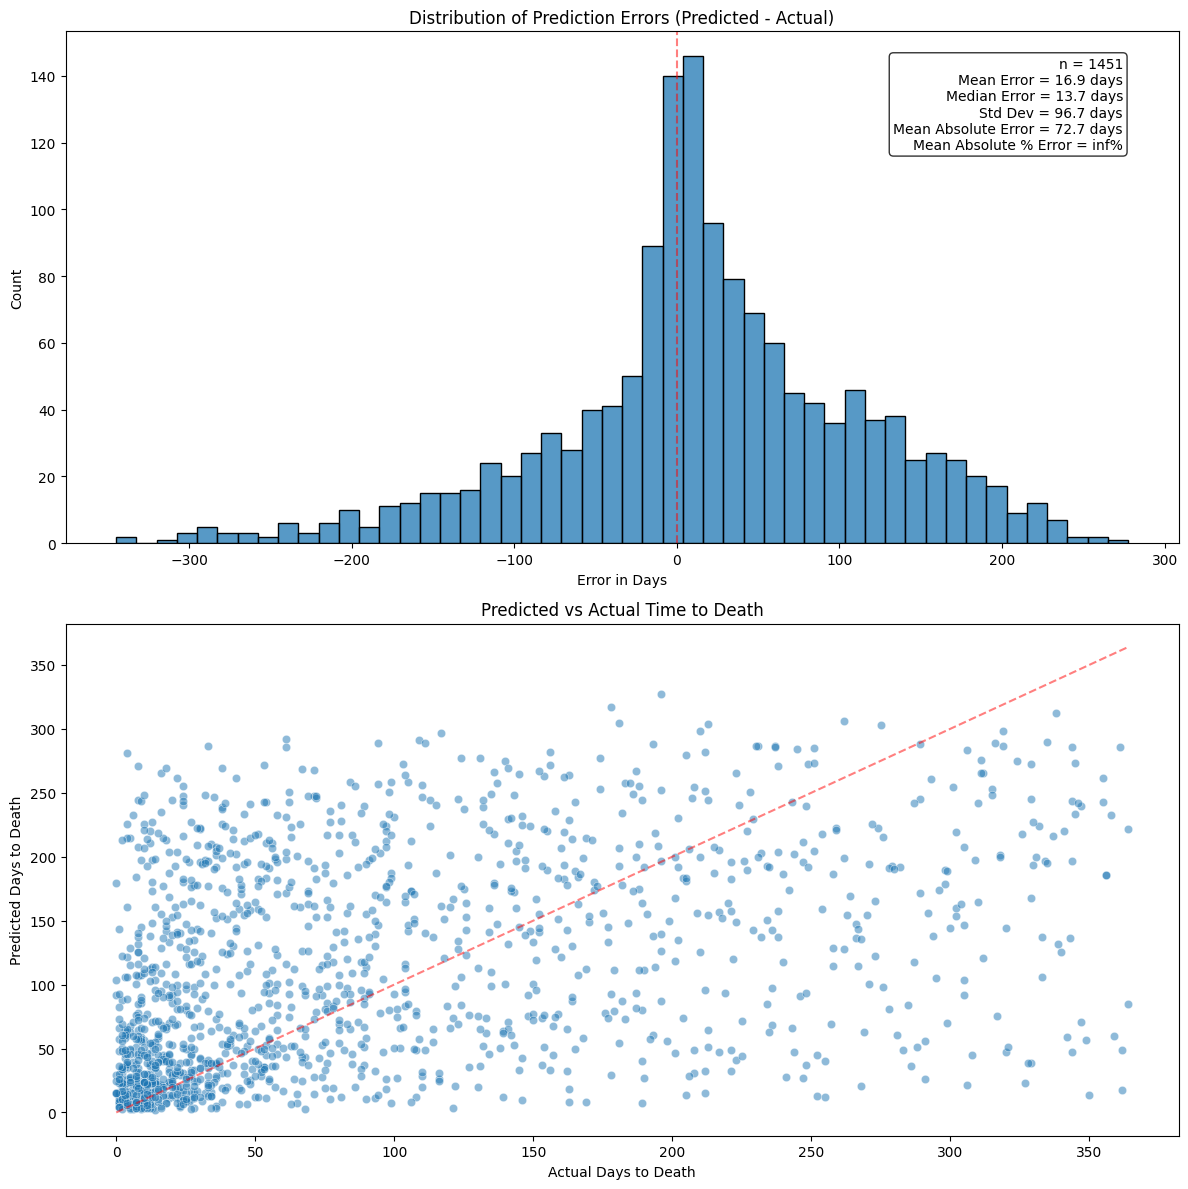


Prediction Error Statistics:
Number of death cases: 1451
Mean error: 16.9 days
Median error: 13.7 days
Standard deviation: 96.7 days
Mean absolute error: 72.7 days
Mean absolute percentage error: inf%

Error Quartiles:
count    1451.000000
mean       16.943801
std        96.733701
min      -344.730674
25%       -24.960053
50%        13.688455
75%        74.101209
max       277.488382
Name: error, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for death cases only
death_mask = real_df['outcome'] == 0
death_cases = real_df[death_mask].copy()

# Calculate prediction errors (predicted - actual)
death_cases['error'] = death_cases['predicted_composite_tte'] - death_cases['tte']

# Calculate summary statistics
error_stats = {
    'n': len(death_cases),
    'mean': death_cases['error'].mean(),
    'median': death_cases['error'].median(),
    'std': death_cases['error'].std(),
    'mae': death_cases['error'].abs().mean(),
    'mape': (death_cases['error'].abs() / death_cases['tte']).mean() * 100
}

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. Error Distribution (Histogram)
sns.histplot(data=death_cases, x='error', bins=50, ax=ax1)
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Prediction Errors (Predicted - Actual)')
ax1.set_xlabel('Error in Days')
ax1.set_ylabel('Count')

# Add error statistics to plot
stats_text = f'n = {error_stats["n"]}\n'
stats_text += f'Mean Error = {error_stats["mean"]:.1f} days\n'
stats_text += f'Median Error = {error_stats["median"]:.1f} days\n'
stats_text += f'Std Dev = {error_stats["std"]:.1f} days\n'
stats_text += f'Mean Absolute Error = {error_stats["mae"]:.1f} days\n'
stats_text += f'Mean Absolute % Error = {error_stats["mape"]:.1f}%'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Scatter Plot (Predicted vs Actual)
sns.scatterplot(data=death_cases, x='tte', y='predicted_composite_tte', alpha=0.5, ax=ax2)
ax2.plot([0, death_cases['tte'].max()], [0, death_cases['tte'].max()], 'r--', alpha=0.5)
ax2.set_title('Predicted vs Actual Time to Death')
ax2.set_xlabel('Actual Days to Death')
ax2.set_ylabel('Predicted Days to Death')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nPrediction Error Statistics:")
print(f"Number of death cases: {error_stats['n']}")
print(f"Mean error: {error_stats['mean']:.1f} days")
print(f"Median error: {error_stats['median']:.1f} days")
print(f"Standard deviation: {error_stats['std']:.1f} days")
print(f"Mean absolute error: {error_stats['mae']:.1f} days")
print(f"Mean absolute percentage error: {error_stats['mape']:.1f}%")

# Optional: Calculate error quartiles
print("\nError Quartiles:")
print(death_cases['error'].describe())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_tte
0          1000.000000
1          1000.000000
2          1000.000000
3          1000.000000
4           101.762366


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients
df_all = real_df.copy()

# Debug print to see total patients
print(f"Total patients in dataset: {len(df_all)}")
print(f"Outcome distribution:\n{df_all['outcome'].value_counts()}")

for t in time_points:
    # 2. Define the at-risk set:
    # Everyone who didn't get transplanted or censored before time t
    # (i.e., either died before t, or was followed for at least t days)
    at_risk_mask = (
        (df_all['outcome'] == 0) |  # died
        ((df_all['outcome'].isin([1, 2])) & (df_all['tte'] >= t))  # survived past t
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define death event indicator:
    # 1 if death occurred within t days, 0 otherwise
    event_mask = (df_at_risk['outcome'] == 0) & (df_at_risk['tte'] <= t)
    event_indicator = event_mask.astype(int)

    # Debug print for first timepoint
    if t == time_points[0]:
        print(f"\nAt time {t}:")
        print(f"Patients at risk: {len(df_at_risk)}")
        print(f"Deaths within {t} days: {event_indicator.sum()}")
        print(f"Survivors past {t} days: {len(event_indicator) - event_indicator.sum()}")

    # 4. Get risk scores (higher score = higher risk)
    risk_metric = -df_at_risk['predicted_death_tte']
    risk_meld3 = df_at_risk['meld3']

    # Compute AUC if we have both events and non-events
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_deaths_within_t': int(event_indicator.sum()),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

# Create DataFrame and convert columns to appropriate types
results_df = pd.DataFrame(results)
results_df['Time'] = results_df['Time'].astype(int)
results_df['N_at_risk'] = results_df['N_at_risk'].astype(int)
results_df['N_deaths_within_t'] = results_df['N_deaths_within_t'].astype(int)

# Display results
print("\nTime-Dependent AUC (Risk of Death within T days, Censoring Transplant):")
print("\nTime  N at risk  N deaths  AUC metric  AUC MELD-3")
print("-" * 55)
for _, row in results_df.iterrows():
    auc_metric_str = f"{row['AUC_metric']:.3f}" if pd.notnull(row['AUC_metric']) else "N/A"
    auc_meld3_str = f"{row['AUC_meld3']:.3f}" if pd.notnull(row['AUC_meld3']) else "N/A"
    print(f"{int(row['Time']):4d}  {int(row['N_at_risk']):8d}  {int(row['N_deaths_within_t']):8d}  {auc_metric_str:10s}  {auc_meld3_str:10s}")

Total patients in dataset: 9395
Outcome distribution:
outcome
1    5320
0    2061
2    2014
Name: count, dtype: int64

At time 7:
Patients at risk: 8999
Deaths within 7 days: 156
Survivors past 7 days: 8843

Time-Dependent AUC (Risk of Death within T days, Censoring Transplant):

Time  N at risk  N deaths  AUC metric  AUC MELD-3
-------------------------------------------------------
   7      8999       156  0.860       0.901     
  14      8788       315  0.835       0.886     
  30      8467       531  0.821       0.877     
  90      7837       901  0.782       0.845     
 180      7182      1170  0.750       0.824     
 360      6329      1446  0.730       0.803     


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.854          0.894             0.894
1    14           0.824          0.874             0.874
2    30           0.805          0.859             0.861
3    90           0.766          0.824             0.826
4   180           0.738          0.803             0.804
5   360           0.721          0.784             0.785

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.999     1.122     0.003      0.0
1    14      0.999     1.141     0.055      0.0
2    30      0.999     1.129     0.002      0.0
3    90      0.999     1.117     0.001      0.0
4   180      1.000     1.115     0.075      0.0
5   360      1.000     1.105     0.056      0.0


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day(df):
    """
    Calculate Harrell's C-index for 90-day mortality

    Args:
        df: DataFrame containing tte, outcome, and prediction scores

    Returns:
        Dictionary with C-indices and bootstrap results
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    c_metric = concordance_index(time, df['predicted_death_tte'], event)
    # Flip MELD-3 scores since higher MELD-3 indicates higher risk
    c_meld3 = concordance_index(time, -df['meld3'], event)

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping"):
        # Sample with replacement
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        bootstrap_df = df.iloc[bootstrap_indices]

        # Prepare time and event data for bootstrap sample
        boot_time = bootstrap_df['tte'].copy()
        mask = boot_time > 90
        boot_time[mask] = 90

        boot_event = (bootstrap_df['outcome'] == 0).astype(int)
        boot_event[mask] = 0

        # Calculate C-indices for bootstrap sample
        c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
        c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

        bootstrap_metric.append(c_boot_metric)
        bootstrap_meld3.append(c_boot_meld3)
        bootstrap_diff.append(c_boot_metric - c_boot_meld3)

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results
results = calculate_harrells_c_90day(real_df)

# Print results
print("\n90-day Mortality Harrell's C-index Results:")
print(f"\nNumber of deaths within 90 days: {results['n_deaths']}")
print(f"Number of censored: {results['n_censored']}")
print("\nPredicted Death Score:")
print(f"C-index: {results['c_metric']:.3f} (95% CI: {results['c_metric_ci'][0]:.3f}-{results['c_metric_ci'][1]:.3f})")
print("\nMELD-3:")
print(f"C-index: {results['c_meld3']:.3f} (95% CI: {results['c_meld3_ci'][0]:.3f}-{results['c_meld3_ci'][1]:.3f})")
print(f"\nP-value for difference: {results['p_value']:.3f}")


Bootstrapping: 100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


90-day Mortality Harrell's C-index Results:

Number of deaths within 90 days: 901
Number of censored: 8494

Predicted Death Score:
C-index: 0.933 (95% CI: 0.926-0.940)

MELD-3:
C-index: 0.824 (95% CI: 0.812-0.837)

P-value for difference: 0.000


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def get_meld_group(meld_score):
    """Define MELD-3 groups"""
    if meld_score <= 15:
        return '≤15'
    elif meld_score <= 20:
        return '16-20'
    elif meld_score <= 25:
        return '21-25'
    elif meld_score <= 30:
        return '26-30'
    elif meld_score <= 35:
        return '31-35'
    else:
        return '≥36'

def calculate_harrells_c_90day_subgroup(df, meld_group):
    """
    Calculate Harrell's C-index for 90-day mortality for a specific MELD-3 subgroup
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    try:
        c_metric = concordance_index(time, df['predicted_death_tte'], event)
        c_meld3 = concordance_index(time, -df['meld3'], event)
    except:
        return None  # Return None if not enough events/variance

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in range(n_bootstrap):
        try:
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_df = df.iloc[bootstrap_indices]

            # Prepare time and event data for bootstrap sample
            boot_time = bootstrap_df['tte'].copy()
            mask = boot_time > 90
            boot_time[mask] = 90

            boot_event = (bootstrap_df['outcome'] == 0).astype(int)
            boot_event[mask] = 0

            # Calculate C-indices for bootstrap sample
            c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
            c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

            bootstrap_metric.append(c_boot_metric)
            bootstrap_meld3.append(c_boot_meld3)
            bootstrap_diff.append(c_boot_metric - c_boot_meld3)
        except:
            continue

    if len(bootstrap_metric) < 100:  # Require at least 100 valid bootstrap samples
        return None

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'meld_group': meld_group,
        'n_total': len(df),
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Add MELD group to the dataframe
real_df['meld_group'] = real_df['meld3'].apply(get_meld_group)

# Calculate results for each MELD group
all_results = []
for meld_group in ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']:
    print(f"\nAnalyzing MELD-3 group: {meld_group}")
    group_df = real_df[real_df['meld_group'] == meld_group]

    if len(group_df) < 10:  # Skip groups with very few patients
        print(f"Skipping group {meld_group} (n={len(group_df)})")
        continue

    results = calculate_harrells_c_90day_subgroup(group_df, meld_group)
    if results is not None:
        all_results.append(results)

# Print results
print("\n90-day Mortality Harrell's C-index Results by MELD-3 Group:")
print("\n" + "-"*80)
print(f"{'MELD-3':8s} {'N':>8s} {'Deaths':>8s} {'Metric C':>12s} {'MELD-3 C':>12s} {'P-value':>10s}")
print("-"*80)

for result in all_results:
    metric_ci = f"{result['c_metric']:.3f} ({result['c_metric_ci'][0]:.3f}-{result['c_metric_ci'][1]:.3f})"
    meld3_ci = f"{result['c_meld3']:.3f} ({result['c_meld3_ci'][0]:.3f}-{result['c_meld3_ci'][1]:.3f})"

    print(f"{result['meld_group']:8s} "
          f"{result['n_total']:8d} "
          f"{result['n_deaths']:8d} "
          f"{result['c_metric']:.3f}     "
          f"{result['c_meld3']:.3f}     "
          f"{result['p_value']:.3f}")

# Optional: Create a more detailed DataFrame of results
results_df = pd.DataFrame(all_results)
print("\nDetailed results saved in results_df")


Analyzing MELD-3 group: ≤15

Analyzing MELD-3 group: 16-20

Analyzing MELD-3 group: 21-25

Analyzing MELD-3 group: 26-30

Analyzing MELD-3 group: 31-35

Analyzing MELD-3 group: ≥36

90-day Mortality Harrell's C-index Results by MELD-3 Group:

--------------------------------------------------------------------------------
MELD-3          N   Deaths     Metric C     MELD-3 C    P-value
--------------------------------------------------------------------------------
≤15          4250       93 0.885     0.743     0.000
16-20        1943      129 0.909     0.542     0.000
21-25        1429      179 0.872     0.589     0.000
26-30         875      198 0.860     0.585     0.000
31-35         474      127 0.822     0.573     0.000
≥36           424      175 0.777     0.585     0.000

Detailed results saved in results_df


In [ ]:
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from lifelines.utils import concordance_index

def calculate_harrells_c_90day_subgroup(df, etiology_group):
    """
    Calculate Harrell's C-index for 90-day mortality for a specific etiology group
    """
    # Prepare time and event data
    time = df['tte'].copy()

    # Censor at 90 days
    mask = time > 90
    time[mask] = 90

    # Create event indicator (1 for death, 0 for censoring)
    event = (df['outcome'] == 0).astype(int)
    event[mask] = 0

    # Calculate raw C-indices
    try:
        c_metric = concordance_index(time, df['predicted_death_tte'], event)
        c_meld3 = concordance_index(time, -df['meld3'], event)
    except:
        return None  # Return None if not enough events/variance

    # Bootstrap for confidence intervals
    n_bootstrap = 1000
    n_samples = len(df)

    bootstrap_metric = []
    bootstrap_meld3 = []
    bootstrap_diff = []

    for _ in range(n_bootstrap):
        try:
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_df = df.iloc[bootstrap_indices]

            # Prepare time and event data for bootstrap sample
            boot_time = bootstrap_df['tte'].copy()
            mask = boot_time > 90
            boot_time[mask] = 90

            boot_event = (bootstrap_df['outcome'] == 0).astype(int)
            boot_event[mask] = 0

            # Calculate C-indices for bootstrap sample
            c_boot_metric = concordance_index(boot_time, bootstrap_df['predicted_death_tte'], boot_event)
            c_boot_meld3 = concordance_index(boot_time, -bootstrap_df['meld3'], boot_event)

            bootstrap_metric.append(c_boot_metric)
            bootstrap_meld3.append(c_boot_meld3)
            bootstrap_diff.append(c_boot_metric - c_boot_meld3)
        except:
            continue

    if len(bootstrap_metric) < 100:  # Require at least 100 valid bootstrap samples
        return None

    # Calculate confidence intervals
    ci_metric = np.percentile(bootstrap_metric, [2.5, 97.5])
    ci_meld3 = np.percentile(bootstrap_meld3, [2.5, 97.5])

    # Calculate p-value for difference
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diff) <= 0),
        np.mean(np.array(bootstrap_diff) >= 0)
    )

    # Count events
    n_deaths = sum(event)
    n_censored = sum(event == 0)

    return {
        'etiology': etiology_group,
        'n_total': len(df),
        'c_metric': c_metric,
        'c_metric_ci': ci_metric,
        'c_meld3': c_meld3,
        'c_meld3_ci': ci_meld3,
        'p_value': p_value,
        'n_deaths': n_deaths,
        'n_censored': n_censored
    }

# Calculate results for each etiology group
all_results = []
for etiology in sorted(real_df['Etiology'].unique()):
    print(f"\nAnalyzing etiology group: {etiology}")
    group_df = real_df[real_df['Etiology'] == etiology]

    if len(group_df) < 10:  # Skip groups with very few patients
        print(f"Skipping group {etiology} (n={len(group_df)})")
        continue

    results = calculate_harrells_c_90day_subgroup(group_df, etiology)
    if results is not None:
        all_results.append(results)

# Print results
print("\n90-day Mortality Harrell's C-index Results by Etiology:")
print("\n" + "-"*100)
print(f"{'Etiology':20s} {'N':>8s} {'Deaths':>8s} {'Metric C':>12s} {'MELD-3 C':>12s} {'P-value':>10s}")
print("-"*100)

for result in all_results:
    metric_ci = f"{result['c_metric']:.3f} ({result['c_metric_ci'][0]:.3f}-{result['c_metric_ci'][1]:.3f})"
    meld3_ci = f"{result['c_meld3']:.3f} ({result['c_meld3_ci'][0]:.3f}-{result['c_meld3_ci'][1]:.3f})"

    print(f"{result['etiology']:20s} "
          f"{result['n_total']:8d} "
          f"{result['n_deaths']:8d} "
          f"{result['c_metric']:.3f}     "
          f"{result['c_meld3']:.3f}     "
          f"{result['p_value']:.3f}")

# Optional: Create a more detailed DataFrame of results
results_df = pd.DataFrame(all_results)
print("\nDetailed results saved in results_df")


Analyzing etiology group: Alcohol

Analyzing etiology group: Biliary

Analyzing etiology group: NASH

Analyzing etiology group: Other

Analyzing etiology group: Viral

90-day Mortality Harrell's C-index Results by Etiology:

----------------------------------------------------------------------------------------------------
Etiology                    N   Deaths     Metric C     MELD-3 C    P-value
----------------------------------------------------------------------------------------------------
Alcohol                  4499      504 0.930     0.812     0.000
Biliary                   569       46 0.947     0.864     0.000
NASH                     2221      187 0.936     0.850     0.000
Other                     656       60 0.932     0.815     0.000
Viral                    1450      104 0.928     0.819     0.000

Detailed results saved in results_df


Correlation statistics for death outcomes only:
Pearson correlation: 0.505 (p-value: 1.29e-133)
Spearman correlation: 0.585 (p-value: 8.23e-190)


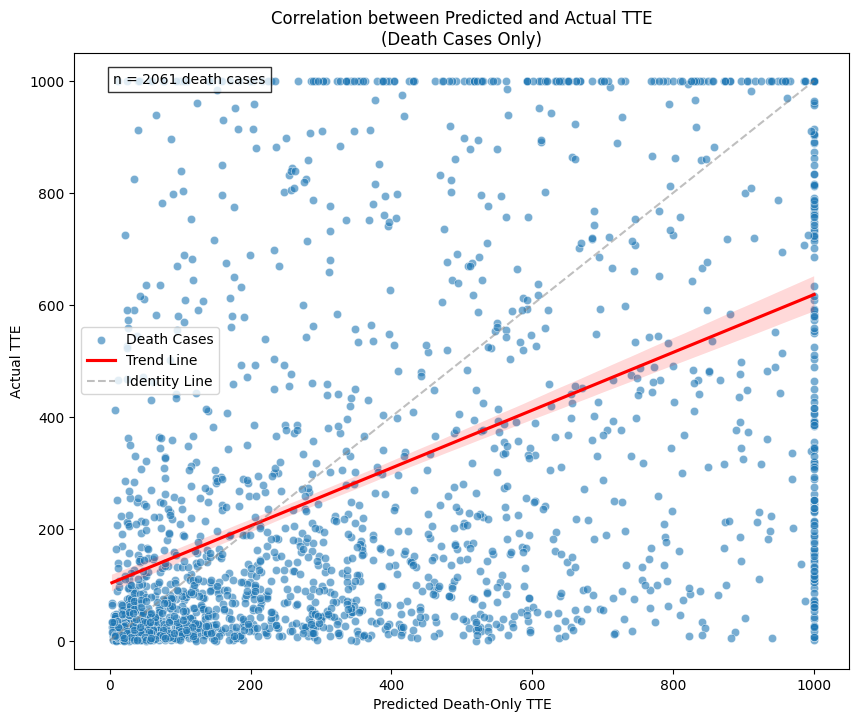


Summary statistics for death cases:

Predicted TTE:
count    2061.000000
mean      364.381876
std       329.032235
min         3.244227
25%        73.000000
50%       266.680012
75%       591.838306
max      1000.000000
Name: predicted_death_tte, dtype: float64

Actual TTE:
count    2061.000000
mean      290.055798
std       336.669362
min         0.000000
25%        29.000000
50%       130.000000
75%       462.000000
max      1000.000000
Name: tte, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Filter for death outcomes only
death_mask = real_df['outcome'] == 0
death_df = real_df[death_mask]

# Compute correlation coefficients for death cases only
pearson_corr, pearson_p = pearsonr(death_df['predicted_death_tte'], death_df['tte'])
spearman_corr, spearman_p = spearmanr(death_df['predicted_death_tte'], death_df['tte'])

print("Correlation statistics for death outcomes only:")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

# Create a scatter plot with a regression line
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=death_df,
    x='predicted_death_tte',
    y='tte',
    alpha=0.6,
    label='Death Cases'
)
sns.regplot(
    data=death_df,
    x='predicted_death_tte',
    y='tte',
    scatter=False,
    color='red',
    label='Trend Line'
)

plt.xlabel('Predicted Death-Only TTE')
plt.ylabel('Actual TTE')
plt.title('Correlation between Predicted and Actual TTE\n(Death Cases Only)')
plt.legend()

# Add number of death cases to the plot
n_deaths = len(death_df)
plt.text(
    0.05, 0.95,
    f'n = {n_deaths} death cases',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

# Optional: Add identity line (y=x) for reference
min_val = min(death_df['predicted_death_tte'].min(), death_df['tte'].min())
max_val = max(death_df['predicted_death_tte'].max(), death_df['tte'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.5, label='Identity Line')

plt.legend()
plt.show()

# Print additional statistics
print("\nSummary statistics for death cases:")
print("\nPredicted TTE:")
print(death_df['predicted_death_tte'].describe())
print("\nActual TTE:")
print(death_df['tte'].describe())

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Updated: Number of closest neighbors who died
ALPHA = 1e-6      # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average TTE based on the top TOP_K neighbors who died.
    Weights are set as 1/(distance + ALPHA). If fewer than TOP_K neighbors died,
    we use however many died. If none died, we fallback to the median TTE of all neighbors.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame of neighbor data
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter neighbors to those who died (outcome=0), then sort by distance ascending
    death_neighbors = neighbors[neighbors['outcome'] == 0].sort_values('dist')

    # Take the top TOP_K
    selected = death_neighbors.head(TOP_K)

    if len(selected) > 0:
        # Compute inverse-distance weights
        w = 1.0 / (selected['dist'] + ALPHA)
        tte = selected['tte']
        weighted_tte = (w * tte).sum() / w.sum()
        return weighted_tte
    else:
        # Fallback: if no neighbor died, use the median TTE of all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients (assumed to be available from your precomputed indices_all)
n_real = indices_all.shape[0]

# Compute the weighted TTE for each real patient in parallel with a progress bar
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: Display a sample of the predictions.
print(real_df[['predicted_death_only_tte']].head())





Computing weighted death-only TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0               1000.000000
1                187.869920
2                  8.000000
3                 46.556056
4                 30.208231


Among patients who died:
Pearson correlation between predicted TTE and actual tte: 0.4711742294119538
Spearman correlation between predicted TTE and actual tte: 0.5622756710969584


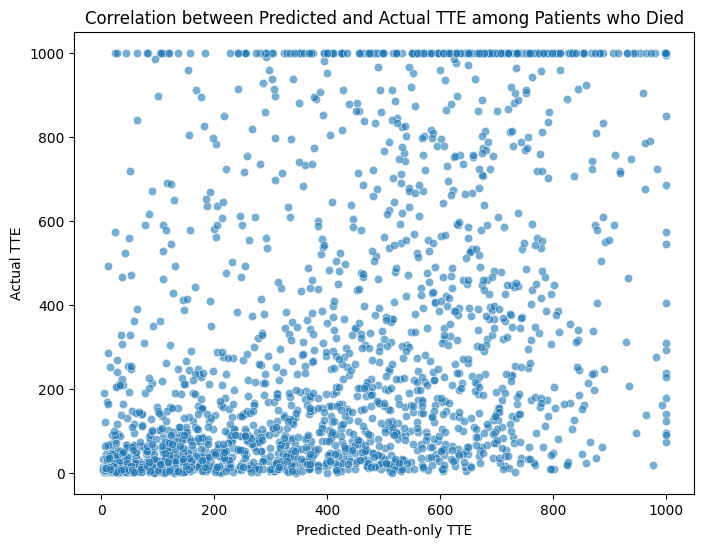

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to patients who died (assuming outcome==0 indicates death)
df_died = real_df[real_df['outcome'] == 0].copy()

# Calculate Pearson and Spearman correlations among patients who died
pearson_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='pearson')
spearman_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='spearman')

print("Among patients who died:")
print("Pearson correlation between predicted TTE and actual tte:", pearson_corr_died)
print("Spearman correlation between predicted TTE and actual tte:", spearman_corr_died)

# Create a scatter plot for patients who died
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_died['predicted_death_only_tte'], y=df_died['tte'], alpha=0.6)
plt.xlabel("Predicted Death-only TTE")
plt.ylabel("Actual TTE")
plt.title("Correlation between Predicted and Actual TTE among Patients who Died")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

def run_survival_analysis(df, time_points, max_iter=50):
    """
    Run survival analysis with enhanced performance and error handling.

    Args:
        df: DataFrame containing the data
        time_points: List of time points to analyze
        max_iter: Maximum iterations for model fitting

    Returns:
        DataFrame containing analysis results
    """
    required_cols = ['tte', 'outcome', 'predicted_death_only_tte', 'meld3']

    # Validate input data
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    hazard_results = []

    for t in time_points:
        print(f"Processing time point: {t}")  # Progress tracking

        try:
            # Prepare survival data
            analysis_df = prepare_survival_data(df, max_time=t)

            # --- Model 1: Using median_time_to_event_metric only ---
            cph_metric = CoxPHFitter()
            data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
            cph_metric.fit(data_metric,
                         duration_col='tte',
                         event_col='death_event',
                         show_progress=False,
                         max_iter=max_iter)
            c_index_metric = cph_metric.concordance_index_

            # --- Model 2: Using meld3 only ---
            cph_meld3 = CoxPHFitter()
            data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
            cph_meld3.fit(data_meld3,
                         duration_col='tte',
                         event_col='death_event',
                         show_progress=False,
                         max_iter=max_iter)
            c_index_meld3 = cph_meld3.concordance_index_

            # --- Model 3: Combined model using both predictors ---
            cph_combined = CoxPHFitter()
            data_combined = analysis_df[['tte', 'death_event',
                                       'predicted_death_only_tte', 'meld3']].copy()
            cph_combined.fit(data_combined,
                           duration_col='tte',
                           event_col='death_event',
                           show_progress=False,
                           max_iter=max_iter)
            c_index_combined = cph_combined.concordance_index_

            # Extract coefficients and p-values from summary
            summary = cph_combined.summary

            hazard_results.append({
                'Time': t,
                'c_index_metric': c_index_metric,
                'c_index_meld3': c_index_meld3,
                'c_index_combined': c_index_combined,
                'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
                'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
                'p_metric': summary.loc['predicted_death_only_tte', 'p'],
                'p_meld3': summary.loc['meld3', 'p']
            })

        except Exception as e:
            print(f"Error at time point {t}: {str(e)}")
            continue

    if not hazard_results:
        raise ValueError("No results were generated. Check your input data and parameters.")

    return pd.DataFrame(hazard_results)

def print_results(results_df):
    """
    Print formatted analysis results.

    Args:
        results_df: DataFrame containing analysis results
    """
    print("\nComparison of Concordance Indices:")
    print(results_df[['Time', 'c_index_metric', 'c_index_meld3',
                     'c_index_combined']].round(3))
    print("\nHazard Ratios and P-values from Combined Model:")
    print(results_df[['Time', 'hr_metric', 'hr_meld3',
                     'p_metric', 'p_meld3']].round(3))

# Example usage:
# Define time points (e.g., every 30 days up to 360 days)
# time_points = np.arange(30, 361, 30)

# Run analysis with error handling
def main(df, time_points):
    """
    Main function to run the analysis with error handling.

    Args:
        df: Input DataFrame
        time_points: List of time points to analyze
    """
    try:
        results_df = run_survival_analysis(df, time_points, max_iter=50)
        print_results(results_df)
        return results_df
    except Exception as e:
        print(f"Analysis failed: {str(e)}")
        return None

In [ ]:
# Define time points
time_points = [7, 14, 30, 90, 180, 360]

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_death_only_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event',
                                'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte',
                    event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results in a formatted way
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.708          0.894             0.895
1    14           0.695          0.874             0.874
2    30           0.676          0.859             0.859
3    90           0.654          0.824             0.826
4   180           0.644          0.803             0.804
5   360           0.639          0.784             0.786

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.999     1.148     0.002      0.0
1    14      0.999     1.145     0.000      0.0
2    30      0.999     1.139     0.000      0.0
3    90      0.999     1.123     0.000      0.0
4   180      0.999     1.113     0.000      0.0
5   360      0.999     1.103     0.000      0.0


Weighted

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 100       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               883.523324
1               550.669953
2               686.759871
3               120.748410
4                55.891400


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 30       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               253.816832
1               264.468979
2               271.384518
3                29.864591
4                15.920428


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.877          0.894             0.911
1    14           0.869          0.874             0.896
2    30           0.861          0.859             0.886
3    90           0.855          0.824             0.869
4   180           0.851          0.803             0.860
5   360           0.853          0.784             0.856

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.991     1.116       0.0      0.0
1    14      0.991     1.113       0.0      0.0
2    30      0.992     1.106       0.0      0.0
3    90      0.991     1.089       0.0      0.0
4   180      0.991     1.077       0.0      0.0
5   360      0.990     1.063       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0               157.791256
1               196.335301
2               190.917674
3                13.758004
4                 5.253261


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.880          0.894             0.913
1    14           0.871          0.874             0.897
2    30           0.862          0.859             0.887
3    90           0.856          0.824             0.871
4   180           0.852          0.803             0.861
5   360           0.853          0.784             0.857

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.985     1.114       0.0      0.0
1    14      0.987     1.112       0.0      0.0
2    30      0.987     1.106       0.0      0.0
3    90      0.987     1.089       0.0      0.0
4   180      0.986     1.077       0.0      0.0
5   360      0.985     1.064       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())




Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_composite_tte
0                71.396196
1               110.066001
2                97.558020
3                 5.211409
4                 3.020823


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.875          0.894             0.912
1    14           0.866          0.874             0.896
2    30           0.855          0.859             0.883
3    90           0.851          0.824             0.869
4   180           0.847          0.803             0.859
5   360           0.848          0.784             0.855

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.972     1.117       0.0      0.0
1    14      0.975     1.114       0.0      0.0
2    30      0.976     1.109       0.0      0.0
3    90      0.974     1.091       0.0      0.0
4   180      0.974     1.079       0.0      0.0
5   360      0.972     1.066       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation.

    Args:
        df: DataFrame with tte, outcome, and predictors
        time_point: Time point for analysis

    Returns:
        DataFrame with binary outcome for the specific time point
    """
    # Create binary outcome (death/transplant = 1, waiting = 0)
    mask_event = (df['outcome'].isin([0, 2]))  # death or transplant

    # For the specific time point:
    # - Event = 1 if event happened before time_point
    # - Event = 0 if subject survived past time_point
    # - Exclude if censored before time_point
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_event) & (time_mask)).astype(int)

    # Create analysis dataset
    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    # Only include patients who either:
    # 1) Had an event by time_point
    # 2) Were followed for at least time_point days
    include_mask = (mask_event & time_mask) | (df['tte'] >= time_point)

    return analysis_df[include_mask]

# Define time points
time_points = [7, 14, 30, 90, 180, 360]

# Store results
auc_results = []

# Calculate AUC for each time point
for t in time_points:
    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    # Calculate AUCs if we have both events and non-events
    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        # Calculate individual AUCs
        auc_meld = roc_auc_score(analysis_df['binary_outcome'], analysis_df['meld3'])
        # Flip sign for predicted_composite_tte since lower values indicate higher risk
        auc_pred = roc_auc_score(analysis_df['binary_outcome'], -analysis_df['predicted_composite_tte'])

        # Calculate combined model AUC using logistic regression predictions
        from sklearn.linear_model import LogisticRegression
        # Use negative of predicted_composite_tte
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })
        y = analysis_df['binary_outcome']

        # Fit logistic regression and get predictions
        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        auc_combined = roc_auc_score(y, combined_preds)

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

# Convert to DataFrame and display results
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results:")
print(results_df.round(3))


Time-dependent AUC Results:
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       9389       572      0.798          0.896         0.897
1    14       9362       907      0.836          0.914         0.916
2    30       9299      1375      0.845          0.923         0.926
3    90       9071      2148      0.829          0.932         0.934
4   180       8734      2725      0.814          0.940         0.941
5   360       8145      3263      0.800          0.955         0.954


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation for mortality prediction.

    Args:
        df: DataFrame with tte, outcome, and predictors
        time_point: Time point for analysis

    Returns:
        DataFrame with binary outcome for the specific time point
    """
    # Create binary outcome (death = 1, alive = 0)
    mask_death = (df['outcome'] == 0)  # death only

    # For the specific time point:
    # - Event = 1 if death happened before time_point
    # - Event = 0 if subject survived past time_point
    # - Exclude if transplanted or censored before time_point
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_death) & (time_mask)).astype(int)

    # Create analysis dataset
    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    # Only include patients who either:
    # 1) Died by time_point
    # 2) Were followed for at least time_point days
    # 3) Exclude those who got transplant before time_point
    transplant_mask = (df['outcome'] == 2) & (df['tte'] <= time_point)
    include_mask = ((mask_death & time_mask) | (df['tte'] >= time_point)) & ~transplant_mask

    return analysis_df[include_mask]

# Define time points
time_points = [7, 14, 30, 90, 180, 360]

# Store results
auc_results = []

# Calculate AUC for each time point
for t in time_points:
    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    # Calculate AUCs if we have both events and non-events
    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        # Calculate individual AUCs
        auc_meld = roc_auc_score(analysis_df['binary_outcome'], analysis_df['meld3'])
        # Flip sign for predicted_composite_tte since lower values indicate higher risk
        auc_pred = roc_auc_score(analysis_df['binary_outcome'], -analysis_df['predicted_composite_tte'])

        # Calculate combined model AUC using logistic regression predictions
        from sklearn.linear_model import LogisticRegression
        # Use negative of predicted_composite_tte
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })
        y = analysis_df['binary_outcome']

        # Fit logistic regression and get predictions
        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        auc_combined = roc_auc_score(y, combined_preds)

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

# Convert to DataFrame and display results
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results (Mortality):")
print(results_df.round(3))


Time-dependent AUC Results (Mortality):
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       8973       156      0.902          0.892         0.922
1    14       8770       315      0.887          0.891         0.912
2    30       8455       531      0.877          0.891         0.909
3    90       7824       901      0.845          0.900         0.906
4   180       7179      1170      0.824          0.909         0.911
5   360       6328      1446      0.803          0.927         0.927


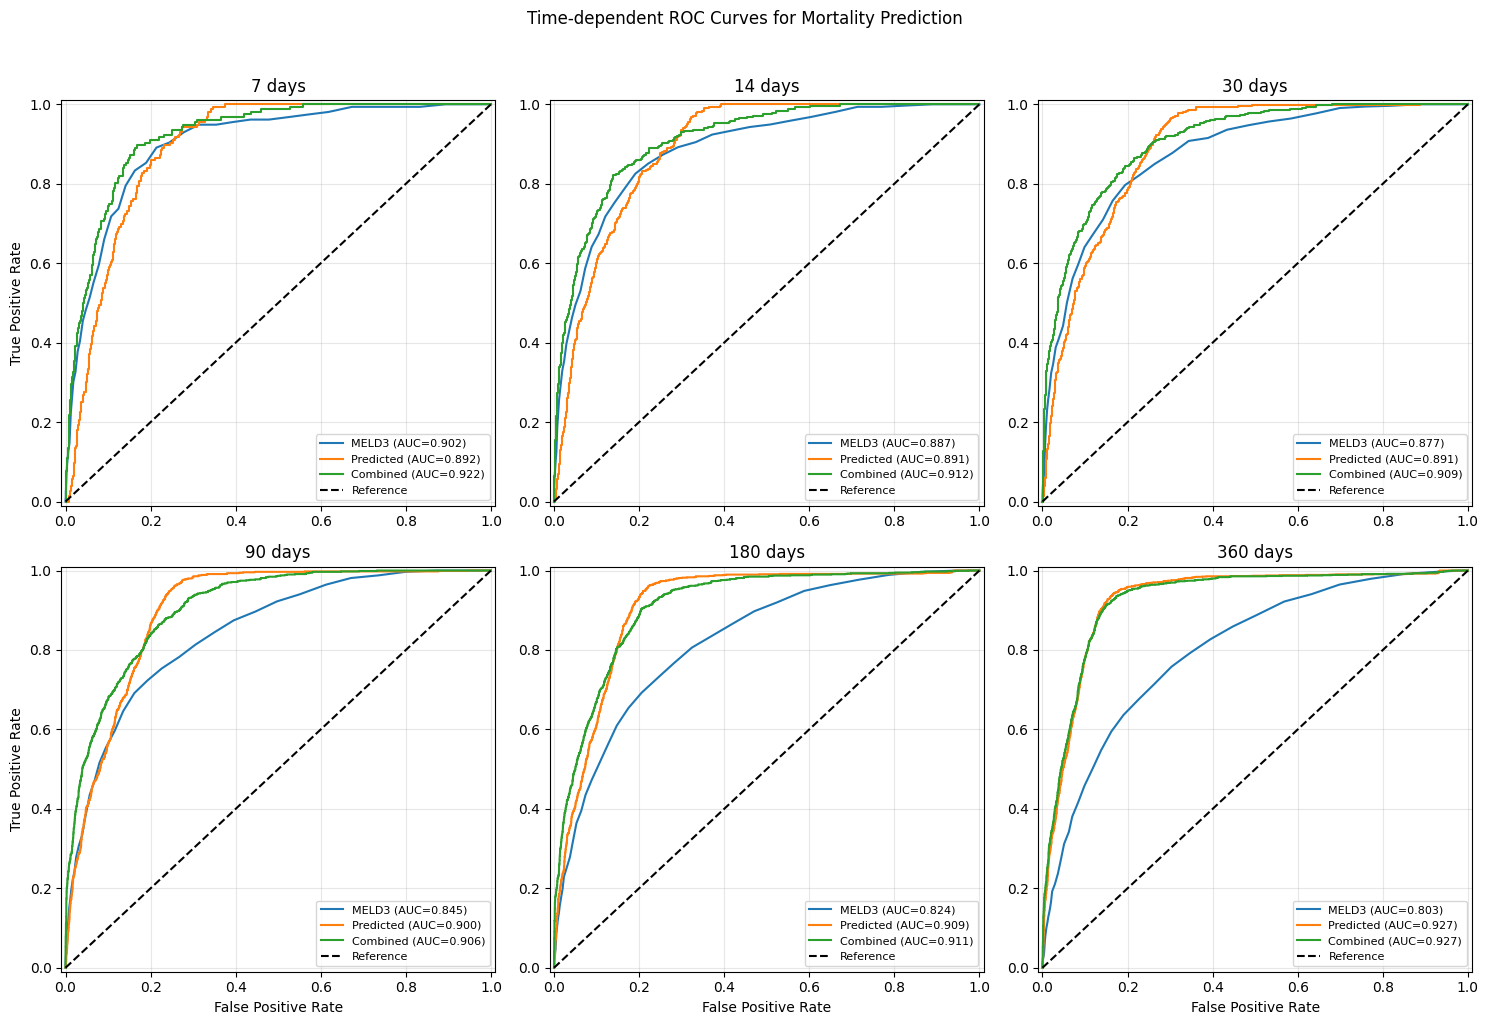


Time-dependent AUC Results (Mortality):
   Time  N_samples  N_events  AUC_MELD3  AUC_predicted  AUC_combined
0     7       8973       156      0.902          0.892         0.922
1    14       8770       315      0.887          0.891         0.912
2    30       8455       531      0.877          0.891         0.909
3    90       7824       901      0.845          0.900         0.906
4   180       7179      1170      0.824          0.909         0.911
5   360       6328      1446      0.803          0.927         0.927


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def prepare_data_for_time_auc(df, time_point):
    """
    Prepare data for time-dependent AUC calculation for mortality prediction.
    """
    mask_death = (df['outcome'] == 0)  # death only
    time_mask = df['tte'] <= time_point
    binary_outcome = ((mask_death) & (time_mask)).astype(int)

    analysis_df = df.copy()
    analysis_df['binary_outcome'] = binary_outcome

    transplant_mask = (df['outcome'] == 2) & (df['tte'] <= time_point)
    include_mask = ((mask_death & time_mask) | (df['tte'] >= time_point)) & ~transplant_mask

    return analysis_df[include_mask]

# Define time points and colors
time_points = [7, 14, 30, 90, 180, 360]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Store results
auc_results = []

# Calculate AUC and ROC curves for each time point
for i, t in enumerate(time_points):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Prepare data for this time point
    analysis_df = prepare_data_for_time_auc(real_df, t)

    if (analysis_df['binary_outcome'].sum() > 0 and
        (len(analysis_df) - analysis_df['binary_outcome'].sum()) > 0):

        y = analysis_df['binary_outcome']

        # MELD3
        fpr_meld, tpr_meld, _ = roc_curve(y, analysis_df['meld3'])
        auc_meld = roc_auc_score(y, analysis_df['meld3'])

        # Predicted TTE
        fpr_pred, tpr_pred, _ = roc_curve(y, -analysis_df['predicted_composite_tte'])
        auc_pred = roc_auc_score(y, -analysis_df['predicted_composite_tte'])

        # Combined
        X_combined = pd.DataFrame({
            'meld3': analysis_df['meld3'],
            'predicted_tte': -analysis_df['predicted_composite_tte']
        })

        lr = LogisticRegression(random_state=42)
        lr.fit(X_combined, y)
        combined_preds = lr.predict_proba(X_combined)[:, 1]
        fpr_comb, tpr_comb, _ = roc_curve(y, combined_preds)
        auc_combined = roc_auc_score(y, combined_preds)

        # Plot ROC curves
        ax.plot(fpr_meld, tpr_meld, color=colors[0],
                label=f'MELD3 (AUC={auc_meld:.3f})')
        ax.plot(fpr_pred, tpr_pred, color=colors[1],
                label=f'Predicted (AUC={auc_pred:.3f})')
        ax.plot(fpr_comb, tpr_comb, color=colors[2],
                label=f'Combined (AUC={auc_combined:.3f})')

        # Add diagonal reference line
        ax.plot([0, 1], [0, 1], 'k--', label='Reference')

        # Store results
        auc_results.append({
            'Time': t,
            'N_samples': len(analysis_df),
            'N_events': analysis_df['binary_outcome'].sum(),
            'AUC_MELD3': auc_meld,
            'AUC_predicted': auc_pred,
            'AUC_combined': auc_combined
        })

    # Customize subplot
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_title(f'{t} days')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=8)

    # Only add axis labels for edge subplots
    if row == 1:
        ax.set_xlabel('False Positive Rate')
    if col == 0:
        ax.set_ylabel('True Positive Rate')

# Add overall title
fig.suptitle('Time-dependent ROC Curves for Mortality Prediction', y=1.02)

# Adjust layout and save
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print AUC results table
results_df = pd.DataFrame(auc_results)
print("\nTime-dependent AUC Results (Mortality):")
print(results_df.round(3))

Weighted Composite Outcome

In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())


Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0                 71.396196
1                107.485078
2                 97.398020
3                  5.211409
4                  3.020823


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 20       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())



Computing composite weighted TTE:   0%|          | 0/9395 [00:00<?, ?it/s]

  0%|          | 0/9395 [00:00<?, ?it/s]

Computing composite weighted TTE:   0%|          | 0/9395 [01:26<?, ?it/s]


   predicted_death_only_tte
0                157.791256
1                194.033901
2                190.918711
3                 13.758004
4                  5.253261


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.877          0.894             0.911
1    14           0.869          0.874             0.896
2    30           0.861          0.859             0.886
3    90           0.855          0.824             0.869
4   180           0.851          0.803             0.860
5   360           0.853          0.784             0.856

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.991     1.116       0.0      0.0
1    14      0.991     1.113       0.0      0.0
2    30      0.992     1.106       0.0      0.0
3    90      0.991     1.089       0.0      0.0
4   180      0.991     1.077       0.0      0.0
5   360      0.990     1.063       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Use the 30 closest neighbors
ALPHA = 1e-6     # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    Groups are:
      - Group 0: death or transplant (outcomes 0 or 2)
      - Group 1: waiting (outcome 1)
    The final predicted tte is the sum of each group's (weighted average tte × proportion).
    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Create binary grouping: death/transplant (0) vs waiting (1)
    neighbors['binary_outcome'] = (neighbors['outcome'] == 1).astype(int)

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over binary outcomes: 0 (death/transplant) and 1 (waiting)
    for outcome in [0, 1]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['binary_outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute
            composite_tte += 0.0

    return composite_tte

# Number of real patients
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample of the predictions
print(real_df[['predicted_death_only_tte']].head())




Computing composite weighted TTE:   0%|          | 0/9395 [03:12<?, ?it/s]


  0%|          | 0/9395 [00:00<?, ?it/s]

   predicted_death_only_tte
0                444.605218
1                430.463520
2                419.906647
3                 46.590763
4                 29.119808


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.881          0.894             0.908
1    14           0.869          0.874             0.893
2    30           0.859          0.859             0.881
3    90           0.842          0.824             0.858
4   180           0.832          0.803             0.843
5   360           0.828          0.784             0.833

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.997     1.113       0.0      0.0
1    14      0.997     1.110       0.0      0.0
2    30      0.997     1.103       0.0      0.0
3    90      0.997     1.088       0.0      0.0
4   180      0.997     1.077       0.0      0.0
5   360      0.997     1.065       0.0      0.0


In [ ]:
# Assume syn_embeddings and real_embeddings have been computed already.
print("Synthetic embeddings shape:", syn_embeddings.shape)
print("Real embeddings shape:", real_embeddings.shape)

# Create separate indices for each outcome group in synthetic data
syn_indices_by_outcome = {}
for outcome in ['0', '1', '2']:
    indices = np.where(syn_df_processed['outcome'].astype(str) == outcome)[0]
    syn_indices_by_outcome[outcome] = indices
    print(f"Outcome {outcome} has {len(indices)} synthetic samples")

# Set number of neighbors to retrieve
n_neighbors = 100

# Initialize arrays to store results for all real patients
distances_metric = np.zeros((len(real_df), n_neighbors))
indices_metric = np.zeros((len(real_df), n_neighbors), dtype=int)

# Process each outcome group separately
for outcome in ['0', '1', '2']:
    # Get indices of real patients with this outcome
    real_outcome_mask = real_df['outcome'].astype(str) == outcome
    real_indices = np.where(real_outcome_mask)[0]

    if len(real_indices) == 0:
        continue  # Skip if no real patient with this outcome

    # Retrieve embeddings for these real patients and the corresponding synthetic ones
    real_outcome_embeddings = real_embeddings[real_indices]
    syn_outcome_embeddings = syn_embeddings[syn_indices_by_outcome[outcome]]

    # Fit and perform nearest neighbor search for this outcome group
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
    nbrs.fit(syn_outcome_embeddings)
    distances, indices = nbrs.kneighbors(real_outcome_embeddings)

    # Map neighbor indices back to the original synthetic dataset indices
    indices = syn_indices_by_outcome[outcome][indices]

    # Store the computed distances and indices for these real patients
    distances_metric[real_indices] = distances
    indices_metric[real_indices] = indices

print("Nearest neighbor search complete. indices_metric shape:", indices_metric.shape)

# Define syn_target from synthetic dataframe (adjust the column name if needed)
syn_target = syn_df_processed['tte'].values

# Compute the median time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []
for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)
median_time_array_metric = np.array(median_time_list_metric)

# Add predicted median time-to-event to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric

print("\nSample real data with actual vs. predicted time-to-event:")
print(real_df[['outcome', 'time_to_event', 'median_time_to_event_metric']].head())


Synthetic embeddings shape: (10000000, 64)
Real embeddings shape: (9395, 64)
Outcome 0 has 1620302 synthetic samples
Outcome 1 has 2280287 synthetic samples
Outcome 2 has 6099411 synthetic samples
Nearest neighbor search complete. indices_metric shape: (9395, 100)

Sample real data with actual vs. predicted time-to-event:
   outcome  time_to_event  median_time_to_event_metric
0        1           2490                  1584.822266
1        1           2330                  1177.796536
2        1           1280                  1914.089866
3        2            264                    61.816364
4        0             36                    36.000000


In [ ]:
# # Calculate the difference between median prediction and actual time
# real_df['tte_difference'] = real_df['median_time_to_event_metric'] - real_df['time_to_event']

# # Create boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(y='tte_difference', data=real_df)

# # Add a horizontal line at y=0 (where prediction matches actual)
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# # Customize the plot
# plt.title('Distribution of Differences Between Predicted and Actual Time to Event')
# plt.ylabel('Difference in Days (Predicted - Actual)')

# # Add text for median and IQR
# median_diff = real_df['tte_difference'].median()
# q1 = real_df['tte_difference'].quantile(0.25)
# q3 = real_df['tte_difference'].quantile(0.75)

# plt.text(0.02, 0.98, f'Median: {median_diff:.1f} days\nIQR: [{q1:.1f}, {q3:.1f}]',
#         transform=plt.gca().transAxes, verticalalignment='top')

# plt.show()

# # Print summary statistics
# print("\nSummary Statistics of Time Differences:")
# print(real_df['tte_difference'].describe())

In [ ]:
# Previous code remains the same up until after indices_metric computation...
from scipy import stats
# Compute both median and mode time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []

for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]

    # Calculate median
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)


median_time_array_metric = np.array(median_time_list_metric)


# Add both predicted times to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric


print("\nSample real data with actual vs. predicted times:")
print(real_df[['outcome', 'time_to_event',
               'median_time_to_event_metric']].head())


Sample real data with actual vs. predicted times:
   outcome  time_to_event  median_time_to_event_metric
0        1           2490                  1584.822266
1        1           2330                  1177.796536
2        1           1280                  1914.089866
3        2            264                    61.816364
4        0             36                    36.000000


In [ ]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['INIT_AGENDER'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['INIT_BILIRUBIN'])
    sodium = min(137, max(125, row['INIT_SERUM_SODIUM']))
    inr = max(1.0, row['INIT_INR'])
    creatinine = min(3.0, max(1.0, row['INIT_SERUM_CREAT']))
    albumin = min(3.5, max(1.5, row['INIT_ALBUMIN']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Calculate MELD3 for both dataframes
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)


# Display sample results for verification
print("\nMayo DF sample:")
print(real_df[['INIT_AGENDER', 'INIT_BILIRUBIN', 'INIT_SERUM_SODIUM', 'INIT_INR',
               'INIT_SERUM_CREAT', 'INIT_ALBUMIN', 'meld3']].head())




Mayo DF sample:
  INIT_AGENDER  INIT_BILIRUBIN  INIT_SERUM_SODIUM  INIT_INR  INIT_SERUM_CREAT  \
0            M             0.7              141.0       1.1              2.00   
1            F             1.9              140.0       3.2              0.83   
2            F             0.3              140.0       1.0              0.81   
3            M             3.7              136.0       1.7              1.11   
4            F            10.1              133.0       4.4              1.04   

   INIT_ALBUMIN  meld3  
0           3.8     15  
1           4.1     21  
2           4.2      7  
3           4.8     18  
4           2.5     35  


In [ ]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['time_to_event'] > max_time
        analysis_df.loc[mask, 'time_to_event'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using median_time_to_event_metric only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['time_to_event', 'death_event', 'median_time_to_event_metric']].copy()
    cph_metric.fit(data_metric, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event', 'death_event',
                                'median_time_to_event_metric', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results in a formatted way
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.879          0.894             0.922
1    14           0.873          0.874             0.912
2    30           0.870          0.859             0.906
3    90           0.866          0.824             0.897
4   180           0.867          0.803             0.894
5   360           0.872          0.784             0.895

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.998     1.121       0.0      0.0
1    14      0.998     1.115       0.0      0.0
2    30      0.998     1.108       0.0      0.0
3    90      0.998     1.093       0.0      0.0
4   180      0.998     1.080       0.0      0.0
5   360      0.998     1.067       0.0      0.0


In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.utils import resample
from scipy import stats

def harrells_c_competing_risks_fast(time, event, predictor):
    """
    Vectorized calculation of Harrell's C-index for competing risks.
    Event coding:
    0 = death (event of interest)
    1 = still waiting (censored)
    2 = transplant (competing event)
    """
    n = len(time)

    # Create masks for event types
    death_mask = (event == 0)
    transplant_mask = (event == 2)

    # Only consider cases that had death or are censored (exclude transplants)
    valid_cases = ~transplant_mask

    # Get indices of valid cases
    valid_indices = np.where(valid_cases)[0]

    if len(valid_indices) == 0:
        return np.nan

    # Create matrices for valid cases
    time_mat = time[valid_indices]
    death_mat = death_mask[valid_indices]
    pred_mat = predictor[valid_indices]

    # Create comparison matrices
    time_1 = time_mat[:, np.newaxis]  # column vector
    time_2 = time_mat[np.newaxis, :]  # row vector

    death_1 = death_mat[:, np.newaxis]

    pred_1 = pred_mat[:, np.newaxis]
    pred_2 = pred_mat[np.newaxis, :]

    # Find comparable pairs (shorter time had the event)
    comparable = (time_1 < time_2) & death_1

    # Calculate concordance for comparable pairs
    concordant = (pred_1 > pred_2) & comparable
    discordant = (pred_1 < pred_2) & comparable

    # Sum up concordant and discordant pairs
    n_concordant = np.sum(concordant)
    n_discordant = np.sum(discordant)

    total = n_concordant + n_discordant

    if total == 0:
        return np.nan

    return n_concordant / total

def bootstrap_c_index_difference_harrells(data, n_bootstrap=1000):
    """
    Calculate confidence intervals and p-value for Harrell's c-index difference using bootstrapping.
    """
    bootstrap_diffs = []

    for _ in range(n_bootstrap):
        # Generate bootstrap sample
        boot_indices = resample(np.arange(len(data)))
        boot_data = data.iloc[boot_indices]

        # Calculate c-index for combined model
        combined_risk = (boot_data['median_time_to_event_metric'].values +
                        boot_data['meld3'].values) / 2
        c_combined = harrells_c_competing_risks_fast(
            boot_data['time_to_event'].values,
            boot_data['outcome'].values,
            combined_risk
        )

        # Calculate c-index for MELD3 only
        c_meld3 = harrells_c_competing_risks_fast(
            boot_data['time_to_event'].values,
            boot_data['outcome'].values,
            boot_data['meld3'].values
        )

        # Calculate difference
        diff = c_combined - c_meld3
        bootstrap_diffs.append(diff)

    # Calculate confidence intervals and p-value
    ci_lower, ci_upper = np.percentile(bootstrap_diffs, [2.5, 97.5])
    p_value = 2 * min(
        np.mean(np.array(bootstrap_diffs) <= 0),
        np.mean(np.array(bootstrap_diffs) >= 0)
    )

    return np.mean(bootstrap_diffs), ci_lower, ci_upper, p_value

# Main analysis
hazard_results = []

for t in time_points:
    # Subset data to time point
    analysis_df = real_df.copy()
    if t is not None:
        mask = analysis_df['time_to_event'] > t
        analysis_df.loc[mask, 'time_to_event'] = t
        analysis_df.loc[mask, 'outcome'] = 1  # still waiting

    # Calculate Harrell's C-index for each model
    c_index_metric = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['median_time_to_event_metric'].values
    )

    c_index_meld3 = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['meld3'].values
    )

    # Combined risk score
    combined_risk = (analysis_df['median_time_to_event_metric'].values +
                    analysis_df['meld3'].values) / 2
    c_index_combined = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk
    )

    # Calculate confidence intervals and p-value for c-index difference
    diff, ci_lower, ci_upper, p_value = bootstrap_c_index_difference_harrells(analysis_df)

    # Fit Cox model for hazard ratios (death only)
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event', 'outcome',
                                'median_time_to_event_metric', 'meld3']].copy()
    data_combined['death_event'] = (data_combined['outcome'] == 0).astype(int)
    data_combined = data_combined[data_combined['outcome'] != 2]

    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)

    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'c_index_diff': diff,
        'c_index_diff_ci_lower': ci_lower,
        'c_index_diff_ci_upper': ci_upper,
        'c_index_diff_p': p_value,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results
print("\nComparison of Harrell's C-indices for Competing Risks:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))

print("\nC-Index Difference Analysis (Combined vs. MELD3):")
print(results_df[['Time', 'c_index_diff', 'c_index_diff_ci_lower',
                  'c_index_diff_ci_upper', 'c_index_diff_p']].round(3))

print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column outcome have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death_event'].astype(bool)
>>> print(df.loc[events, 'outcome'].var())
>>> print(df.loc[~events, 'outcome'].var())

A very low variance means that the column outcome completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.131. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separatio

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from scipy import stats

def harrells_c_competing_risks_fast(time, event, predictor, return_variance=False):
    """
    Vectorized calculation of Harrell's C-index for competing risks with optional variance.
    Event coding:
    0 = death (event of interest)
    1 = still waiting (censored)
    2 = transplant (competing event)
    """
    n = len(time)

    # Create masks for event types
    death_mask = (event == 0)
    transplant_mask = (event == 2)

    # Only consider cases that had death or are censored (exclude transplants)
    valid_cases = ~transplant_mask

    # Get indices of valid cases
    valid_indices = np.where(valid_cases)[0]

    if len(valid_indices) == 0:
        return (np.nan, np.nan) if return_variance else np.nan

    # Create matrices for valid cases
    time_mat = time[valid_indices]
    death_mat = death_mask[valid_indices]
    pred_mat = predictor[valid_indices]

    # Create comparison matrices
    time_1 = time_mat[:, np.newaxis]  # column vector
    time_2 = time_mat[np.newaxis, :]  # row vector

    death_1 = death_mat[:, np.newaxis]

    pred_1 = pred_mat[:, np.newaxis]
    pred_2 = pred_mat[np.newaxis, :]

    # Find comparable pairs (shorter time had the event)
    comparable = (time_1 < time_2) & death_1

    # Calculate concordance for comparable pairs
    concordant = (pred_1 > pred_2) & comparable
    discordant = (pred_1 < pred_2) & comparable

    # Sum up concordant and discordant pairs
    n_concordant = np.sum(concordant)
    n_discordant = np.sum(discordant)

    total = n_concordant + n_discordant

    if total == 0:
        return (np.nan, np.nan) if return_variance else np.nan

    c_index = n_concordant / total

    if not return_variance:
        return c_index

    # Calculate variance using modified U-statistics approach
    n_subjects = len(valid_indices)
    n_events = np.sum(death_mat)

    # Calculate variance accounting for correlation structure
    variance = (c_index * (1 - c_index)) * (2 * (n_subjects - 1)) / (n_events * (n_subjects - 2))

    # Add correction factor for competing risks
    competing_proportion = np.mean(transplant_mask)
    variance = variance * (1 + competing_proportion)

    return c_index, variance

def compare_c_indices(time, event, pred1, pred2):
    """
    Compare two C-indices using analytical method.
    Returns difference, standard error, and p-value.
    """
    # Calculate C-indices and their variances
    c1, var1 = harrells_c_competing_risks_fast(time, event, pred1, return_variance=True)
    c2, var2 = harrells_c_competing_risks_fast(time, event, pred2, return_variance=True)

    # Calculate difference
    diff = c1 - c2

    # Calculate standard error of difference
    se = np.sqrt(var1 + var2)

    # Calculate z-score
    z_score = diff / se

    # Calculate two-sided p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

    # Calculate 95% CI
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se

    return diff, ci_lower, ci_upper, p_value

# Main analysis
hazard_results = []

for t in time_points:
    # Subset data to time point
    analysis_df = real_df.copy()
    if t is not None:
        mask = analysis_df['time_to_event'] > t
        analysis_df.loc[mask, 'time_to_event'] = t
        analysis_df.loc[mask, 'outcome'] = 1  # still waiting

    # Calculate Harrell's C-index for each model
    # Negative sign for metric because lower times indicate higher risk
    c_index_metric = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        -analysis_df['median_time_to_event_metric'].values  # Negative to flip risk direction
    )

    c_index_meld3 = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        analysis_df['meld3'].values  # Higher MELD3 already indicates higher risk
    )

    # Combined risk score (negative for metric, positive for MELD3)
    combined_risk = (-analysis_df['median_time_to_event_metric'].values +
                    analysis_df['meld3'].values) / 2
    c_index_combined = harrells_c_competing_risks_fast(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk
    )

    # Calculate analytical comparison between combined and MELD3
    diff, ci_lower, ci_upper, p_value = compare_c_indices(
        analysis_df['time_to_event'].values,
        analysis_df['outcome'].values,
        combined_risk,
        analysis_df['meld3'].values
    )

    # Fit Cox model for hazard ratios (death only)
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event',
                                'median_time_to_event_metric', 'meld3']].copy()
    data_combined['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    mask_no_transplant = analysis_df['outcome'] != 2
    data_combined = data_combined[mask_no_transplant]

    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)

    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'c_index_diff': diff,
        'c_index_diff_ci_lower': ci_lower,
        'c_index_diff_ci_upper': ci_upper,
        'c_index_diff_p': p_value,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results
print("\nComparison of Harrell's C-indices for Competing Risks:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))

print("\nC-Index Difference Analysis (Combined vs. MELD3):")
print(results_df[['Time', 'c_index_diff', 'c_index_diff_ci_lower',
                  'c_index_diff_ci_upper', 'c_index_diff_p']].round(3))

print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Harrell's C-indices for Competing Risks:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.884          0.897             0.896
1    14           0.889          0.888             0.898
2    30           0.893          0.876             0.898
3    90           0.898          0.841             0.901
4   180           0.911          0.820             0.913
5   360           0.928          0.801             0.929

C-Index Difference Analysis (Combined vs. MELD3):
   Time  c_index_diff  c_index_diff_ci_lower  c_index_diff_ci_upper  \
0     7        -0.002                 -0.099                  0.096   
1    14         0.010                 -0.060                  0.081   
2    30         0.023                 -0.034                  0.079   
3    90         0.060                  0.013                  0.106   
4   180         0.092                  0.050                  0.134   
5   360         0.128                  0.090                  0.165 

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd

def prepare_competing_risk_data(df, max_time=None):
    """
    Prepare data for competing risks analysis

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        Two DataFrames: one for death analysis, one for transplant analysis
    """
    analysis_df = df.copy()

    # For death analysis (event=0)
    death_df = analysis_df.copy()
    death_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # For transplant analysis (event=2)
    transplant_df = analysis_df.copy()
    transplant_df['event'] = (analysis_df['outcome'] == 2).astype(int)

    # Apply max_time if specified
    if max_time is not None:
        for df in [death_df, transplant_df]:
            mask = df['time_to_event'] > max_time
            df.loc[mask, 'time_to_event'] = max_time
            df.loc[mask, 'event'] = 0

    return death_df, transplant_df

def calculate_competing_risk_cindices(death_df, transplant_df):
    """
    Calculate c-indices for competing risks models
    Returns c-indices for both death and transplant predictions
    """
    results = {}

    # For death prediction
    for name, data in [
        ('metric_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_death', death_df[['time_to_event', 'event', 'meld3']]),
        ('combined_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    # For transplant prediction
    for name, data in [
        ('metric_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_tx', transplant_df[['time_to_event', 'event', 'meld3']]),
        ('combined_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    return results

# Run analysis for each time point
competing_risk_results = []

for t in time_points:
    print(f"\nAnalyzing time point: {t}")

    # Prepare data
    death_df, transplant_df = prepare_competing_risk_data(real_df, max_time=t)

    # Calculate c-indices
    indices = calculate_competing_risk_cindices(death_df, transplant_df)

    # Add number of events
    n_deaths = death_df['event'].sum()
    n_transplants = transplant_df['event'].sum()

    # Store results
    result = {
        'Time': t,
        'n_deaths': n_deaths,
        'n_transplants': n_transplants
    }
    result.update(indices)
    competing_risk_results.append(result)

# Convert to DataFrame and display results
results_df = pd.DataFrame(competing_risk_results)

# Print formatted results
print("\nDeath Prediction C-indices:")
print(results_df[['Time', 'n_deaths', 'metric_death', 'meld3_death', 'combined_death']].round(3))
print("\nTransplant Prediction C-indices:")
print(results_df[['Time', 'n_transplants', 'metric_tx', 'meld3_tx', 'combined_tx']].round(3))


Analyzing time point: 7

Analyzing time point: 14

Analyzing time point: 30

Analyzing time point: 90

Analyzing time point: 180

Analyzing time point: 360

Death Prediction C-indices:
   Time  n_deaths  metric_death  meld3_death  combined_death
0     7       156         0.879        0.894           0.922
1    14       315         0.873        0.874           0.912
2    30       531         0.870        0.859           0.906
3    90       901         0.866        0.824           0.897
4   180      1170         0.867        0.803           0.894
5   360      1446         0.872        0.784           0.895

Transplant Prediction C-indices:
   Time  n_transplants  metric_tx  meld3_tx  combined_tx
0     7            416      0.889     0.745        0.894
1    14            592      0.907     0.783        0.906
2    30            844      0.917     0.792        0.917
3    90           1247      0.923     0.780        0.922
4   180           1555      0.927     0.768        0.926
5   360    

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -(df['median_time_to_event_metric'] * cph.params_['median_time_to_event_metric'] +
                df['meld3'] * cph.params_['meld3'])

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs combined model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    combined_pred = get_model_predictions(df, 'combined')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_combined = concordance_index(
        df['time_to_event'],
        combined_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['time_to_event'],
            combined_pred,
            boot_df['event']
        )

        diffs[i] = combined_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_combined),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Combined: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Combined - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 901
Censored (includes transplants and alive): 8494
Total: 9395

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.824
Combined: 0.897
Observed difference: 0.072

Bootstrap Results:
Mean difference in c-index: 0.072
95% CI: [0.065, 0.080]
P-value: 0.0000


In [ ]:
def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            # (negative because lower survival = higher priority)
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    # Multiply tiebreaker by small number to make it secondary to MELD3
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

# Run the analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # --- Model 1: Using MELD3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 2: Using sequential approach ---
    cph_sequential = CoxPHFitter()
    data_sequential = analysis_df[['time_to_event', 'death_event', 'sequential_risk']].copy()
    cph_sequential.fit(data_sequential, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_sequential = cph_sequential.concordance_index_

    # Store results
    hazard_results.append({
        'Time': t,
        'c_index_meld3': c_index_meld3,
        'c_index_sequential': c_index_sequential,
        'hr_meld3': np.exp(cph_meld3.summary.loc['meld3', 'coef']),
        'hr_sequential': np.exp(cph_sequential.summary.loc['sequential_risk', 'coef']),
        'p_meld3': cph_meld3.summary.loc['meld3', 'p'],
        'p_sequential': cph_sequential.summary.loc['sequential_risk', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Add analysis of how often tiebreaker changes ordering
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

# Print results
print("\nComparison of MELD3 vs Sequential Approach:")
print("\nConcordance Indices:")
print(results_df[['Time', 'c_index_meld3', 'c_index_sequential']].round(3))

print("\nHazard Ratios and P-values:")
print(results_df[['Time', 'hr_meld3', 'hr_sequential', 'p_meld3', 'p_sequential']].round(3))

print("\nAnalysis of Tiebreaker Impact:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head(10))


Comparison of MELD3 vs Sequential Approach:

Concordance Indices:
   Time  c_index_meld3  c_index_sequential
0     7          0.894               0.919
1    14          0.874               0.908
2    30          0.859               0.901
3    90          0.824               0.886
4   180          0.803               0.879
5   360          0.784               0.873

Hazard Ratios and P-values:
   Time  hr_meld3  hr_sequential  p_meld3  p_sequential
0     7     1.167          1.143      0.0           0.0
1    14     1.161          1.139      0.0           0.0
2    30     1.153          1.137      0.0           0.0
3    90     1.136          1.131      0.0           0.0
4   180     1.125          1.126      0.0           0.0
5   360     1.114          1.123      0.0           0.0

Analysis of Tiebreaker Impact:
    MELD3  N_Patients  N_Different_Predictions
5       8         591                      582
7       9         530                      529
29     13         500                 

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # sequential
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'sequential_risk']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['sequential_risk']  # Negative because higher risk score means higher risk

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs sequential model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    sequential_pred = get_model_predictions(df, 'sequential')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_sequential = concordance_index(
        df['time_to_event'],
        sequential_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        sequential_pred = get_model_predictions(boot_df, 'sequential')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        sequential_cindex = concordance_index(
            boot_df['time_to_event'],
            sequential_pred,
            boot_df['event']
        )

        diffs[i] = sequential_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_sequential),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Additional analysis of tiebreaker impact
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

print("\nTop 5 MELD scores with most ties:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head())

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Sequential: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Sequential - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution_mayo.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 901
Censored (includes transplants and alive): 8494
Total: 9395

Top 5 MELD scores with most ties:
    MELD3  N_Patients  N_Different_Predictions
5       8         591                      582
7       9         530                      529
29     13         500                      499
13     11         489                      489
27     10         481                      479

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.824
Sequential: 0.886
Observed difference: 0.062

Bootstrap Results:
Mean difference in c-index: 0.062
95% CI: [0.057, 0.067]
P-value: 0.0000


In [ ]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['time_to_event'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['median_time_to_event_metric']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       7375            156    0.957482   0.915690
1    14       7348            315    0.957553   0.898742
2    30       7285            531    0.960470   0.886616
3    90       7057            901    0.963798   0.852252
4   180       6720           1170    0.967098   0.828100
5   360       6131           1446    0.972586   0.803477


In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       9389            572    0.901033   0.798466
1    14       9362            907    0.918553   0.835589
2    30       9299           1375    0.931023   0.845161
3    90       9071           2148    0.941593   0.829477
4   180       8734           2725    0.953642   0.813688
5   360       8145           3263    0.969998   0.799637


100%|██████████| 6/6 [00:45<00:00,  7.53s/it]



Time-Dependent AUC with Confidence Intervals:

7 days:
Events: 572/9389 (6.1%)
Metric AUC: 0.901 (0.893-0.909)
MELD3 AUC: 0.798 (0.780-0.816)
AUC Difference: 0.103 (0.090-0.115)
P-value: 0.0000e+00 (significant)

14 days:
Events: 907/9362 (9.7%)
Metric AUC: 0.919 (0.913-0.924)
MELD3 AUC: 0.836 (0.823-0.848)
AUC Difference: 0.083 (0.074-0.092)
P-value: 0.0000e+00 (significant)

30 days:
Events: 1375/9299 (14.8%)
Metric AUC: 0.931 (0.926-0.936)
MELD3 AUC: 0.845 (0.835-0.855)
AUC Difference: 0.086 (0.078-0.094)
P-value: 0.0000e+00 (significant)

90 days:
Events: 2148/9071 (23.7%)
Metric AUC: 0.942 (0.938-0.946)
MELD3 AUC: 0.829 (0.820-0.838)
AUC Difference: 0.112 (0.105-0.120)
P-value: 0.0000e+00 (significant)

180 days:
Events: 2725/8734 (31.2%)
Metric AUC: 0.954 (0.950-0.957)
MELD3 AUC: 0.814 (0.805-0.822)
AUC Difference: 0.140 (0.132-0.148)
P-value: 0.0000e+00 (significant)

360 days:
Events: 3263/8145 (40.1%)
Metric AUC: 0.970 (0.967-0.973)
MELD3 AUC: 0.800 (0.791-0.809)
AUC Differen

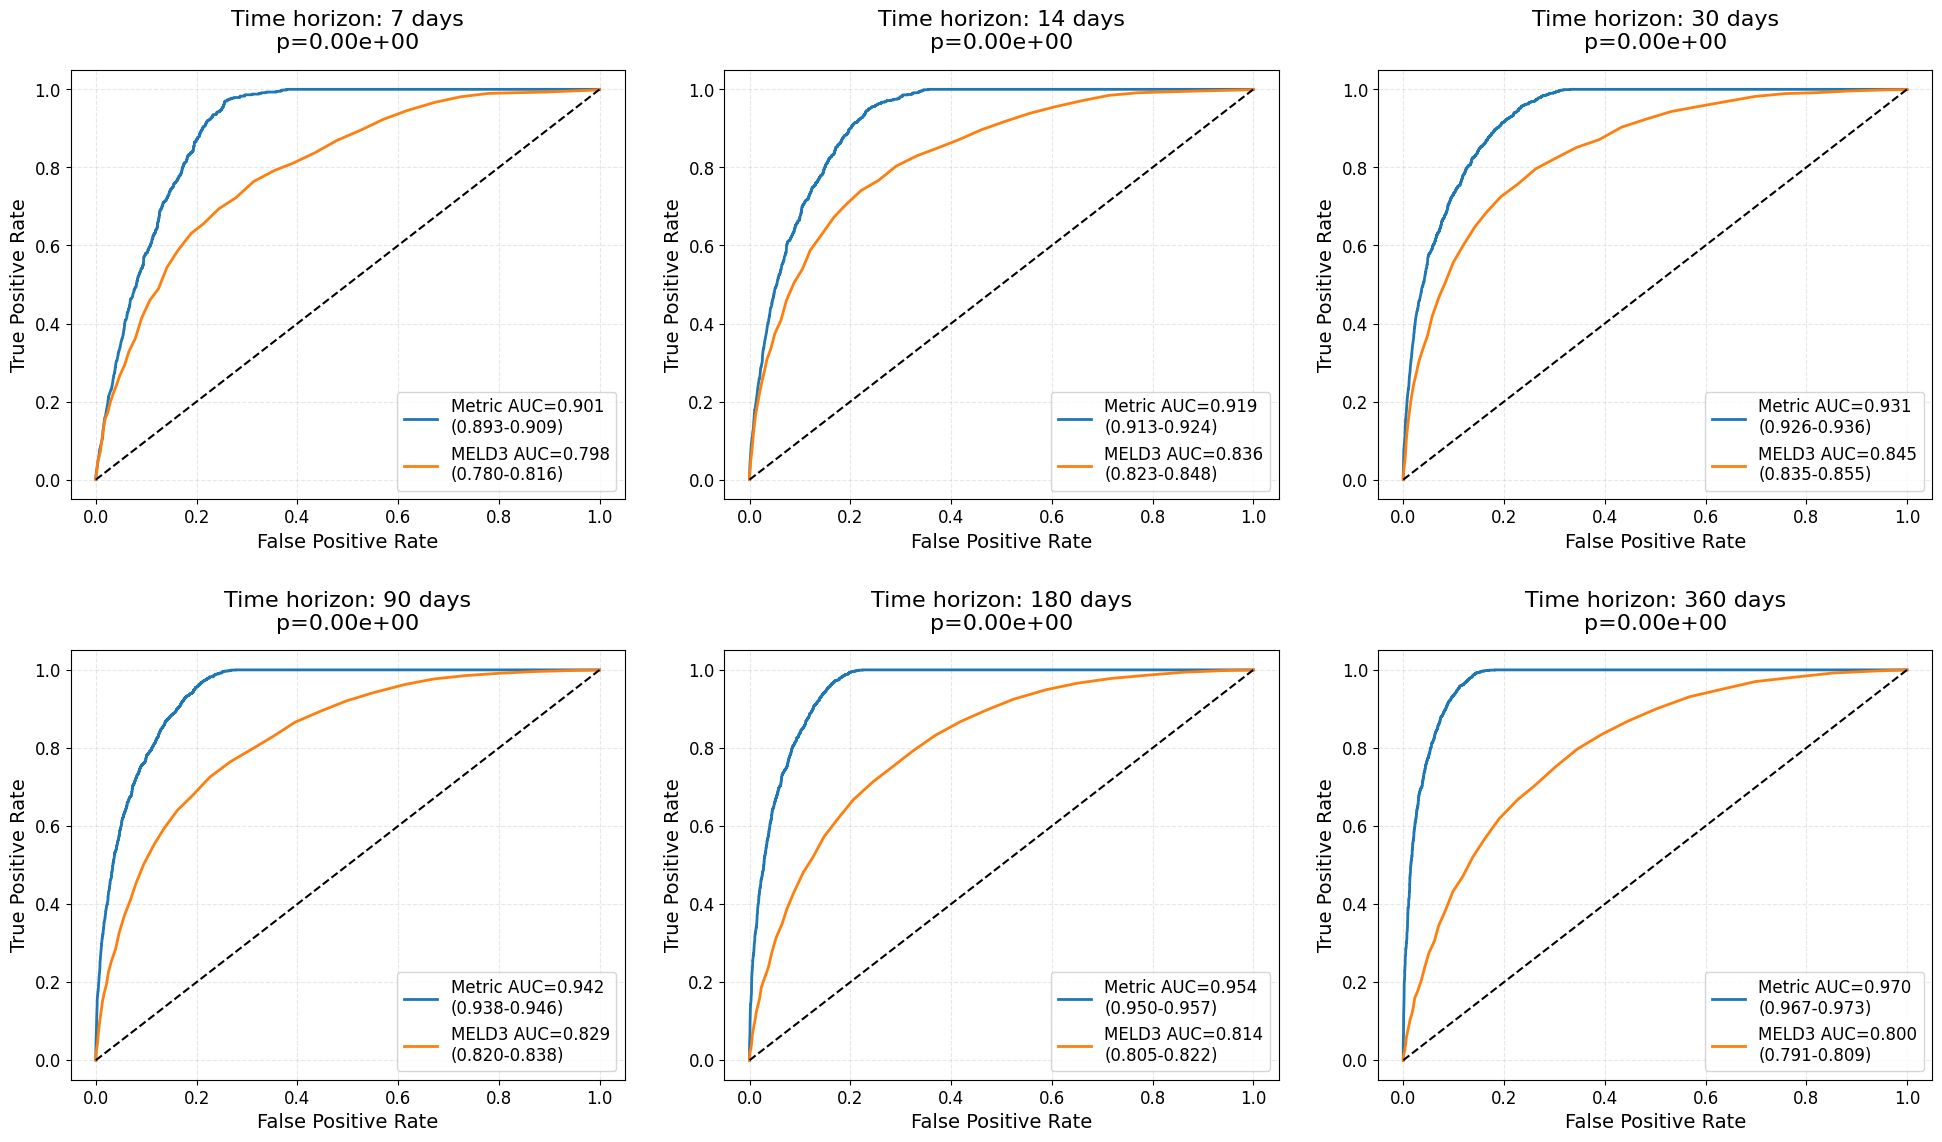

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global font sizes at the start
plt.rcParams.update({
    'font.size': 14,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis label size
    'xtick.labelsize': 12,    # X-axis tick labels
    'ytick.labelsize': 12,    # Y-axis tick labels
    'legend.fontsize': 12,    # Legend font size
})

def calculate_auc_comparison(y_true, score1, score2, n_bootstraps=1000):
    """
    Calculate AUCs and their difference with confidence interval using bootstrapping
    """
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    score1 = np.array(score1)
    score2 = np.array(score2)

    rng = np.random.RandomState(42)
    auc_diffs = []
    auc1s = []
    auc2s = []

    # Calculate original AUCs
    orig_auc1 = roc_auc_score(y_true, score1)
    orig_auc2 = roc_auc_score(y_true, score2)

    # Bootstrap sampling
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score1_boot = score1[indices]
        score2_boot = score2[indices]
        y_boot = y_true[indices]

        auc1 = roc_auc_score(y_boot, score1_boot)
        auc2 = roc_auc_score(y_boot, score2_boot)
        auc1s.append(auc1)
        auc2s.append(auc2)
        auc_diffs.append(auc1 - auc2)

    # Calculate confidence intervals for individual AUCs
    auc1_ci = np.percentile(auc1s, [2.5, 97.5])
    auc2_ci = np.percentile(auc2s, [2.5, 97.5])
    diff_ci = np.percentile(auc_diffs, [2.5, 97.5])

    # Calculate p-value (two-sided)
    p_value = 2 * min(
        np.mean(np.array(auc_diffs) <= 0),
        np.mean(np.array(auc_diffs) >= 0)
    )

    return {
        'AUC1': orig_auc1,
        'AUC1_CI': auc1_ci,
        'AUC2': orig_auc2,
        'AUC2_CI': auc2_ci,
        'AUC_diff': orig_auc1 - orig_auc2,
        'CI_lower': diff_ci[0],
        'CI_upper': diff_ci[1],
        'p_value': p_value
    }

# Initialize results and plot
time_points = [7, 14, 30, 90, 180, 360]
results = []
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

for idx, t in enumerate(tqdm(time_points)):
    # Get data for this time point
    df_all = real_df.copy()
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['time_to_event'] <= t))
    )
    df_at_risk = df_all[at_risk_mask].copy()

    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = np.array(event_mask.astype(int))

    # Convert to numpy arrays immediately
    risk_metric = np.array(-df_at_risk['median_time_to_event_metric'])
    risk_meld3 = np.array(df_at_risk['meld3'])

    # Calculate comparison metrics
    comparison = calculate_auc_comparison(
        event_indicator,
        risk_metric,
        risk_meld3
    )

    # Calculate ROC curves for plotting
    fpr_metric, tpr_metric, _ = roc_curve(event_indicator, risk_metric)
    fpr_meld3, tpr_meld3, _ = roc_curve(event_indicator, risk_meld3)

    # Plot with improved styling
    axs[idx].plot(fpr_metric, tpr_metric,
                 label=f'Metric AUC={comparison["AUC1"]:.3f}\n({comparison["AUC1_CI"][0]:.3f}-{comparison["AUC1_CI"][1]:.3f})',
                 linewidth=2)
    axs[idx].plot(fpr_meld3, tpr_meld3,
                 label=f'MELD3 AUC={comparison["AUC2"]:.3f}\n({comparison["AUC2_CI"][0]:.3f}-{comparison["AUC2_CI"][1]:.3f})',
                 linewidth=2)
    axs[idx].plot([0, 1], [0, 1], 'k--', linewidth=1.5)
    axs[idx].set_xlabel('False Positive Rate', fontsize=14)
    axs[idx].set_ylabel('True Positive Rate', fontsize=14)
    axs[idx].set_title(f'Time horizon: {t} days\np={comparison["p_value"]:.2e}',
                       fontsize=16, pad=15)
    axs[idx].legend(loc='lower right', fontsize=12, frameon=True)

    # Add grid for better readability
    axs[idx].grid(True, linestyle='--', alpha=0.3)

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'Metric_AUC': comparison['AUC1'],
        'Metric_AUC_CI': f"({comparison['AUC1_CI'][0]:.3f}-{comparison['AUC1_CI'][1]:.3f})",
        'MELD3_AUC': comparison['AUC2'],
        'MELD3_AUC_CI': f"({comparison['AUC2_CI'][0]:.3f}-{comparison['AUC2_CI'][1]:.3f})",
        'AUC_Difference': comparison['AUC_diff'],
        'Diff_CI': f"({comparison['CI_lower']:.3f}-{comparison['CI_upper']:.3f})",
        'p_value': comparison['p_value']
    })

plt.tight_layout(pad=2.0)  # Increased padding between subplots

# Save figures before showing
plt.savefig('roc_curves.png',
            dpi=300,
            bbox_inches='tight',
            format='png',
            facecolor='white',
            edgecolor='none')

plt.savefig('roc_curves.tiff',
            dpi=300,
            bbox_inches='tight',
            format='tiff',
            facecolor='white',
            edgecolor='none',
            pil_kwargs={"compression": "lzw"})

# Print formatted results
print("\nTime-Dependent AUC with Confidence Intervals:")
print("=" * 100)
for row in results:
    print(f"\n{row['Time']} days:")
    print(f"Events: {row['N_events_by_t']}/{row['N_at_risk']} ({row['N_events_by_t']/row['N_at_risk']*100:.1f}%)")
    print(f"Metric AUC: {row['Metric_AUC']:.3f} {row['Metric_AUC_CI']}")
    print(f"MELD3 AUC: {row['MELD3_AUC']:.3f} {row['MELD3_AUC_CI']}")
    print(f"AUC Difference: {row['AUC_Difference']:.3f} {row['Diff_CI']}")
    if row['p_value'] < 0.05:
        significance = "significant"
    else:
        significance = "not significant"
    print(f"P-value: {row['p_value']:.4e} ({significance})")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

df_all = real_df.copy()

for t in time_points:
    # Define at-risk set (patients who haven't died or been transplanted by time t)
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |  # Still under observation
        ((df_all['outcome'] == 0) & (df_all['time_to_event'] <= t))  # Died by t
    )

    df_at_risk = df_all[at_risk_mask].copy()

    # Event indicator (death by time t)
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # Risk scores
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # AUC calculation
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    # Count CUMULATIVE transplants up to time t in the FULL dataset
    n_transplants = sum(
        (df_all['outcome'] == 2) &
        (df_all['time_to_event'] <= t)
    )

    # Count those still in observation (not died, not transplanted by time t)
    n_still_waiting = sum(
        (df_all['time_to_event'] > t) &
        (df_all['outcome'] != 0)  # Not died
    )

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'N_transplants_by_t': n_transplants,
        'N_still_waiting': n_still_waiting,
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Including Transplants as Censored):")
print(results_df)


Time-Dependent AUC (Including Transplants as Censored):
   Time  N_at_risk  N_events_by_t  N_transplants_by_t  N_still_waiting  \
0     7       8999            156                 416             6907   
1    14       8788            315                 592             6700   
2    30       8467            531                 844             6394   
3    90       7837            901                1247             5755   
4   180       7182           1170                1555             5114   
5   360       6329           1446                1817             4261   

   AUC_metric  AUC_meld3  
0    0.889749   0.900973  
1    0.892456   0.886428  
2    0.900633   0.877203  
3    0.910700   0.844853  
4    0.927640   0.823785  
5    0.951028   0.802510  


In [ ]:
# Focus on patients who died (outcome_encoded == 0)
death_mask = real_df['outcome'] == 0
df_deaths = real_df[death_mask].copy()

# Calculate IQR for each patient based on their synthetic neighbors
iqr_time_list_metric = []
for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    iqr = q3 - q1
    iqr_time_list_metric.append(iqr)

# Add IQR to real_df
real_df['iqr_time_to_event_metric'] = iqr_time_list_metric

# Update df_deaths with the new IQR values
df_deaths = real_df[death_mask].copy()

# Calculate Q1 and Q3 using median and IQR
df_deaths['Q1'] = df_deaths['median_time_to_event_metric'] - (df_deaths['iqr_time_to_event_metric'] / 2)
df_deaths['Q3'] = df_deaths['median_time_to_event_metric'] + (df_deaths['iqr_time_to_event_metric'] / 2)

# Check if actual time falls within the range
df_deaths['within_iqr'] = (df_deaths['time_to_event'] >= df_deaths['Q1']) & \
                         (df_deaths['time_to_event'] <= df_deaths['Q3'])

# Filter for deaths within 90 days
early_death_mask = df_deaths['time_to_event'] <= 90
df_early_deaths = df_deaths[early_death_mask]

# Calculate overall proportion for 0-90 days
prop_within_iqr_90d = df_early_deaths['within_iqr'].mean()
total_early_deaths = len(df_early_deaths)

# Additional analysis for 0-90 day deaths
df_early_deaths['below_q1'] = df_early_deaths['time_to_event'] < df_early_deaths['Q1']
df_early_deaths['above_q3'] = df_early_deaths['time_to_event'] > df_early_deaths['Q3']

print(f"\nAnalysis for deaths within first 90 days (N = {total_early_deaths}):")
print(f"Proportion within predicted IQR: {prop_within_iqr_90d:.3f}")
print(f"Proportion below Q1: {df_early_deaths['below_q1'].mean():.3f}")
print(f"Proportion above Q3: {df_early_deaths['above_q3'].mean():.3f}")

# Calculate median IQR width and median prediction error
median_iqr_width = df_early_deaths['iqr_time_to_event_metric'].median()
median_error = (df_early_deaths['time_to_event'] - df_early_deaths['median_time_to_event_metric']).abs().median()

print(f"\nMedian IQR width: {median_iqr_width:.1f} days")
print(f"Median absolute prediction error: {median_error:.1f} days")


Analysis for deaths within first 90 days (N = 901):
Proportion within predicted IQR: 0.777
Proportion below Q1: 0.176
Proportion above Q3: 0.047

Median IQR width: 237.3 days
Median absolute prediction error: 60.6 days


<ipython-input-27-fdc13120e97a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_early_deaths['below_q1'] = df_early_deaths['time_to_event'] < df_early_deaths['Q1']
<ipython-input-27-fdc13120e97a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_early_deaths['above_q3'] = df_early_deaths['time_to_event'] > df_early_deaths['Q3']


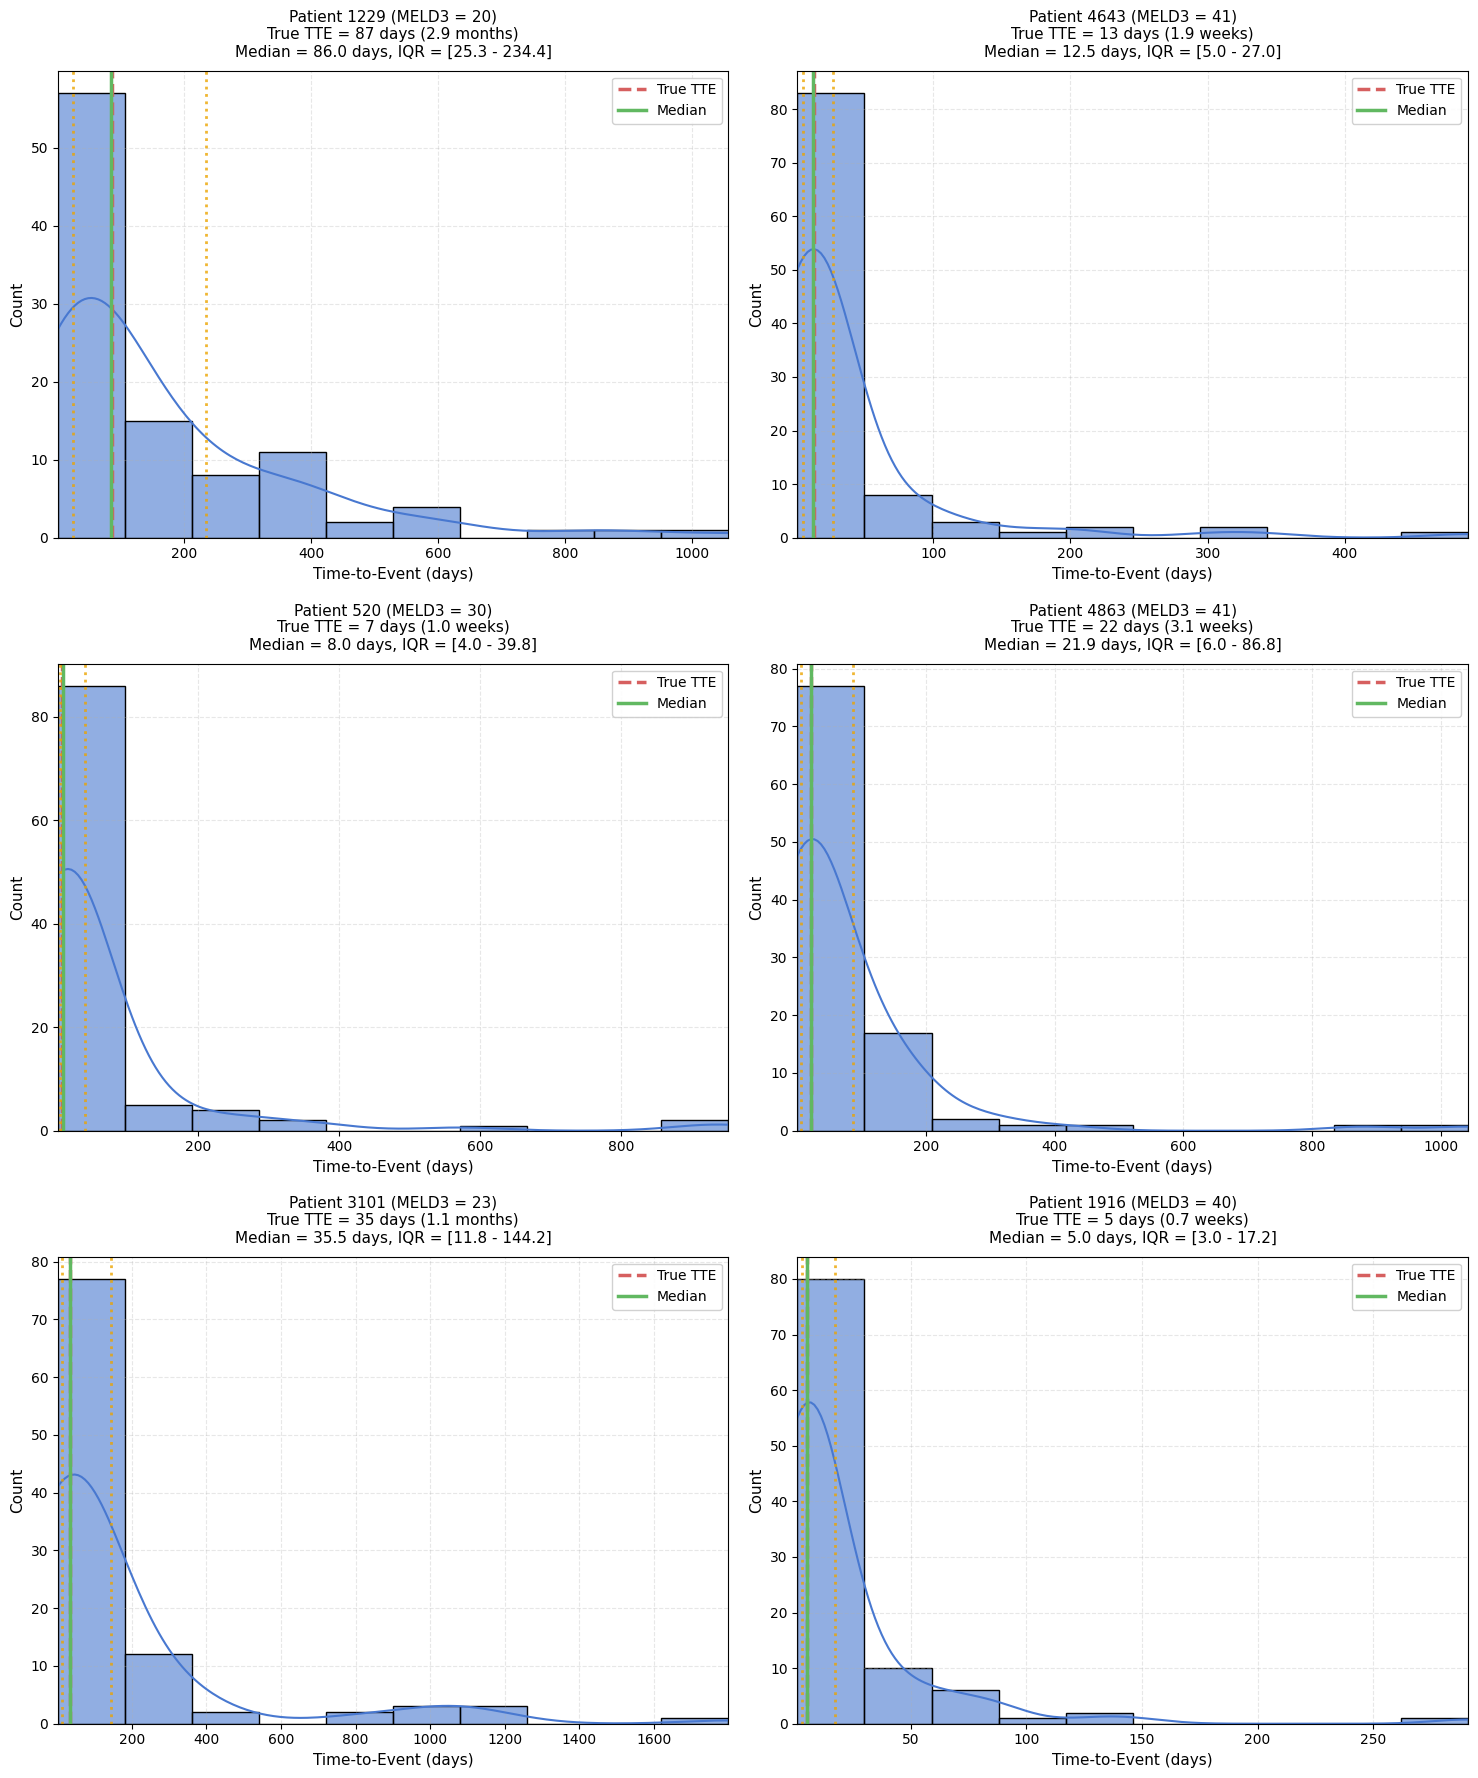

In [ ]:
# Calculate absolute difference between actual and predicted time
real_df['tte_diff'] = abs(real_df['time_to_event'] - real_df['median_time_to_event_metric'])

# Sort by smallest difference and get 6 random cases from top 100 closest matches
top_100_matches = real_df.nsmallest(100, 'tte_diff').index.values
selected_indices = np.random.choice(top_100_matches, size=6, replace=False)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.patch.set_facecolor('white')
axes = axes.flatten()

for idx, ax in zip(selected_indices, axes):
    # Get synthetic neighbors
    neighbor_indices = indices_metric[idx][:100]
    neighbor_times = syn_target[neighbor_indices]

    # Calculate statistics
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    median_syn = np.median(neighbor_times)
    range_str = f"[{q1:.1f} - {q3:.1f}]"

    # Get true time-to-event and MELD3
    true_time = real_df["time_to_event"].values[idx]
    meld3_score = real_df["INIT_MELD"].values[idx]  # Changed from meld3 to INIT_MELD

    # Determine the data range for neighbor_times
    t_min = np.min(neighbor_times)
    t_max = np.max(neighbor_times)

    # If all values are identical, artificially expand the range
    if t_min == t_max:
        t_min -= 0.5
        t_max += 0.5

    # Create exactly 10 bins between t_min and t_max
    bins_array = np.linspace(t_min, t_max, 11)

    # Plot histogram with KDE overlay
    sns.histplot(
        neighbor_times,
        bins=bins_array,
        kde=True,
        color='#4878D0',
        alpha=0.6,
        ax=ax,
        stat='count'
    )

    # Add vertical lines
    ax.axvline(true_time, color='#D65F5F', linestyle='--', linewidth=2.5,
               label='True TTE')
    ax.axvline(median_syn, color='#61B861', linestyle='-', linewidth=2.5,
               label='Median')
    ax.axvline(q1, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(q3, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)

    # Customize appearance
    ax.set_xlabel("Time-to-Event (days)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(labelsize=10)

    # Format time string
    if true_time >= 30:
        time_str = f"{true_time:.0f} days ({true_time/30.44:.1f} months)"
    else:
        time_str = f"{true_time:.0f} days ({true_time/7:.1f} weeks)"

    ax.set_title(
        f"Patient {idx} (MELD3 = {meld3_score:.0f})\n"
        f"True TTE = {time_str}\n"
        f"Median = {median_syn:.1f} days, IQR = {range_str}",
        pad=10,
        fontsize=11
    )

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(t_min, t_max)
    ax.legend(fontsize=10, framealpha=0.9)

plt.tight_layout()

# Save figures
plt.savefig('survival_predictions_similar_tte_300dpi.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('survival_predictions_similar_tte_300dpi.tiff', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

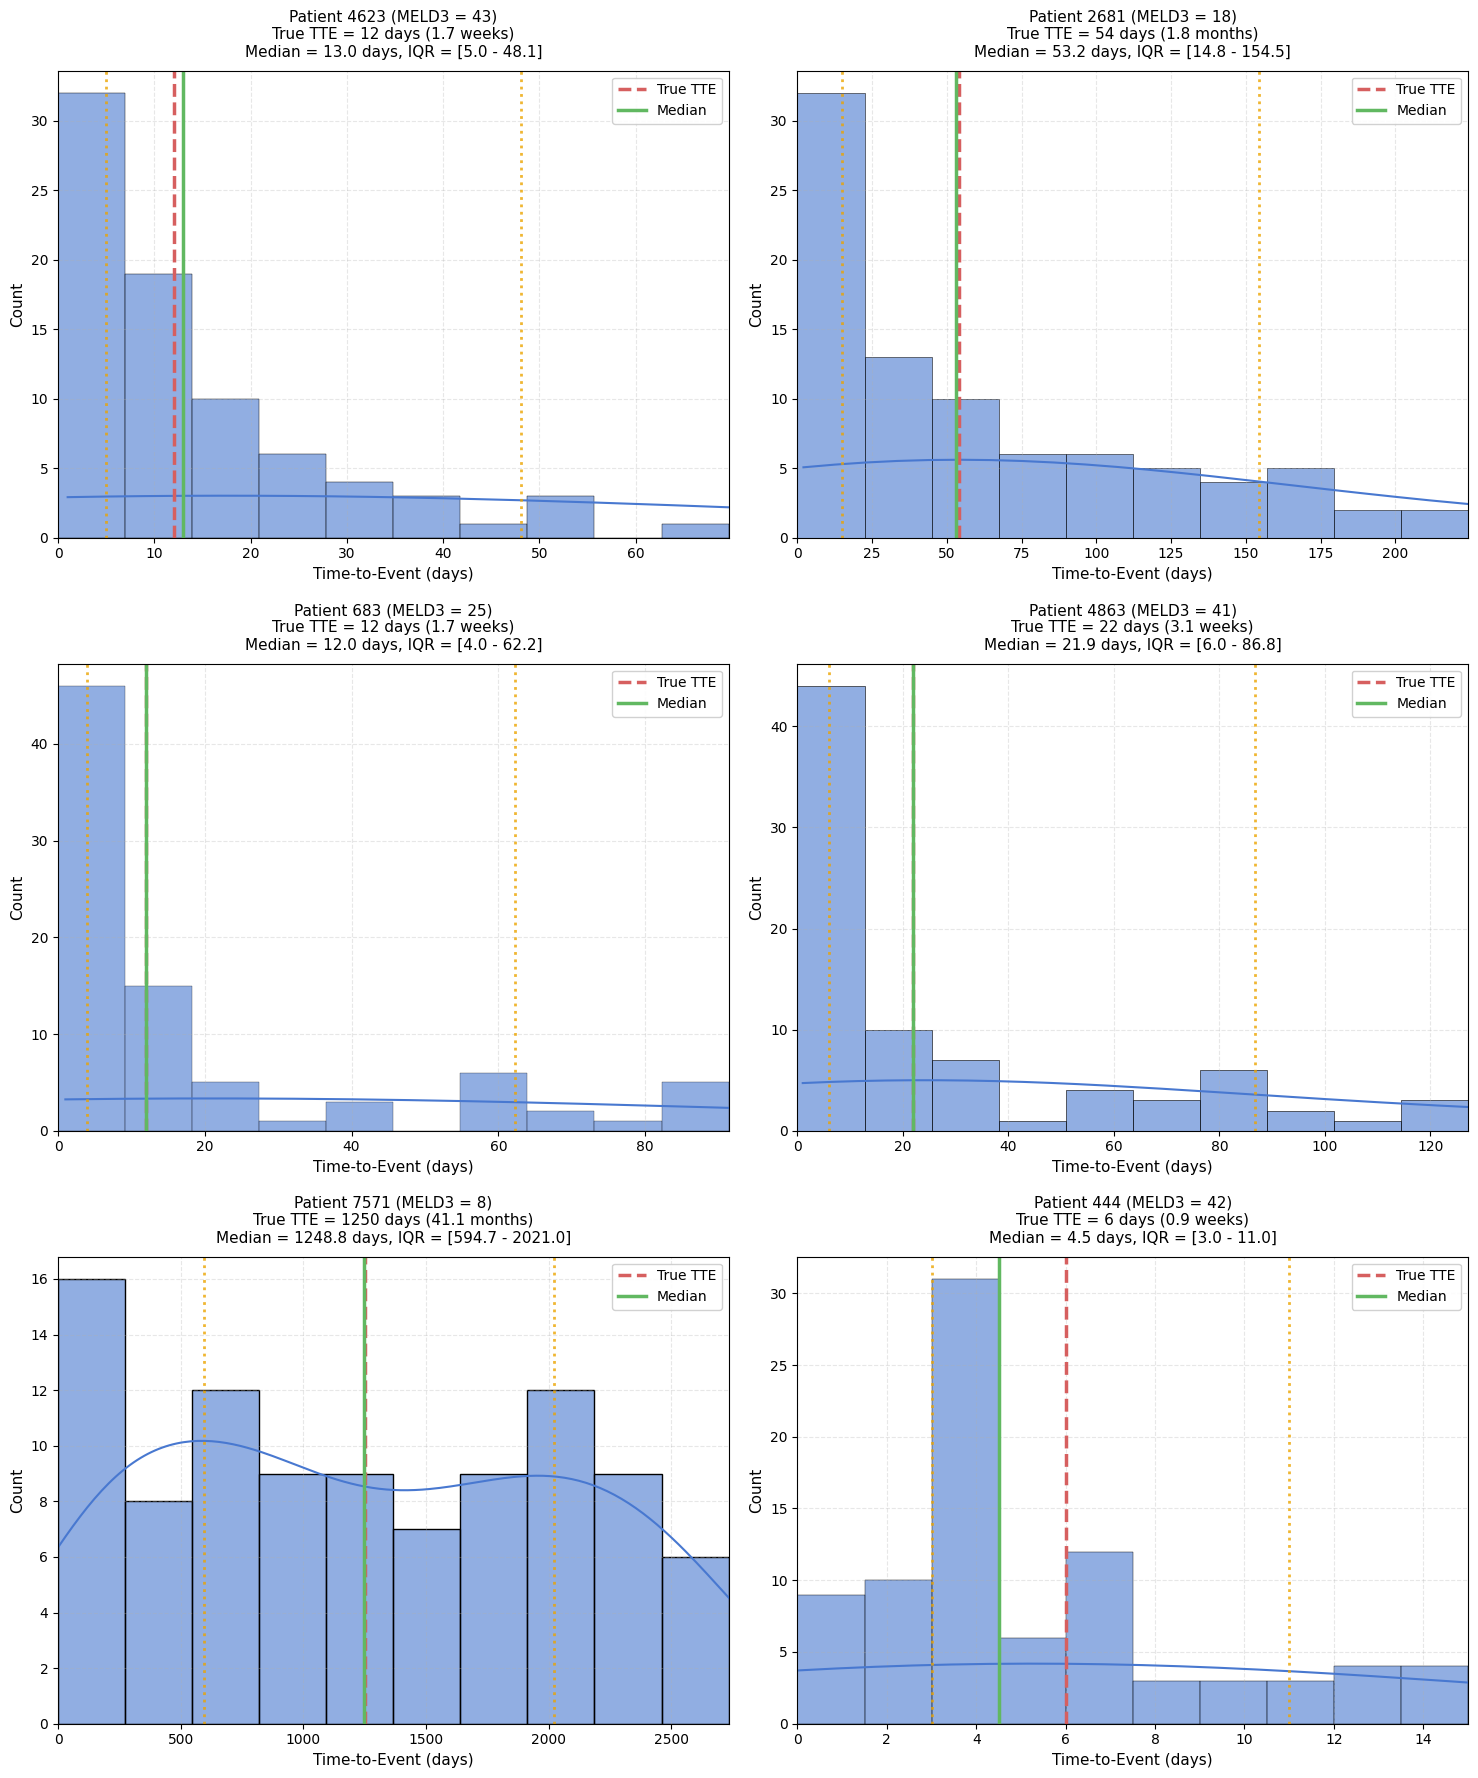

In [ ]:
# Calculate absolute difference between actual and predicted time
real_df['tte_diff'] = abs(real_df['time_to_event'] - real_df['median_time_to_event_metric'])

# Sort by smallest difference and get 6 random cases from top 100 closest matches
top_100_matches = real_df.nsmallest(100, 'tte_diff').index.values
selected_indices = np.random.choice(top_100_matches, size=6, replace=False)

# Create figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.patch.set_facecolor('white')
axes = axes.flatten()

for idx, ax in zip(selected_indices, axes):
    # Get synthetic neighbors
    neighbor_indices = indices_metric[idx][:100]
    neighbor_times = syn_target[neighbor_indices]

    # Calculate statistics
    q1 = np.percentile(neighbor_times, 25)
    q3 = np.percentile(neighbor_times, 75)
    iqr = q3 - q1

    # Set plot range to IQR plus padding
    x_min = max(0, q1 - iqr * 0.5)  # Add 50% of IQR as padding, but don't go below 0
    x_max = q3 + iqr * 0.5  # Add 50% of IQR as padding

    # Create 10 bins across this range
    bins_array = np.linspace(x_min, x_max, 11)

    median_syn = np.median(neighbor_times)
    range_str = f"[{q1:.1f} - {q3:.1f}]"

    # Get true time-to-event and MELD3
    true_time = real_df["time_to_event"].values[idx]
    meld3_score = real_df["INIT_MELD"].values[idx]

    # Plot histogram with KDE overlay using the custom bins
    sns.histplot(
        neighbor_times,
        bins=bins_array,
        kde=True,
        color='#4878D0',
        alpha=0.6,
        ax=ax,
        stat='count'
    )

    # Add vertical lines
    ax.axvline(true_time, color='#D65F5F', linestyle='--', linewidth=2.5,
               label='True TTE')
    ax.axvline(median_syn, color='#61B861', linestyle='-', linewidth=2.5,
               label='Median')
    ax.axvline(q1, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)
    ax.axvline(q3, color='#ECA400', linestyle=':', linewidth=2, alpha=0.8)

    # Customize appearance
    ax.set_xlabel("Time-to-Event (days)", fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(labelsize=10)

    # Format time string
    if true_time >= 30:
        time_str = f"{true_time:.0f} days ({true_time/30.44:.1f} months)"
    else:
        time_str = f"{true_time:.0f} days ({true_time/7:.1f} weeks)"

    ax.set_title(
        f"Patient {idx} (MELD3 = {meld3_score:.0f})\n"
        f"True TTE = {time_str}\n"
        f"Median = {median_syn:.1f} days, IQR = {range_str}",
        pad=10,
        fontsize=11
    )

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(x_min, x_max)
    ax.legend(fontsize=10, framealpha=0.9)

plt.tight_layout()

# Save figures
plt.savefig('survival_predictions_similar_tte_300dpi.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('survival_predictions_similar_tte_300dpi.tiff', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()